In [27]:
# File: colab_goemotions_finetune.py


import kagglehub
import os
import json
import torch
from datasets import load_dataset, Dataset, DatasetDict
from transformers import (AutoModelForCausalLM, AutoTokenizer, AutoModelForSequenceClassification, 
                          Trainer, TrainingArguments)
from peft import get_peft_config, LoraConfig, PeftModel
import evaluate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


In [28]:
from datasets import load_dataset

#ds = load_dataset("google-research-datasets/go_emotions", "simplified")

# load bigger dataset
ds = load_dataset("fancyzhx/dbpedia_14")

# shuffle based on random seed
ds = ds.shuffle(seed=42)

# delete the title column
ds = ds.remove_columns("title")

In [29]:
dataset = ds
dataset = dataset.rename_column("label", "labels")
dataset = dataset.rename_column("content", "text")


dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 560000
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 70000
    })
})

In [30]:
# Function to convert numeric labels to text
def convert_labels_to_one_int(example):
    #text_labels = [label_mapping[label] for label in example["labels"]]
    example["labels"] = example["labels"][0]
    return example

# Assuming `dataset` is your DatasetDict
"""dataset = DatasetDict({
    "train": ds["train"].map(convert_labels_to_one_int),
    "validation": ds["validation"].map(convert_labels_to_one_int),
    "test": ds["test"].map(convert_labels_to_one_int),
})"""



"""# Assuming you have already loaded the DatasetDict as `dataset`
dataset = DatasetDict({
    "train": dataset["test"],         # Swap test with train
    "validation": dataset["validation"],  # Keep validation as is
    "test": dataset["train"]          # Swap train with test
})"""

'# Assuming you have already loaded the DatasetDict as `dataset`\ndataset = DatasetDict({\n    "train": dataset["test"],         # Swap test with train\n    "validation": dataset["validation"],  # Keep validation as is\n    "test": dataset["train"]          # Swap train with test\n})'

In [31]:
"""def preprocess_labels(example):
    example['labels'] = max(0, min(example['labels'], 27))  # Ensure labels are within range
    return example

dataset = dataset.map(preprocess_labels)"""

"def preprocess_labels(example):\n    example['labels'] = max(0, min(example['labels'], 27))  # Ensure labels are within range\n    return example\n\ndataset = dataset.map(preprocess_labels)"

In [32]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Prepare the dataset for training
"""def preprocess_function(example, tokenizer, max_length=128):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=max_length)"""
def preprocess_function(example, tokenizer, max_length=128):
    inputs = tokenizer(example['text'], truncation=True, padding='max_length', max_length=max_length)
    inputs['labels'] = torch.tensor(example['labels']).long()  # Convert to tensor
    return inputs


tokenizers = {
    "google/mobilebert-uncased": AutoTokenizer.from_pretrained("google/mobilebert-uncased"),
    "distilbert": AutoTokenizer.from_pretrained("distilbert-base-uncased"),
    "roberta": AutoTokenizer.from_pretrained("roberta-base"),
}

# Update model configuration for multi-label
from transformers import AutoConfig
# Models for fine-tuning
"""models = {
    "distilbert": {
        "path": "google/mobilebert-uncased",
        "model": AutoModelForSequenceClassification.from_pretrained("google/mobilebert-uncased", num_labels=14, cache_dir="./models"),
        "size": "100MB"
    }
}"""





'models = {\n    "distilbert": {\n        "path": "google/mobilebert-uncased",\n        "model": AutoModelForSequenceClassification.from_pretrained("google/mobilebert-uncased", num_labels=14, cache_dir="./models"),\n        "size": "100MB"\n    }\n}'

In [33]:
"""
# Prepare the dataset for training
def preprocess_function(example, tokenizer, max_length=128):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=max_length)

# Prepare the tokenizers with padding token
tokenizers = {
    "gpt2": AutoTokenizer.from_pretrained("gpt2"),
    "distilbert": AutoTokenizer.from_pretrained("distilbert-base-uncased"),
    "roberta": AutoTokenizer.from_pretrained("roberta-base"),
}

# Ensure each tokenizer has a padding token
for model_name, tokenizer in tokenizers.items():
    if tokenizer.pad_token is None:
        if tokenizer.eos_token:
            tokenizer.pad_token = tokenizer.eos_token
        else:
            tokenizer.add_special_tokens({'pad_token': '[PAD]'})


# Models for fine-tuning
models = {
    "gpt2": {
        "path": "gpt2",
        "model": AutoModelForCausalLM.from_pretrained("gpt2", cache_dir="./models"),
        "size": "500MB"
    },
    "distilbert": {
        "path": "distilbert-base-uncased",
        "model": AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=27, cache_dir="./models"),
        "size": "750MB"
    },
    "roberta": {
        "path": "roberta-base",
        "model": AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=27, cache_dir="./models"),
        "size": "1GB"
    }
}
"""

'\n# Prepare the dataset for training\ndef preprocess_function(example, tokenizer, max_length=128):\n    return tokenizer(example[\'text\'], truncation=True, padding=\'max_length\', max_length=max_length)\n\n# Prepare the tokenizers with padding token\ntokenizers = {\n    "gpt2": AutoTokenizer.from_pretrained("gpt2"),\n    "distilbert": AutoTokenizer.from_pretrained("distilbert-base-uncased"),\n    "roberta": AutoTokenizer.from_pretrained("roberta-base"),\n}\n\n# Ensure each tokenizer has a padding token\nfor model_name, tokenizer in tokenizers.items():\n    if tokenizer.pad_token is None:\n        if tokenizer.eos_token:\n            tokenizer.pad_token = tokenizer.eos_token\n        else:\n            tokenizer.add_special_tokens({\'pad_token\': \'[PAD]\'})\n\n\n# Models for fine-tuning\nmodels = {\n    "gpt2": {\n        "path": "gpt2",\n        "model": AutoModelForCausalLM.from_pretrained("gpt2", cache_dir="./models"),\n        "size": "500MB"\n    },\n    "distilbert": {\n       

In [ ]:
import torch
from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification, DistilBertTokenizer,TrainerCallback
import numpy as np
from sklearn.metrics import accuracy_score
import evaluate
import json

# Load accuracy metric from evaluate library
accuracy_metric = evaluate.load("accuracy")

"""# Compute metrics
def compute_metrics(pred):
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=predictions, references=labels)
    return {"accuracy": acc["accuracy"]}"""
from sklearn.metrics import f1_score

def compute_metrics(pred):
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average="weighted")  # Use weighted F1-score
    return {"f1": f1}



def train_model(model_name, model, tokenizer, dataset, training_args, lora=False):
    if lora:
        model.classifier = torch.nn.Linear(model.config.hidden_size, 14)
        print(f"Applying QLoRA to {model_name}...")
        # Dynamically set target modules based on the model type
        """if model_name == "distilbert":
            target_modules = ["ffn.lin1", "ffn.lin2"]
        elif model_name == "roberta":
            target_modules = ["intermediate.dense", "output.dense"]
        elif model_name == "gpt2":
            target_modules = ["c_fc", "c_proj"]
        if model_name == "tinybert":
            target_modules = ["encoder.layer.*.attention.self.query", "encoder.layer.*.attention.self.key", "encoder.layer.*.attention.self.value"]
    
        else:
            raise ValueError(f"LoRA target modules not defined for {model_name}")"""
        target_modules = [
        "encoder.embeddings.word_embeddings",  # Input layer (embedding layer)
        "classifier"  # Output classifier layer
        ]

        config = LoraConfig(
            r=8, lora_alpha=32, lora_dropout=0.1, target_modules=target_modules
        )
        model = PeftModel(model, config)

        for param in model.base_model.parameters():
            param.requires_grad = False  # Freeze all layers of the base model

        # Optionally, unfreeze certain layers for training
        print(model.base_model)
        for param in model.base_model.classifier.parameters():  # Unfreeze last layer
            param.requires_grad = True

        # Ensure LoRA parameters are trainable
        for name, param in model.named_parameters():
            if 'lora' in name:
                param.requires_grad = True
        print("LoRA parameters are trainable.")

    dataset = dataset.map(lambda x: preprocess_function(x, tokenizer), batched=True)
    #dataset = dataset.remove_columns(['input_ids', 'attention_mask'])  # Adjust as per your dataset structure

    class LogMetricsCallback(TrainerCallback):
        def __init__(self, log_dir="./logs/log_history_real_train_data.json"):
            self.log_dir = log_dir
            self.logs = []

        def on_log(self, args, state, control, logs=None, **kwargs):
            if logs:
                log_entry = {
                    "epoch": logs.get("epoch"),
                    "train_loss": logs.get("loss"),
                    "learning_rate": logs.get("learning_rate"),
                    "grad_norm": logs.get("grad_norm", None),
                    "eval_loss": logs.get("eval_loss", None),
                    "eval_accuracy": logs.get("eval_accuracy", None),
                    "optimizer_state": logs.get("optimizer_state", None)
                }
                self.logs.append(log_entry)
                with open(self.log_dir, "w") as f:
                    json.dump(self.logs, f, indent=4)

    trainer = Trainer(
        model=model,
        args=training_args, 
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[LogMetricsCallback(log_dir="./logs/log_history.json")]
    )

    trainer.train()
    return trainer


In [35]:
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 560000
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 70000
    })
})

In [36]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Prepare the dataset for training
"""def preprocess_function(example, tokenizer, max_length=128):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=max_length)"""
def preprocess_function(example, tokenizer, max_length=128):
    inputs = tokenizer(example['text'], truncation=True, padding='max_length', max_length=max_length)
    inputs['labels'] = torch.tensor(example['labels']).long()  # Convert to tensor
    return inputs


tokenizers = {
    "google/mobilebert-uncased": AutoTokenizer.from_pretrained("google/mobilebert-uncased"),
    "distilbert": AutoTokenizer.from_pretrained("distilbert-base-uncased"),
    "roberta": AutoTokenizer.from_pretrained("roberta-base"),
}

# Update model configuration for multi-label
from transformers import AutoConfig
# Models for fine-tuning
models = {
    "google/mobilebert-uncased": {
        "path": "google/mobilebert-uncased",
        "model": AutoModelForSequenceClassification.from_pretrained("google/mobilebert-uncased", num_labels=14, cache_dir="./models"),
        "size": "100MB"
    }
}





Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 560000
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 70000
    })
})

In [38]:
from transformers import TrainingArguments, Trainer

# Training configurations
training_args = TrainingArguments(
    output_dir="./results_real_data",
    evaluation_strategy="epoch",  # Evaluate and save model after each epoch
    save_strategy="epoch",  # Save model after each epoch
    logging_dir="./logs",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=1,
    weight_decay=0.01,
    push_to_hub=False,
    logging_first_step=False,  # Make sure logs are being stored
    load_best_model_at_end=False,  # We will manually track the best model
)

model_name = "google/mobilebert-uncased"
model_info = models[model_name]
print(f"Training {model_name} ({model_info['size']}) with standard fine-tuning...")


Training google/mobilebert-uncased (100MB) with standard fine-tuning...


In [39]:


import torch
from sklearn.metrics import accuracy_score


# Set the device to GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize variables to track best model and metrics
best_eval_loss = float("inf")
best_eval_accuracy = 0
best_model = None

# Assuming `train_model` is your function to create and train the model
epoch = 0
trainer = train_model(model_name, model_info["model"], tokenizers[model_name], dataset, training_args, lora=True)


    


Applying QLoRA to google/mobilebert-uncased...


ValueError: Target modules {'encoder.layer.*.attention.self.query', 'encoder.layer.*.attention.self.value'} not found in the base model. Please check the target modules and try again.

Accuracy: 98.98%
F1-Score: 98.98%
Confusion Matrix:
[[4862   30   11    2    7   22   37    3    0    0    0    4    1   21]
 [  46 4921    2    0    4    0   26    0    1    0    0    0    0    0]
 [   4    0 4925    4   59    0    0    0    0    0    0    6    0    2]
 [   0    0   24 4969    7    0    0    0    0    0    0    0    0    0]
 [   1    0   67   12 4916    0    3    0    0    0    0    0    0    1]
 [  18    0    0    1    0 4974    5    0    0    0    0    0    0    2]
 [  39   23    1    0    2   13 4910    8    3    1    0    0    0    0]
 [   2    0    0    0    0    0   16 4974    7    0    0    0    0    1]
 [   0    0    0    0    0    0    2    3 4995    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0 4980   20    0    0    0]
 [  11    0    0    0    0    1    0    0    0   18 4970    0    0    0]
 [   0    0    3    1    0    0    0    0    0    0    0 4980   13    3]
 [   2    0    1    0    0    1    0    0    0    0    0   18 4955   23]

  0%|          | 0/8750 [00:00<?, ?it/s]

{'loss': 0.0528, 'grad_norm': 0.6200492978096008, 'learning_rate': 1.885714285714286e-05, 'epoch': 0.06}
{'loss': 0.0461, 'grad_norm': 0.11805219948291779, 'learning_rate': 1.7714285714285717e-05, 'epoch': 0.11}
{'loss': 0.0492, 'grad_norm': 3.0615556240081787, 'learning_rate': 1.6571428571428574e-05, 'epoch': 0.17}
{'loss': 0.0433, 'grad_norm': 2.457411289215088, 'learning_rate': 1.542857142857143e-05, 'epoch': 0.23}
{'loss': 0.0484, 'grad_norm': 0.5196378827095032, 'learning_rate': 1.4285714285714287e-05, 'epoch': 0.29}
{'loss': 0.0429, 'grad_norm': 0.1599406898021698, 'learning_rate': 1.3142857142857145e-05, 'epoch': 0.34}
{'loss': 0.0406, 'grad_norm': 1.520076870918274, 'learning_rate': 1.2e-05, 'epoch': 0.4}
{'loss': 0.0417, 'grad_norm': 2.4105076789855957, 'learning_rate': 1.0857142857142858e-05, 'epoch': 0.46}
{'loss': 0.0392, 'grad_norm': 0.05384308844804764, 'learning_rate': 9.714285714285715e-06, 'epoch': 0.51}
{'loss': 0.0449, 'grad_norm': 4.053988456726074, 'learning_rate':

  0%|          | 0/1094 [00:00<?, ?it/s]

{'eval_runtime': 53.8346, 'eval_samples_per_second': 1300.279, 'eval_steps_per_second': 20.322, 'epoch': 1.0}
{'train_runtime': 972.9552, 'train_samples_per_second': 575.566, 'train_steps_per_second': 8.993, 'train_loss': 0.042401345934186666, 'epoch': 1.0}
Model saved after epoch 1 at ./saved_models/model_epoch_1
Accuracy: 99.09%
F1-Score: 99.09%
Confusion Matrix:
[[4876   32    9    1    6   19   35    2    0    0    0    2    0   18]
 [  43 4929    3    0    3    0   21    0    1    0    0    0    0    0]
 [   4    0 4929    5   56    0    0    0    0    0    0    4    0    2]
 [   0    0   18 4975    7    0    0    0    0    0    0    0    0    0]
 [   2    1   57   12 4925    0    2    0    0    0    0    0    0    1]
 [  12    0    0    1    0 4982    4    0    0    0    0    0    0    1]
 [  39   20    1    0    1   12 4916    7    3    1    0    0    0    0]
 [   1    0    1    0    0    0   14 4978    6    0    0    0    0    0]
 [   0    0    0    0    0    0    3    2 4995  

  0%|          | 0/8750 [00:00<?, ?it/s]

{'loss': 0.0418, 'grad_norm': 0.2717472016811371, 'learning_rate': 1.885714285714286e-05, 'epoch': 0.06}
{'loss': 0.0376, 'grad_norm': 0.14757438004016876, 'learning_rate': 1.7714285714285717e-05, 'epoch': 0.11}
{'loss': 0.0414, 'grad_norm': 3.005178213119507, 'learning_rate': 1.6571428571428574e-05, 'epoch': 0.17}
{'loss': 0.0365, 'grad_norm': 1.9284940958023071, 'learning_rate': 1.542857142857143e-05, 'epoch': 0.23}
{'loss': 0.0425, 'grad_norm': 0.3716641366481781, 'learning_rate': 1.4285714285714287e-05, 'epoch': 0.29}
{'loss': 0.0379, 'grad_norm': 0.21151649951934814, 'learning_rate': 1.3142857142857145e-05, 'epoch': 0.34}
{'loss': 0.034, 'grad_norm': 1.313960075378418, 'learning_rate': 1.2e-05, 'epoch': 0.4}
{'loss': 0.0362, 'grad_norm': 2.3723809719085693, 'learning_rate': 1.0857142857142858e-05, 'epoch': 0.46}
{'loss': 0.0352, 'grad_norm': 0.08942583203315735, 'learning_rate': 9.714285714285715e-06, 'epoch': 0.51}
{'loss': 0.0407, 'grad_norm': 4.365049362182617, 'learning_rate':

  0%|          | 0/1094 [00:00<?, ?it/s]

{'eval_runtime': 53.8639, 'eval_samples_per_second': 1299.572, 'eval_steps_per_second': 20.31, 'epoch': 1.0}
{'train_runtime': 973.0056, 'train_samples_per_second': 575.536, 'train_steps_per_second': 8.993, 'train_loss': 0.037186412593296594, 'epoch': 1.0}
Model saved after epoch 2 at ./saved_models/model_epoch_2
Accuracy: 99.15%
F1-Score: 99.15%
Confusion Matrix:
[[4885   28    7    1    4   20   35    2    0    0    0    2    0   16]
 [  45 4927    3    0    3    0   21    0    1    0    0    0    0    0]
 [   3    0 4933    5   54    0    0    0    0    0    0    3    0    2]
 [   0    0   15 4977    8    0    0    0    0    0    0    0    0    0]
 [   2    1   52    9 4933    0    2    0    0    0    0    0    0    1]
 [  12    0    0    0    0 4985    3    0    0    0    0    0    0    0]
 [  37   19    1    0    1   11 4920    7    3    1    0    0    0    0]
 [   2    0    1    0    0    0   12 4979    6    0    0    0    0    0]
 [   0    1    0    0    0    0    4    1 4994   

  0%|          | 0/8750 [00:00<?, ?it/s]

{'loss': 0.037, 'grad_norm': 0.15577064454555511, 'learning_rate': 1.885714285714286e-05, 'epoch': 0.06}
{'loss': 0.0349, 'grad_norm': 0.41647469997406006, 'learning_rate': 1.7714285714285717e-05, 'epoch': 0.11}
{'loss': 0.037, 'grad_norm': 4.207878589630127, 'learning_rate': 1.6571428571428574e-05, 'epoch': 0.17}
{'loss': 0.0332, 'grad_norm': 1.326175570487976, 'learning_rate': 1.542857142857143e-05, 'epoch': 0.23}
{'loss': 0.0396, 'grad_norm': 0.48805221915245056, 'learning_rate': 1.4285714285714287e-05, 'epoch': 0.29}
{'loss': 0.0347, 'grad_norm': 0.1043851301074028, 'learning_rate': 1.3142857142857145e-05, 'epoch': 0.34}
{'loss': 0.0325, 'grad_norm': 1.580731749534607, 'learning_rate': 1.2e-05, 'epoch': 0.4}
{'loss': 0.0335, 'grad_norm': 2.454988479614258, 'learning_rate': 1.0857142857142858e-05, 'epoch': 0.46}
{'loss': 0.0335, 'grad_norm': 0.17397922277450562, 'learning_rate': 9.714285714285715e-06, 'epoch': 0.51}
{'loss': 0.0378, 'grad_norm': 3.485724687576294, 'learning_rate': 8

  0%|          | 0/1094 [00:00<?, ?it/s]

{'eval_runtime': 53.9394, 'eval_samples_per_second': 1297.753, 'eval_steps_per_second': 20.282, 'epoch': 1.0}
{'train_runtime': 973.5682, 'train_samples_per_second': 575.204, 'train_steps_per_second': 8.988, 'train_loss': 0.03467959300449916, 'epoch': 1.0}
Model saved after epoch 3 at ./saved_models/model_epoch_3
Accuracy: 99.20%
F1-Score: 99.20%
Confusion Matrix:
[[4885   28    7    1    3   19   34    2    0    0    0    2    0   19]
 [  40 4933    3    0    3    0   20    0    1    0    0    0    0    0]
 [   4    0 4937    5   50    0    0    0    0    0    0    2    0    2]
 [   0    0   13 4979    8    0    0    0    0    0    0    0    0    0]
 [   2    1   50    7 4937    0    2    0    0    0    0    0    1    0]
 [  12    0    0    0    0 4985    3    0    0    0    0    0    0    0]
 [  35   19    1    0    1   11 4922    7    3    1    0    0    0    0]
 [   0    0    1    0    0    0   11 4982    6    0    0    0    0    0]
 [   0    1    0    0    0    0    2    1 4996   

  0%|          | 0/8750 [00:00<?, ?it/s]

{'loss': 0.0347, 'grad_norm': 0.11033253371715546, 'learning_rate': 1.885714285714286e-05, 'epoch': 0.06}
{'loss': 0.0316, 'grad_norm': 0.20719943940639496, 'learning_rate': 1.7714285714285717e-05, 'epoch': 0.11}
{'loss': 0.0344, 'grad_norm': 5.452469825744629, 'learning_rate': 1.6571428571428574e-05, 'epoch': 0.17}
{'loss': 0.0322, 'grad_norm': 1.2897562980651855, 'learning_rate': 1.542857142857143e-05, 'epoch': 0.23}
{'loss': 0.0386, 'grad_norm': 0.3121337592601776, 'learning_rate': 1.4285714285714287e-05, 'epoch': 0.29}
{'loss': 0.0323, 'grad_norm': 0.30406397581100464, 'learning_rate': 1.3142857142857145e-05, 'epoch': 0.34}
{'loss': 0.0308, 'grad_norm': 1.880786418914795, 'learning_rate': 1.2e-05, 'epoch': 0.4}
{'loss': 0.0321, 'grad_norm': 2.090505599975586, 'learning_rate': 1.0857142857142858e-05, 'epoch': 0.46}
{'loss': 0.0315, 'grad_norm': 0.04614179953932762, 'learning_rate': 9.714285714285715e-06, 'epoch': 0.51}
{'loss': 0.0375, 'grad_norm': 3.7197279930114746, 'learning_rate

  0%|          | 0/1094 [00:00<?, ?it/s]

{'eval_runtime': 53.6899, 'eval_samples_per_second': 1303.784, 'eval_steps_per_second': 20.376, 'epoch': 1.0}
{'train_runtime': 972.8262, 'train_samples_per_second': 575.642, 'train_steps_per_second': 8.994, 'train_loss': 0.03307803862435477, 'epoch': 1.0}
Model saved after epoch 4 at ./saved_models/model_epoch_4
Accuracy: 99.23%
F1-Score: 99.23%
Confusion Matrix:
[[4886   30    6    1    3   17   34    1    0    2    0    2    0   18]
 [  38 4935    2    0    4    0   19    0    1    0    0    0    0    1]
 [   4    0 4941    5   47    0    0    0    0    0    0    1    0    2]
 [   0    0   11 4980    9    0    0    0    0    0    0    0    0    0]
 [   2    1   44    7 4943    0    2    0    0    0    0    0    1    0]
 [  13    0    0    0    0 4984    3    0    0    0    0    0    0    0]
 [  33   19    1    0    1   12 4922    8    3    1    0    0    0    0]
 [   0    0    1    0    0    0    9 4983    7    0    0    0    0    0]
 [   0    1    0    0    0    0    2    1 4996   

  0%|          | 0/8750 [00:00<?, ?it/s]

{'loss': 0.0326, 'grad_norm': 0.04958484694361687, 'learning_rate': 1.885714285714286e-05, 'epoch': 0.06}
{'loss': 0.0309, 'grad_norm': 0.17773093283176422, 'learning_rate': 1.7714285714285717e-05, 'epoch': 0.11}
{'loss': 0.0329, 'grad_norm': 5.425532341003418, 'learning_rate': 1.6571428571428574e-05, 'epoch': 0.17}
{'loss': 0.03, 'grad_norm': 0.8586432933807373, 'learning_rate': 1.542857142857143e-05, 'epoch': 0.23}
{'loss': 0.036, 'grad_norm': 0.10372887551784515, 'learning_rate': 1.4285714285714287e-05, 'epoch': 0.29}
{'loss': 0.0311, 'grad_norm': 0.6456899046897888, 'learning_rate': 1.3142857142857145e-05, 'epoch': 0.34}
{'loss': 0.0298, 'grad_norm': 1.2094050645828247, 'learning_rate': 1.2e-05, 'epoch': 0.4}
{'loss': 0.0307, 'grad_norm': 1.9291404485702515, 'learning_rate': 1.0857142857142858e-05, 'epoch': 0.46}
{'loss': 0.0302, 'grad_norm': 0.07569124549627304, 'learning_rate': 9.714285714285715e-06, 'epoch': 0.51}
{'loss': 0.035, 'grad_norm': 3.145625352859497, 'learning_rate': 

  0%|          | 0/1094 [00:00<?, ?it/s]

{'eval_runtime': 53.9079, 'eval_samples_per_second': 1298.511, 'eval_steps_per_second': 20.294, 'epoch': 1.0}
{'train_runtime': 971.8842, 'train_samples_per_second': 576.2, 'train_steps_per_second': 9.003, 'train_loss': 0.031812904139927455, 'epoch': 1.0}
Model saved after epoch 5 at ./saved_models/model_epoch_5
Accuracy: 99.23%
F1-Score: 99.23%
Confusion Matrix:
[[4883   29    6    1    3   17   37    1    0    2    0    2    0   19]
 [  36 4935    2    0    4    0   21    0    1    0    0    0    0    1]
 [   4    0 4941    5   47    0    0    0    0    0    0    1    0    2]
 [   0    0   10 4981    9    0    0    0    0    0    0    0    0    0]
 [   3    0   43    7 4944    0    2    0    0    0    0    0    1    0]
 [  12    0    0    0    0 4985    3    0    0    0    0    0    0    0]
 [  31   19    1    0    1   12 4926    6    3    1    0    0    0    0]
 [   0    0    1    0    0    0   11 4982    6    0    0    0    0    0]
 [   0    1    0    0    0    0    2    1 4996    

  0%|          | 0/8750 [00:00<?, ?it/s]

{'loss': 0.0308, 'grad_norm': 0.06035907194018364, 'learning_rate': 1.885714285714286e-05, 'epoch': 0.06}
{'loss': 0.0288, 'grad_norm': 0.38171088695526123, 'learning_rate': 1.7714285714285717e-05, 'epoch': 0.11}
{'loss': 0.0316, 'grad_norm': 5.2420654296875, 'learning_rate': 1.6571428571428574e-05, 'epoch': 0.17}
{'loss': 0.0283, 'grad_norm': 1.2613508701324463, 'learning_rate': 1.542857142857143e-05, 'epoch': 0.23}
{'loss': 0.035, 'grad_norm': 0.458516925573349, 'learning_rate': 1.4285714285714287e-05, 'epoch': 0.29}
{'loss': 0.0295, 'grad_norm': 1.0054548978805542, 'learning_rate': 1.3142857142857145e-05, 'epoch': 0.34}
{'loss': 0.0285, 'grad_norm': 0.5945021510124207, 'learning_rate': 1.2e-05, 'epoch': 0.4}
{'loss': 0.0294, 'grad_norm': 1.8039647340774536, 'learning_rate': 1.0857142857142858e-05, 'epoch': 0.46}
{'loss': 0.0298, 'grad_norm': 0.05275046452879906, 'learning_rate': 9.714285714285715e-06, 'epoch': 0.51}
{'loss': 0.0344, 'grad_norm': 2.9185781478881836, 'learning_rate': 

  0%|          | 0/1094 [00:00<?, ?it/s]

{'eval_runtime': 53.8653, 'eval_samples_per_second': 1299.537, 'eval_steps_per_second': 20.31, 'epoch': 1.0}
{'train_runtime': 973.9183, 'train_samples_per_second': 574.997, 'train_steps_per_second': 8.984, 'train_loss': 0.030735075868879046, 'epoch': 1.0}
Model saved after epoch 6 at ./saved_models/model_epoch_6
Accuracy: 99.25%
F1-Score: 99.25%
Confusion Matrix:
[[4882   30    6    1    3   17   37    1    0    2    0    2    1   18]
 [  37 4937    1    0    4    0   19    0    1    0    0    0    0    1]
 [   4    0 4944    5   44    0    0    0    0    0    0    1    0    2]
 [   0    0    8 4982    9    0    0    0    0    0    0    1    0    0]
 [   3    0   44    6 4944    1    1    0    0    0    0    0    1    0]
 [  12    0    0    0    0 4985    3    0    0    0    0    0    0    0]
 [  31   17    2    0    0   12 4928    6    3    1    0    0    0    0]
 [   0    0    1    0    0    0   11 4982    6    0    0    0    0    0]
 [   0    1    0    0    0    0    2    1 4996   

  0%|          | 0/8750 [00:00<?, ?it/s]

{'loss': 0.0297, 'grad_norm': 0.04970967024564743, 'learning_rate': 1.885714285714286e-05, 'epoch': 0.06}
{'loss': 0.0279, 'grad_norm': 0.1509038656949997, 'learning_rate': 1.7714285714285717e-05, 'epoch': 0.11}
{'loss': 0.0298, 'grad_norm': 4.002444744110107, 'learning_rate': 1.6571428571428574e-05, 'epoch': 0.17}
{'loss': 0.0284, 'grad_norm': 0.6655705571174622, 'learning_rate': 1.542857142857143e-05, 'epoch': 0.23}
{'loss': 0.0334, 'grad_norm': 0.2570931613445282, 'learning_rate': 1.4285714285714287e-05, 'epoch': 0.29}
{'loss': 0.0285, 'grad_norm': 0.20596617460250854, 'learning_rate': 1.3142857142857145e-05, 'epoch': 0.34}
{'loss': 0.0283, 'grad_norm': 1.4831544160842896, 'learning_rate': 1.2e-05, 'epoch': 0.4}
{'loss': 0.0289, 'grad_norm': 2.465533494949341, 'learning_rate': 1.0857142857142858e-05, 'epoch': 0.46}
{'loss': 0.028, 'grad_norm': 0.3716893196105957, 'learning_rate': 9.714285714285715e-06, 'epoch': 0.51}
{'loss': 0.0336, 'grad_norm': 3.2886667251586914, 'learning_rate':

  0%|          | 0/1094 [00:00<?, ?it/s]

{'eval_runtime': 53.7993, 'eval_samples_per_second': 1301.132, 'eval_steps_per_second': 20.335, 'epoch': 1.0}
{'train_runtime': 976.2517, 'train_samples_per_second': 573.623, 'train_steps_per_second': 8.963, 'train_loss': 0.029921186011178155, 'epoch': 1.0}
Model saved after epoch 7 at ./saved_models/model_epoch_7
Accuracy: 99.26%
F1-Score: 99.26%
Confusion Matrix:
[[4885   28    6    1    3   16   36    1    0    2    0    2    1   19]
 [  37 4937    1    0    4    0   19    0    1    0    0    0    0    1]
 [   3    0 4949    4   40    0    0    0    0    0    0    2    0    2]
 [   0    0    9 4983    7    0    0    0    0    0    0    1    0    0]
 [   3    0   44    6 4944    1    1    0    0    0    0    0    1    0]
 [  13    0    0    0    0 4984    3    0    0    0    0    0    0    0]
 [  30   17    2    0    0   12 4928    7    3    1    0    0    0    0]
 [   0    0    1    0    0    0   12 4981    6    0    0    0    0    0]
 [   0    1    0    0    0    0    2    1 4996  

  0%|          | 0/8750 [00:00<?, ?it/s]

{'loss': 0.0278, 'grad_norm': 0.07046361267566681, 'learning_rate': 1.885714285714286e-05, 'epoch': 0.06}
{'loss': 0.0272, 'grad_norm': 0.2840096652507782, 'learning_rate': 1.7714285714285717e-05, 'epoch': 0.11}
{'loss': 0.0278, 'grad_norm': 6.376343250274658, 'learning_rate': 1.6571428571428574e-05, 'epoch': 0.17}
{'loss': 0.0266, 'grad_norm': 0.27992627024650574, 'learning_rate': 1.542857142857143e-05, 'epoch': 0.23}
{'loss': 0.0327, 'grad_norm': 0.14442595839500427, 'learning_rate': 1.4285714285714287e-05, 'epoch': 0.29}
{'loss': 0.0269, 'grad_norm': 1.6069656610488892, 'learning_rate': 1.3142857142857145e-05, 'epoch': 0.34}
{'loss': 0.028, 'grad_norm': 1.0174061059951782, 'learning_rate': 1.2e-05, 'epoch': 0.4}
{'loss': 0.0275, 'grad_norm': 1.9433281421661377, 'learning_rate': 1.0857142857142858e-05, 'epoch': 0.46}
{'loss': 0.0281, 'grad_norm': 0.16625258326530457, 'learning_rate': 9.714285714285715e-06, 'epoch': 0.51}
{'loss': 0.0329, 'grad_norm': 3.3691251277923584, 'learning_rat

  0%|          | 0/1094 [00:00<?, ?it/s]

{'eval_runtime': 53.8422, 'eval_samples_per_second': 1300.096, 'eval_steps_per_second': 20.319, 'epoch': 1.0}
{'train_runtime': 973.701, 'train_samples_per_second': 575.125, 'train_steps_per_second': 8.986, 'train_loss': 0.029075765718732563, 'epoch': 1.0}
Model saved after epoch 8 at ./saved_models/model_epoch_8
Accuracy: 99.26%
F1-Score: 99.26%
Confusion Matrix:
[[4883   30    8    1    2   16   36    1    0    2    0    2    1   18]
 [  36 4938    0    0    5    0   19    0    1    0    0    0    0    1]
 [   3    0 4949    5   40    0    0    0    0    0    0    1    0    2]
 [   0    0    5 4984   10    0    0    0    0    0    0    1    0    0]
 [   3    0   40    6 4948    1    1    0    0    0    0    0    1    0]
 [  14    0    0    0    0 4983    3    0    0    0    0    0    0    0]
 [  31   18    2    0    0   12 4926    7    3    1    0    0    0    0]
 [   0    0    1    0    0    0   13 4980    6    0    0    0    0    0]
 [   0    1    0    0    0    0    2    1 4996   

  0%|          | 0/8750 [00:00<?, ?it/s]

{'loss': 0.0265, 'grad_norm': 0.04403814300894737, 'learning_rate': 1.885714285714286e-05, 'epoch': 0.06}
{'loss': 0.0262, 'grad_norm': 0.21866415441036224, 'learning_rate': 1.7714285714285717e-05, 'epoch': 0.11}
{'loss': 0.0272, 'grad_norm': 5.538625717163086, 'learning_rate': 1.6571428571428574e-05, 'epoch': 0.17}
{'loss': 0.0271, 'grad_norm': 0.4911307394504547, 'learning_rate': 1.542857142857143e-05, 'epoch': 0.23}
{'loss': 0.0317, 'grad_norm': 0.1897868663072586, 'learning_rate': 1.4285714285714287e-05, 'epoch': 0.29}
{'loss': 0.0278, 'grad_norm': 0.1436430960893631, 'learning_rate': 1.3142857142857145e-05, 'epoch': 0.34}
{'loss': 0.0274, 'grad_norm': 1.6229631900787354, 'learning_rate': 1.2e-05, 'epoch': 0.4}
{'loss': 0.0269, 'grad_norm': 2.239102363586426, 'learning_rate': 1.0857142857142858e-05, 'epoch': 0.46}
{'loss': 0.027, 'grad_norm': 0.09905005991458893, 'learning_rate': 9.714285714285715e-06, 'epoch': 0.51}
{'loss': 0.0317, 'grad_norm': 3.1885974407196045, 'learning_rate'

  0%|          | 0/1094 [00:00<?, ?it/s]

{'eval_runtime': 53.8739, 'eval_samples_per_second': 1299.33, 'eval_steps_per_second': 20.307, 'epoch': 1.0}
{'train_runtime': 973.6446, 'train_samples_per_second': 575.159, 'train_steps_per_second': 8.987, 'train_loss': 0.02865745064871652, 'epoch': 1.0}
Model saved after epoch 9 at ./saved_models/model_epoch_9
Accuracy: 99.27%
F1-Score: 99.27%
Confusion Matrix:
[[4883   30    7    1    2   17   35    1    0    3    0    2    1   18]
 [  36 4938    1    0    5    0   18    0    1    0    0    0    0    1]
 [   4    0 4948    4   39    0    0    0    0    0    0    3    0    2]
 [   0    0    8 4982    9    0    0    0    0    0    0    1    0    0]
 [   3    0   41    6 4947    1    1    0    0    0    0    0    1    0]
 [  13    0    0    0    0 4983    3    0    0    0    0    0    1    0]
 [  29   15    2    0    0   12 4932    6    3    1    0    0    0    0]
 [   0    0    1    0    0    0   12 4981    6    0    0    0    0    0]
 [   0    1    0    0    0    0    2    1 4996    

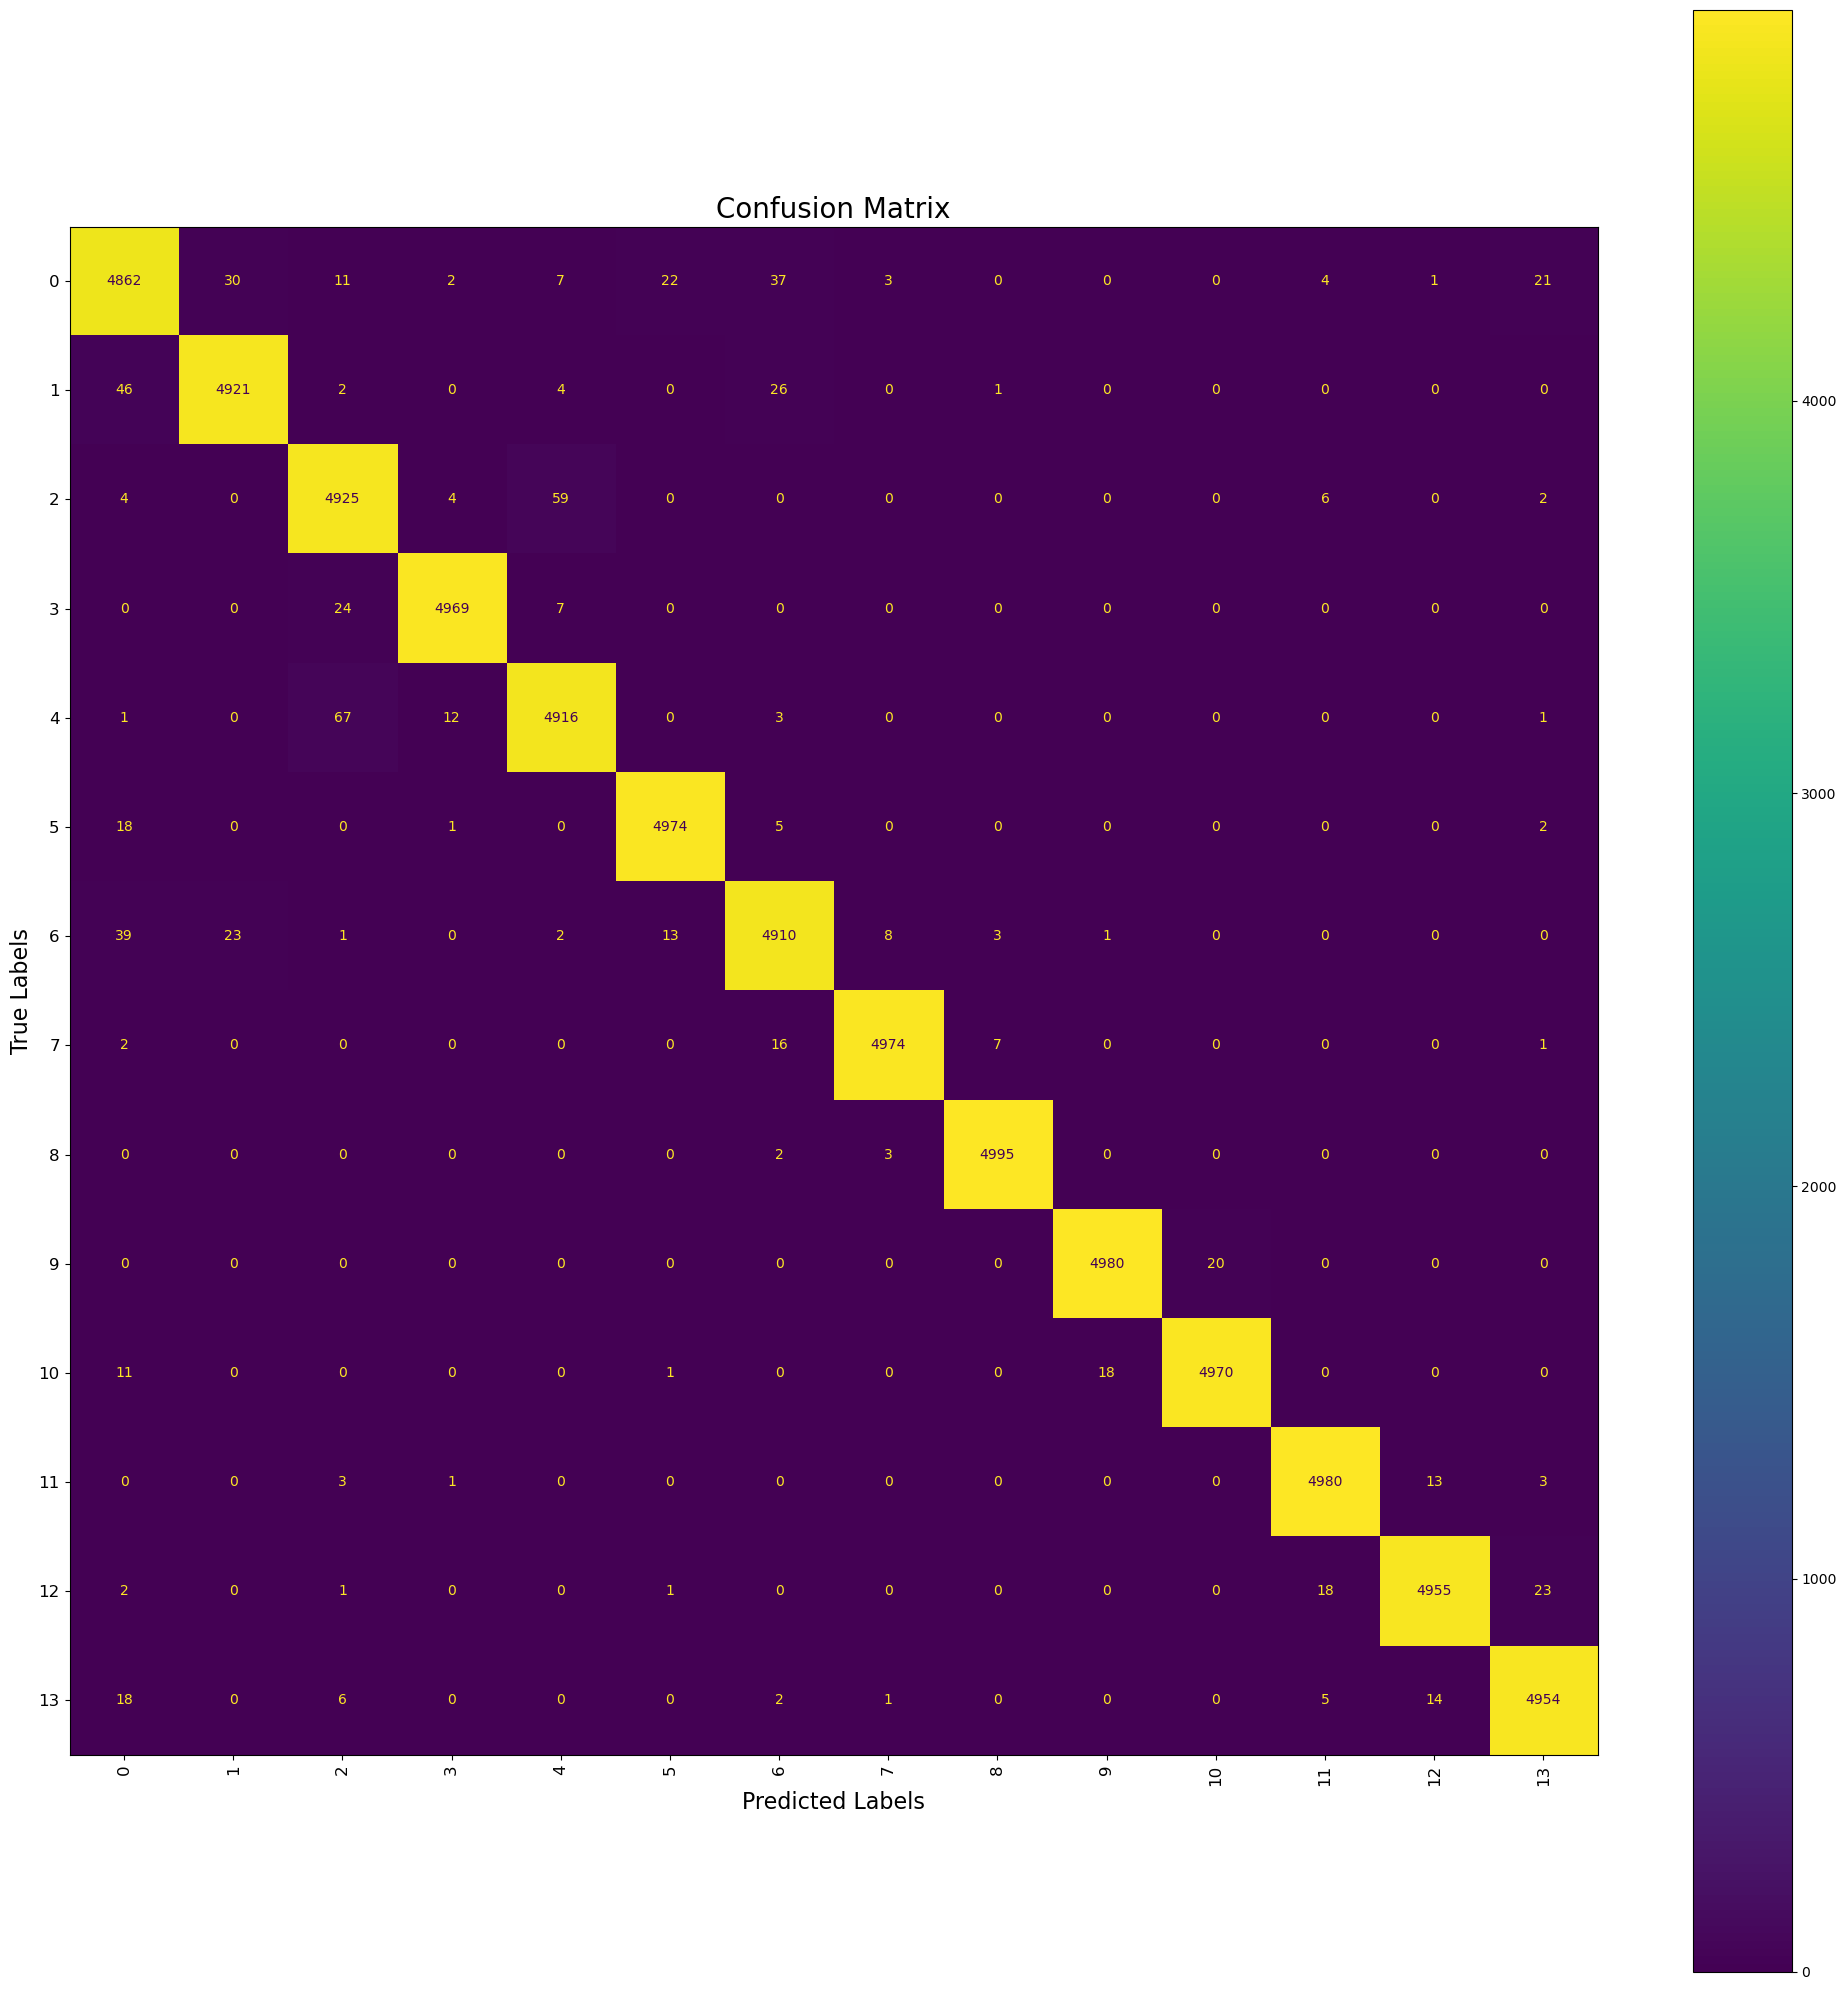

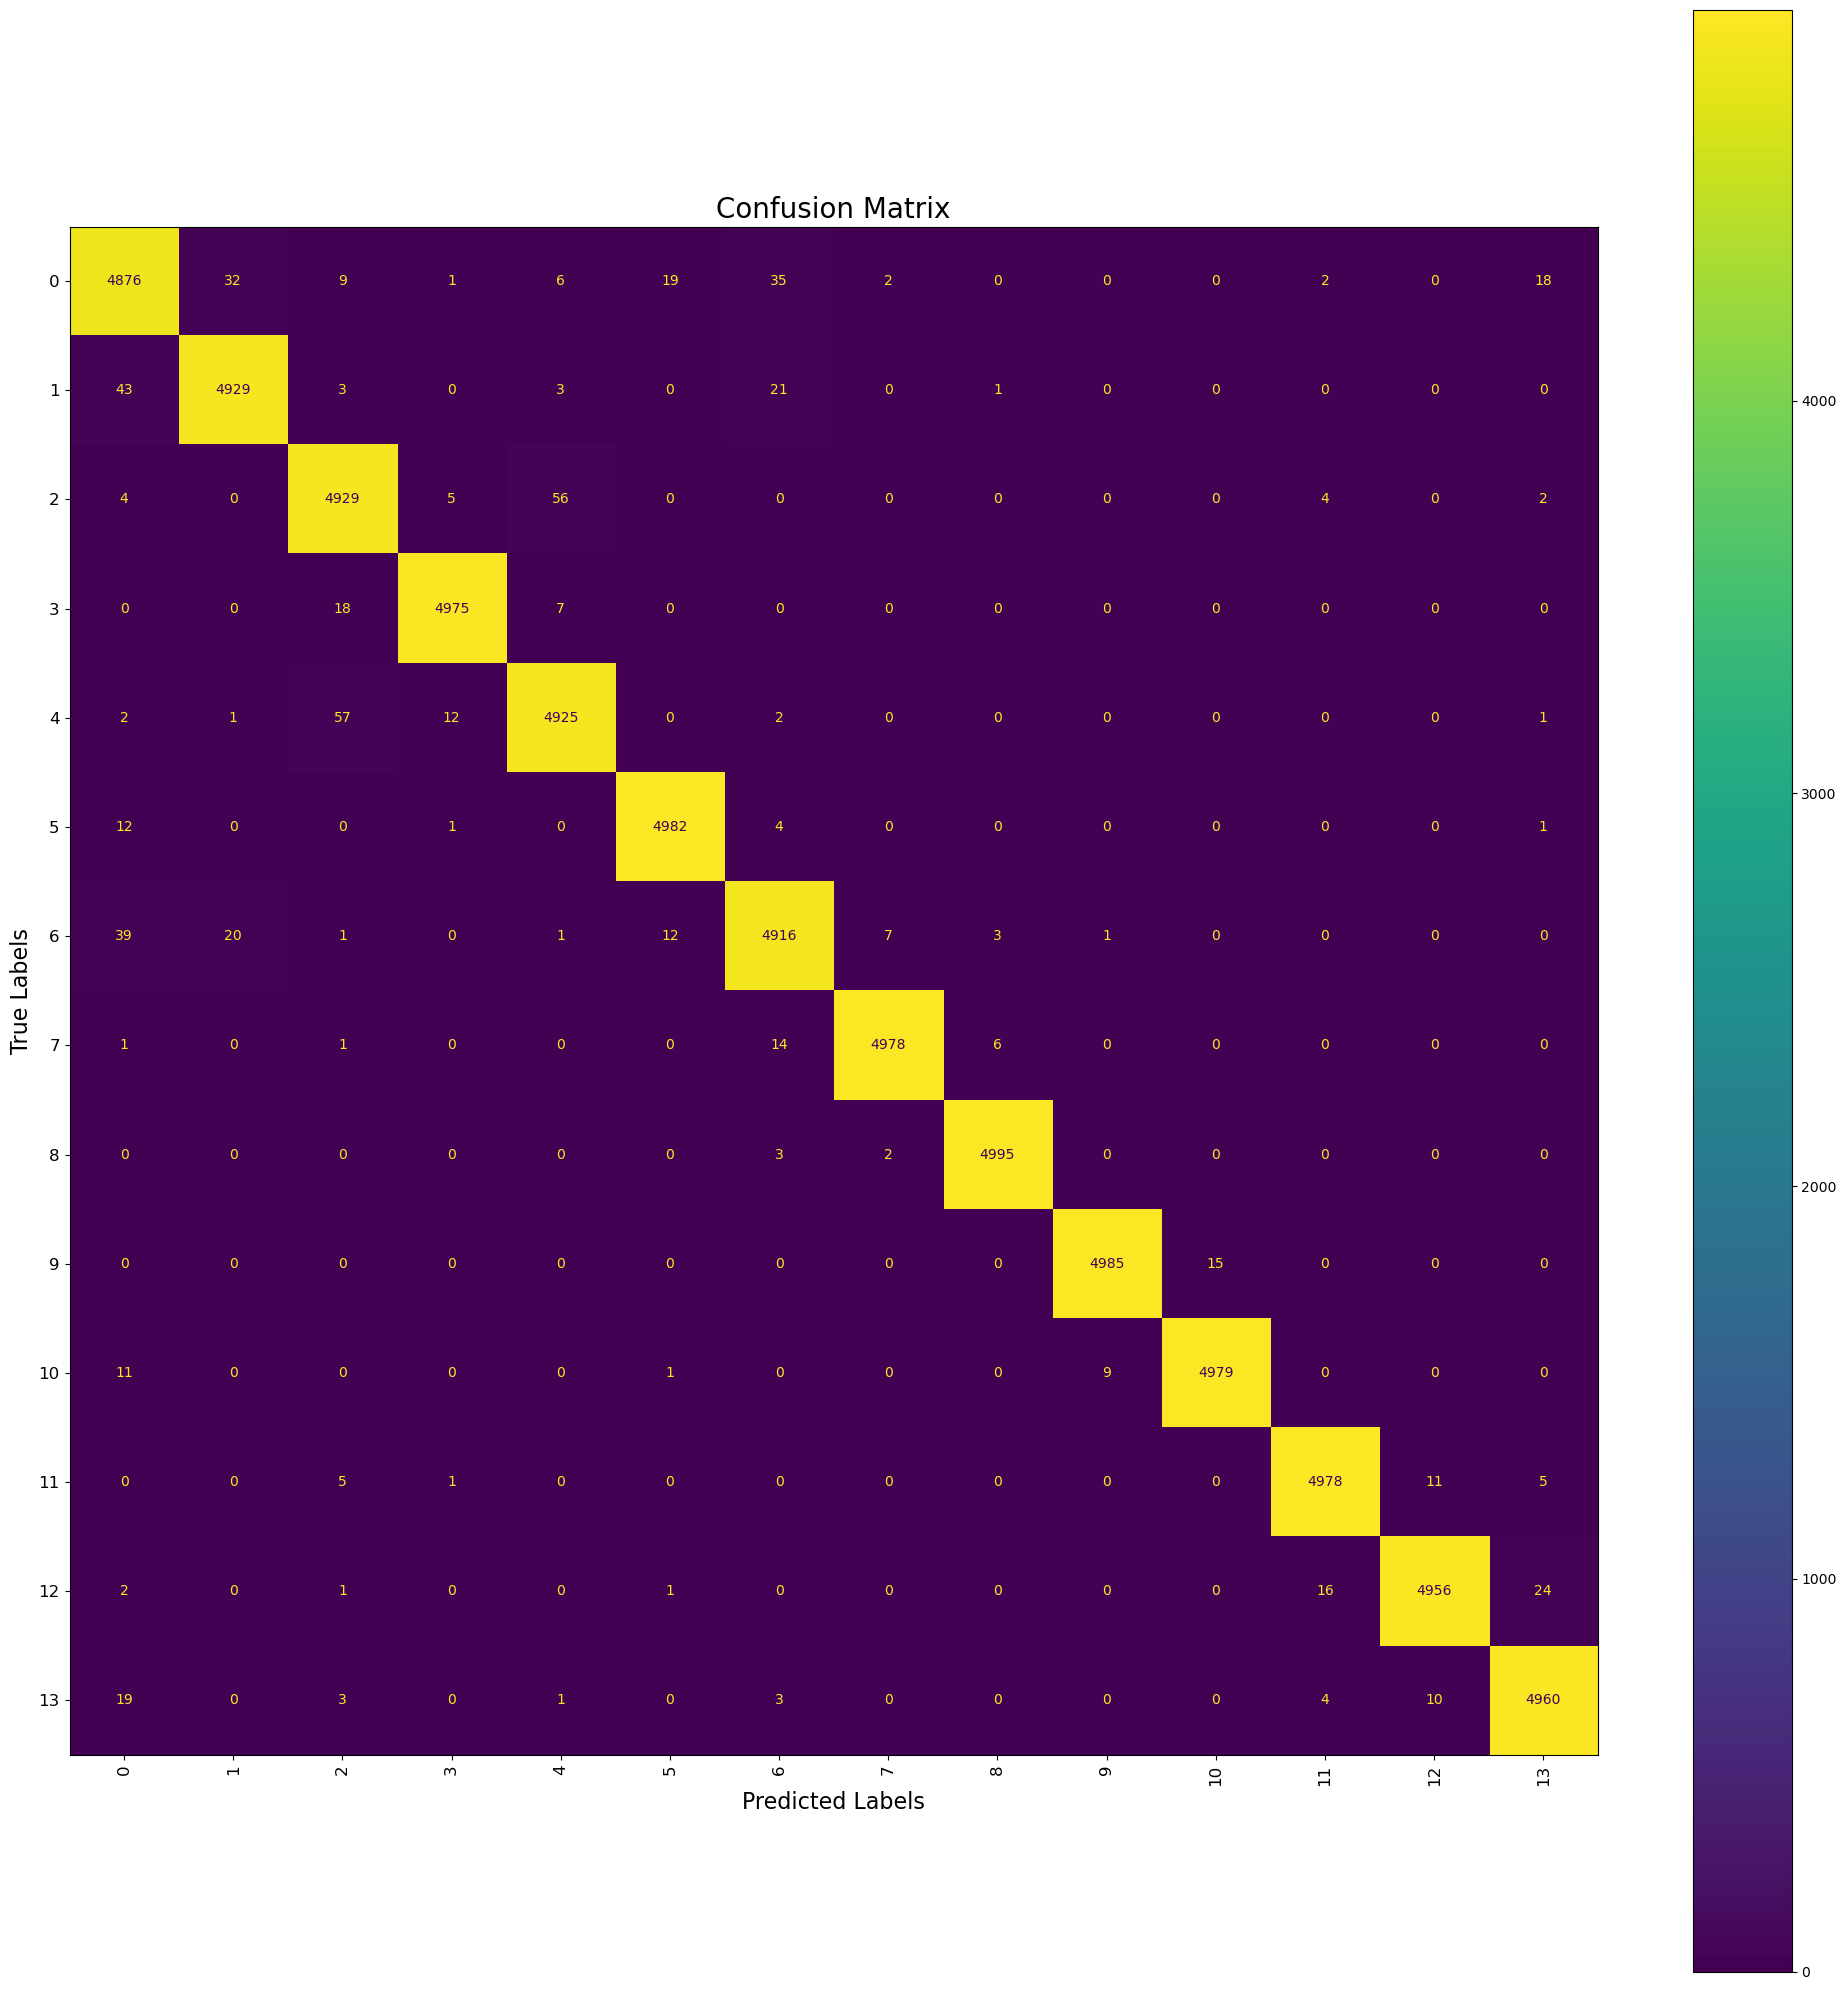

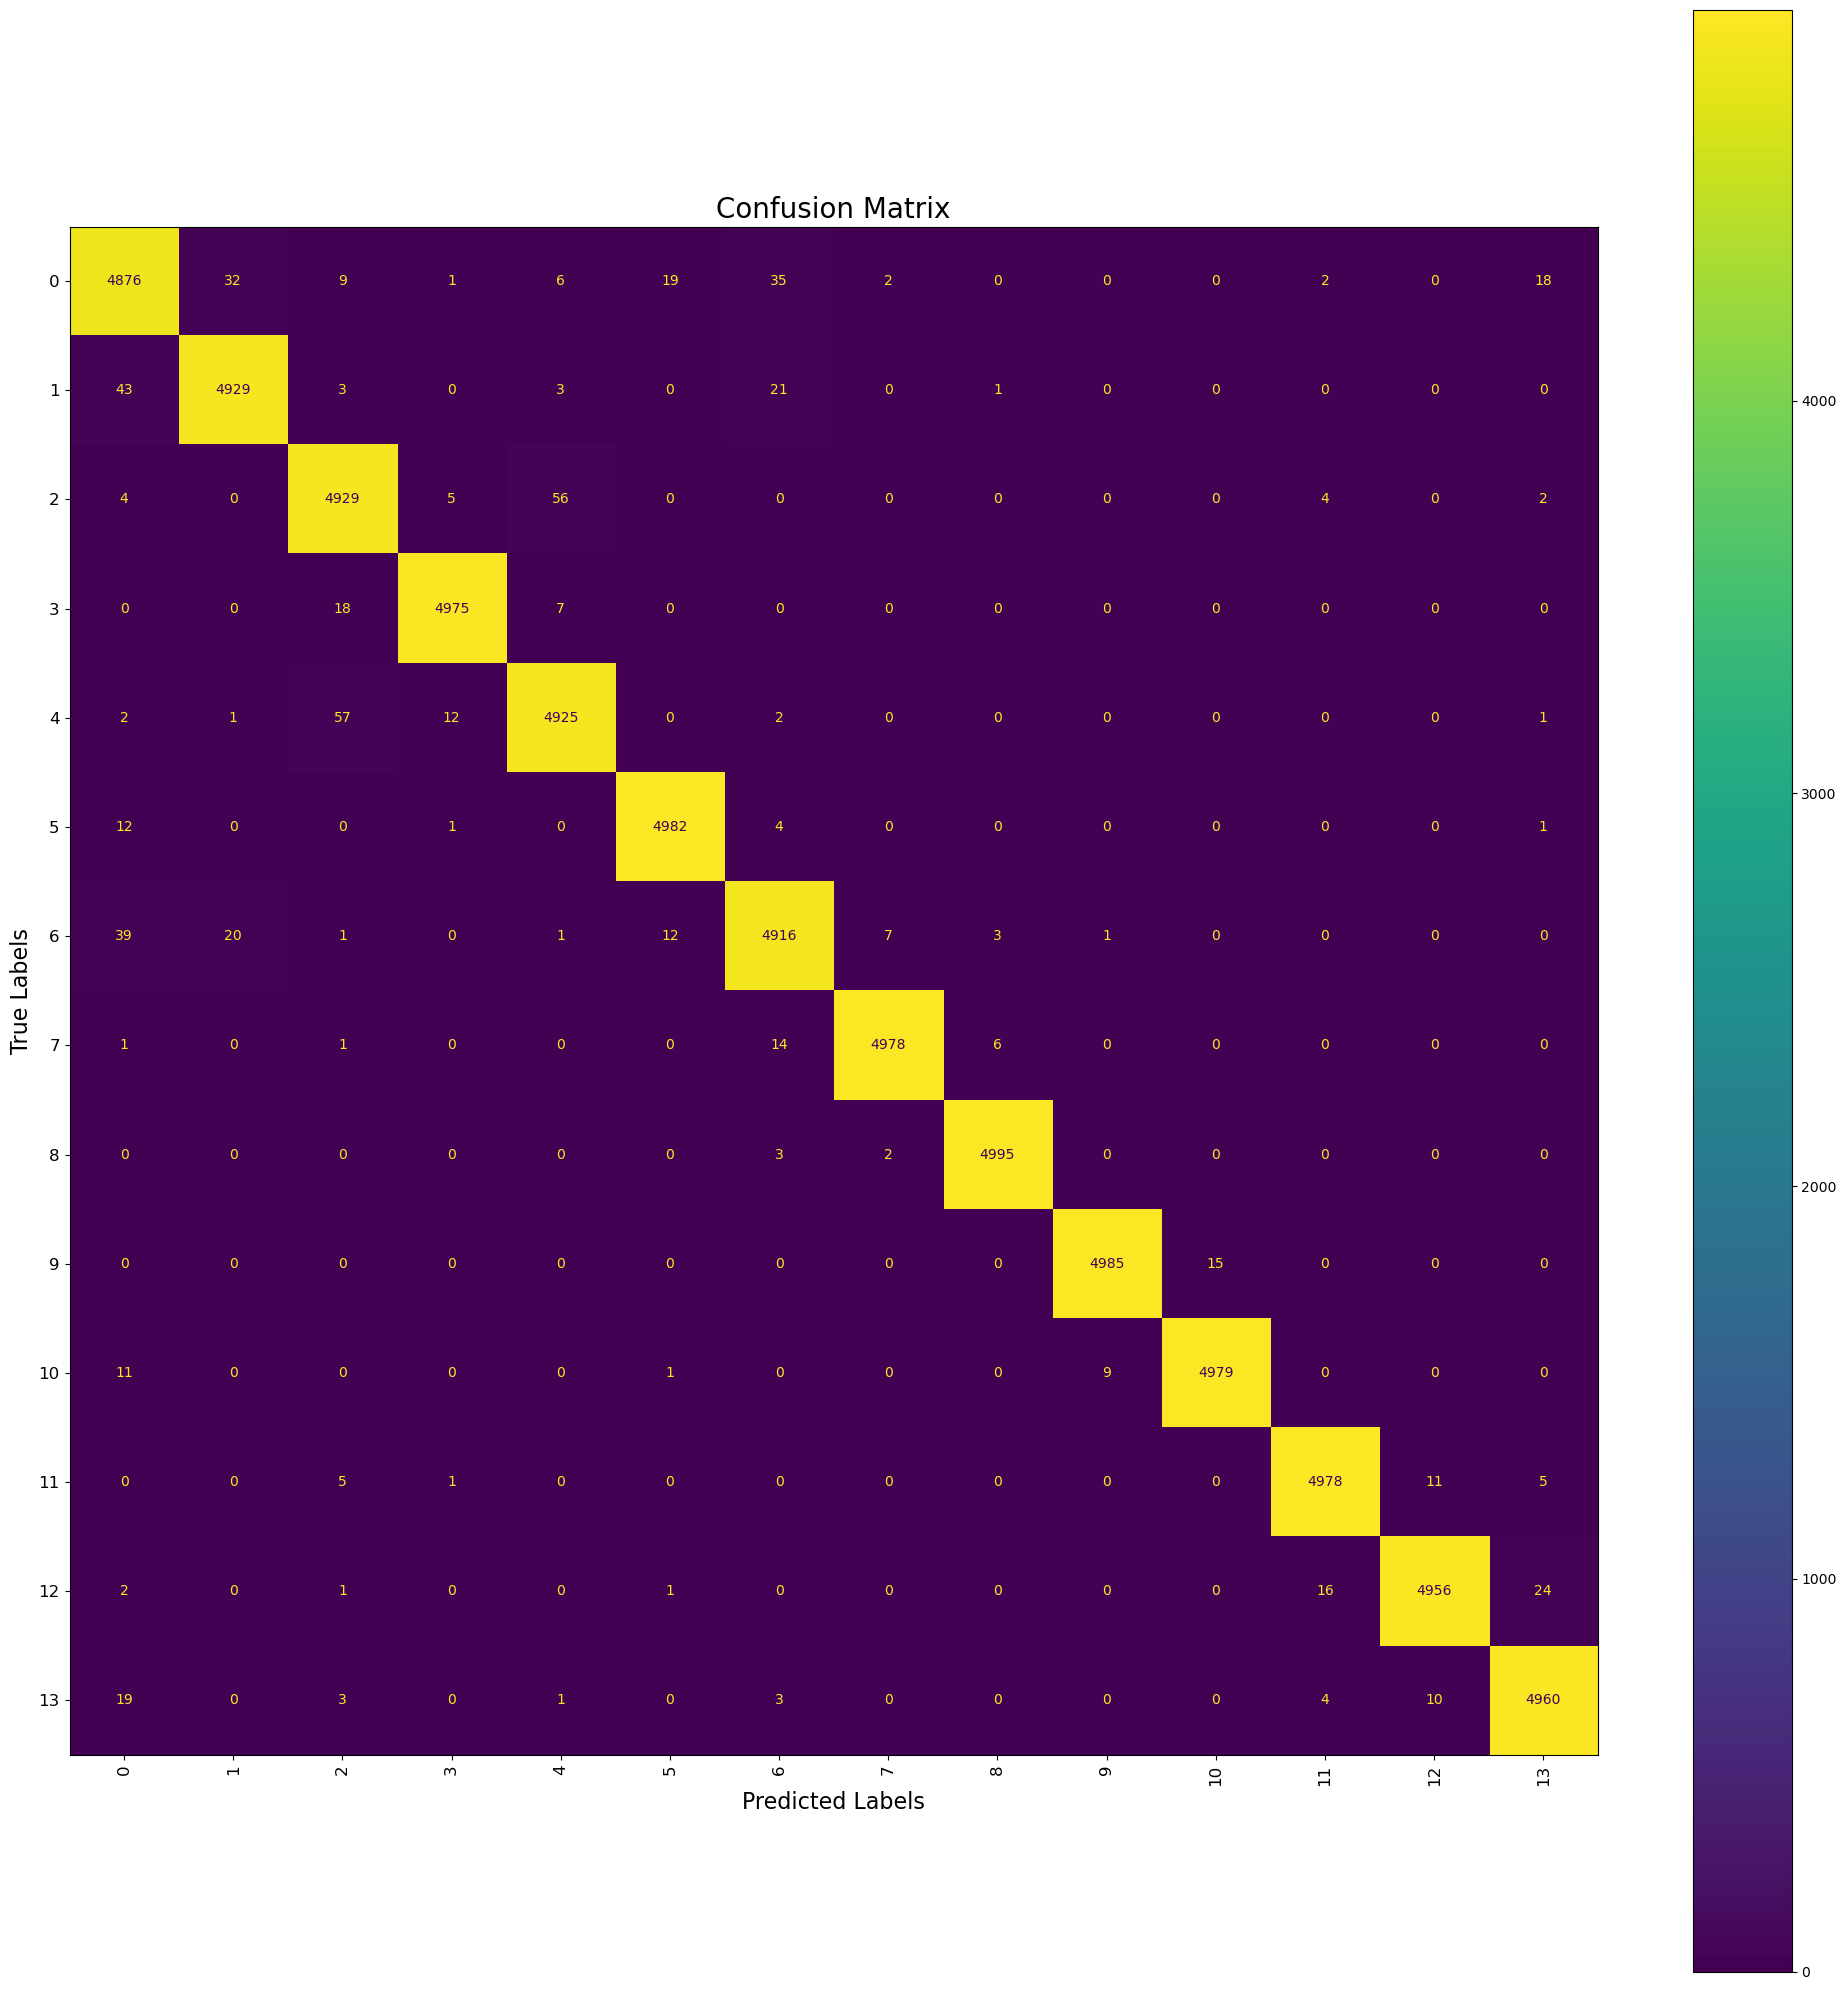

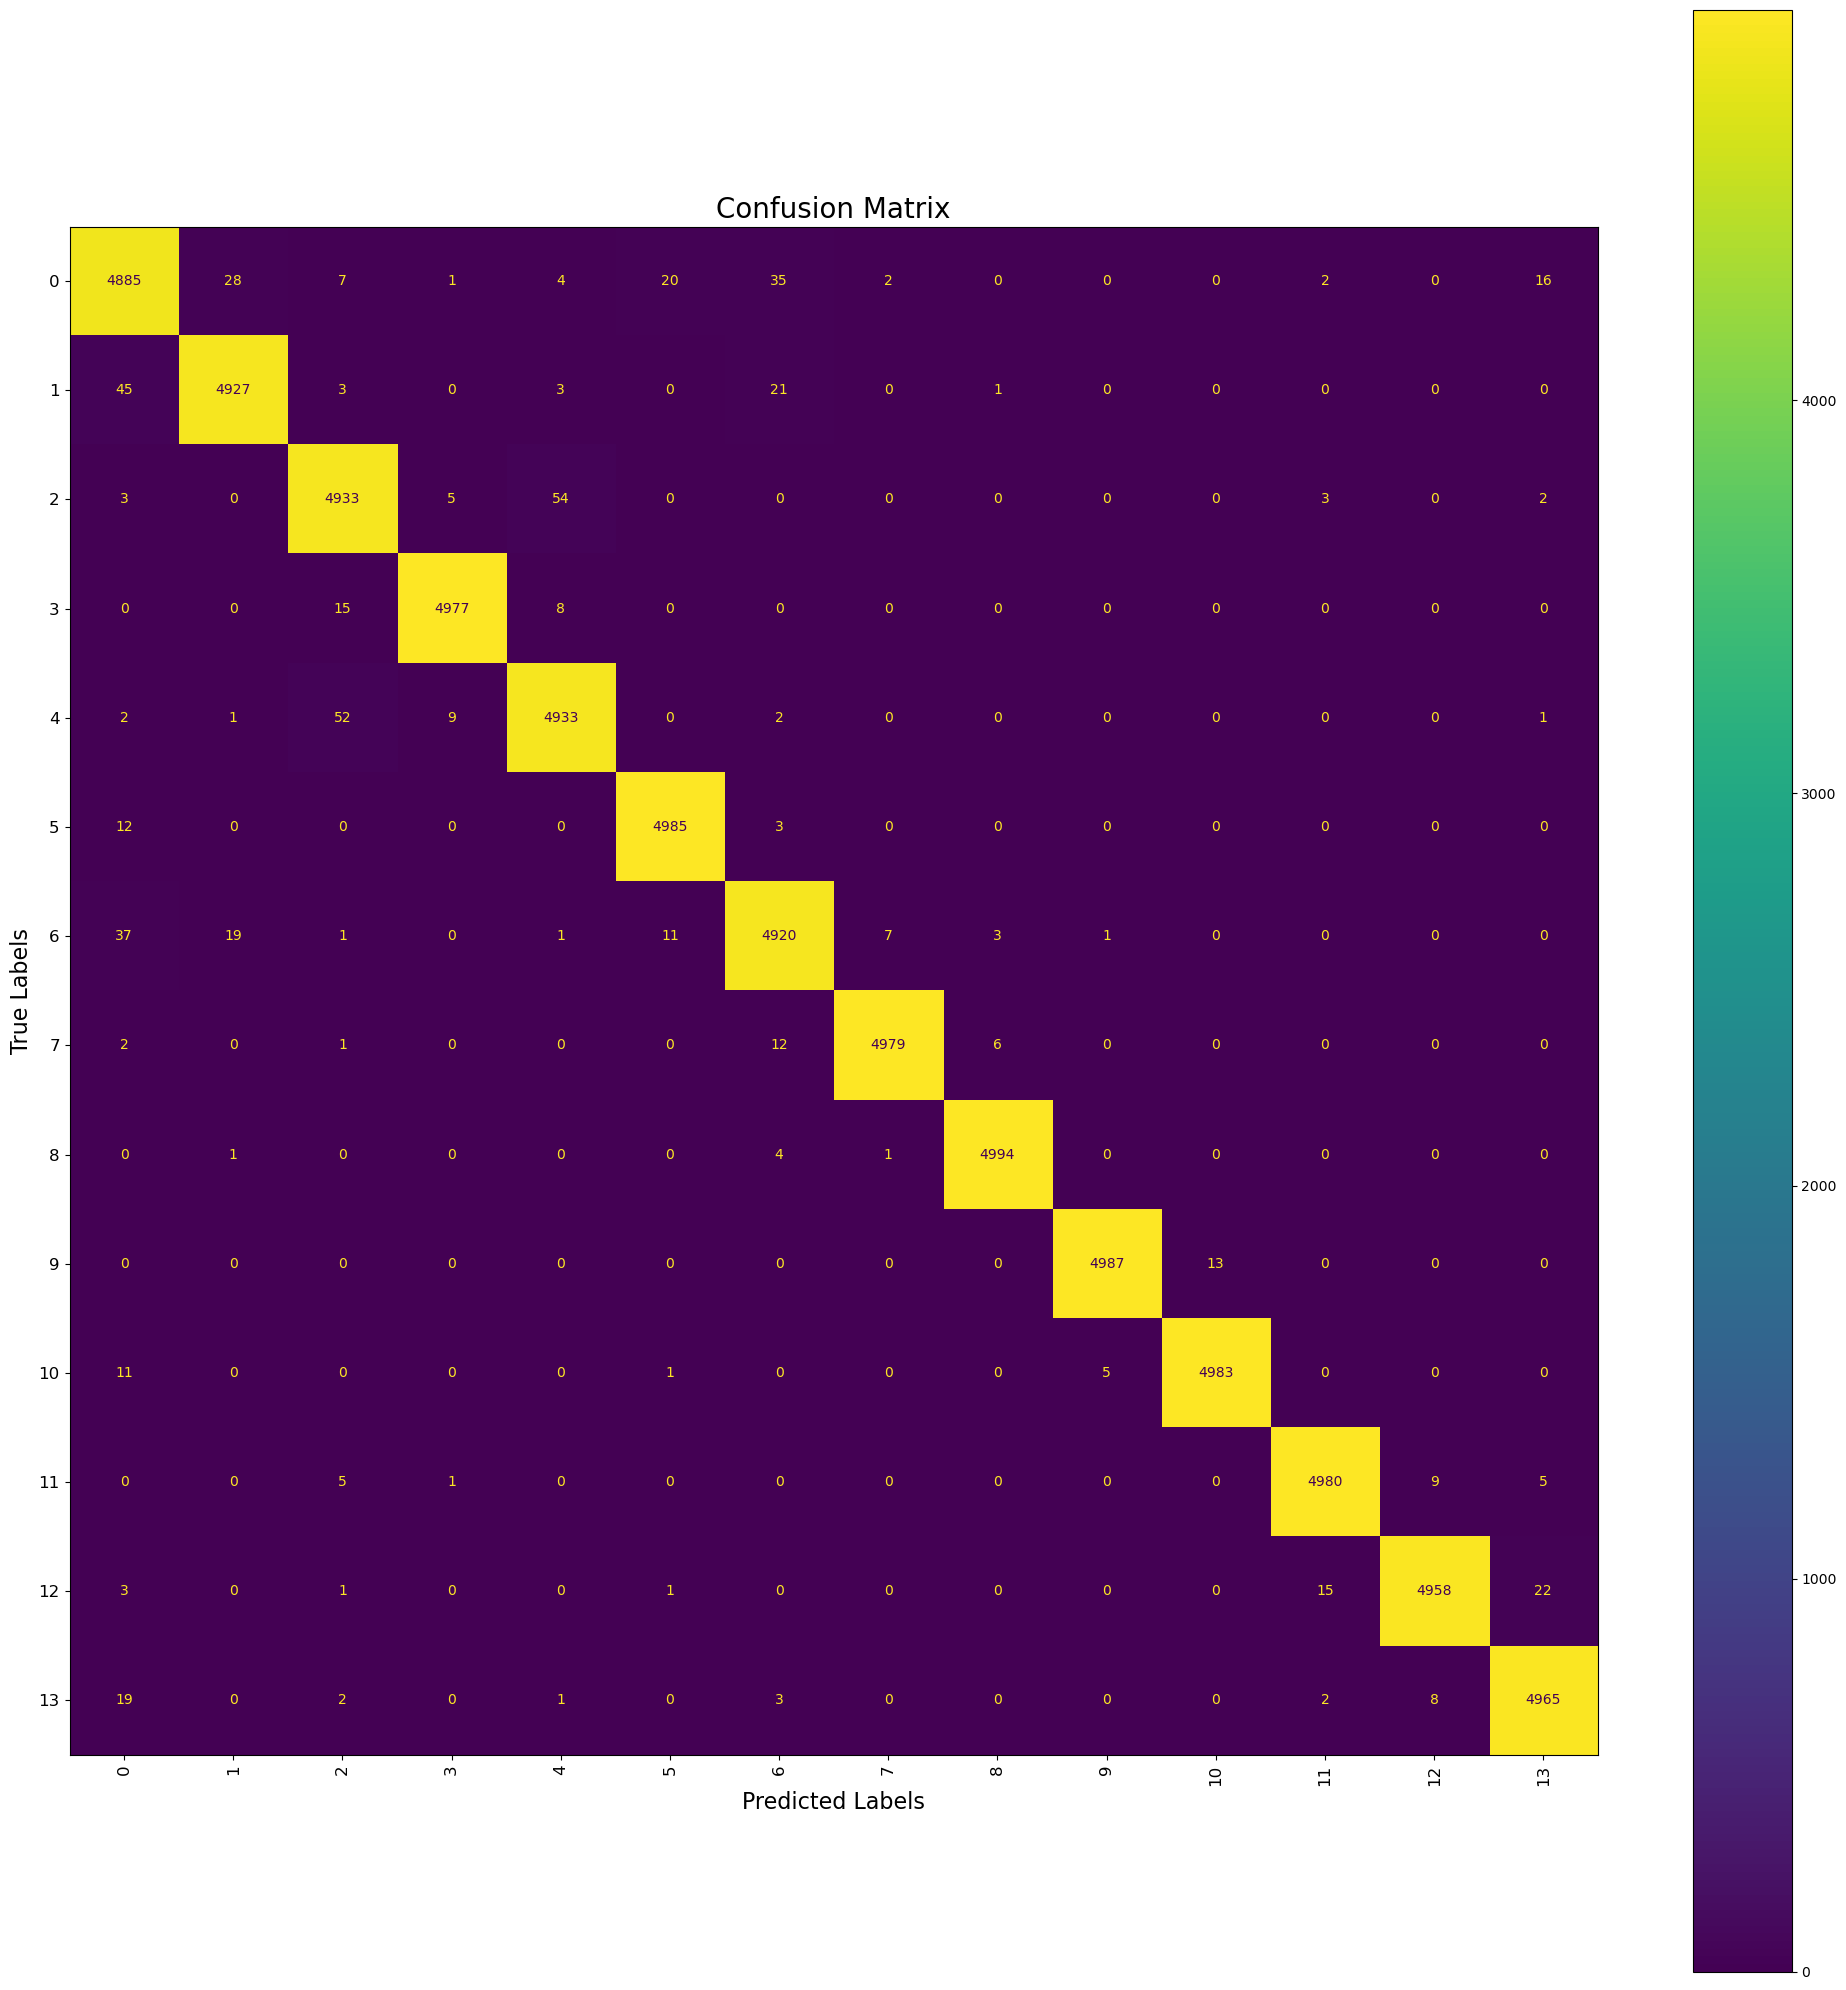

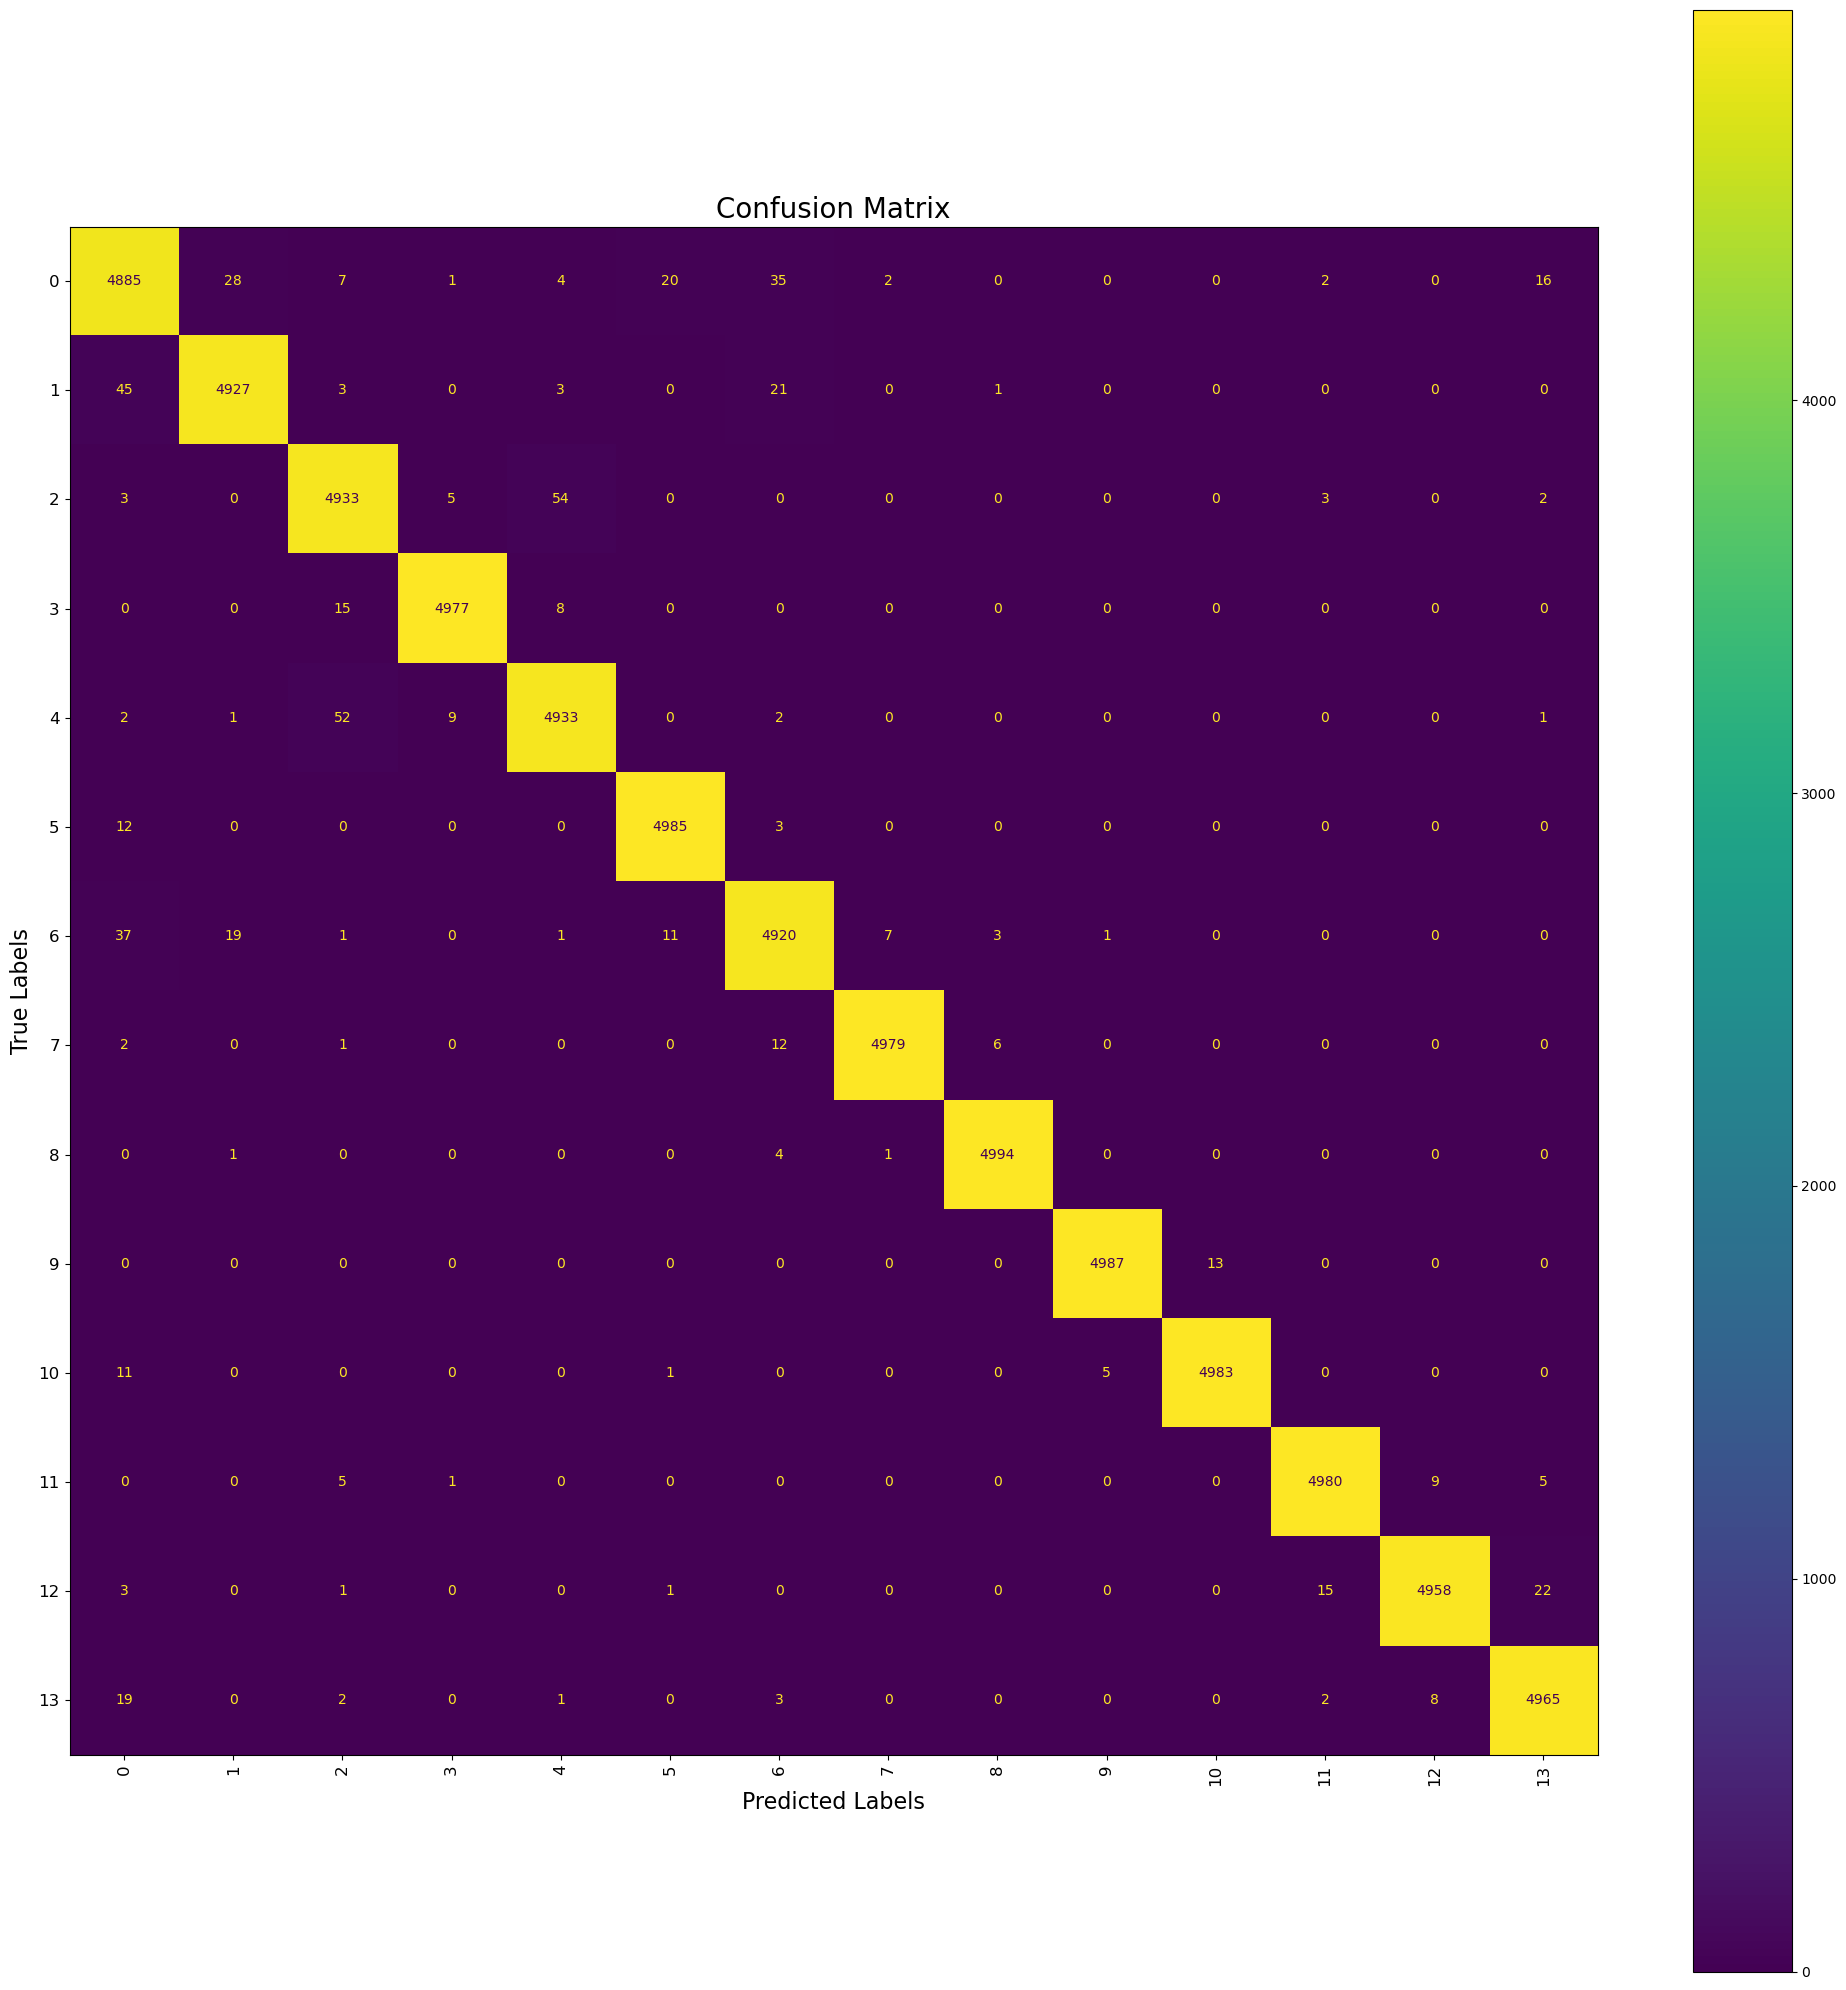

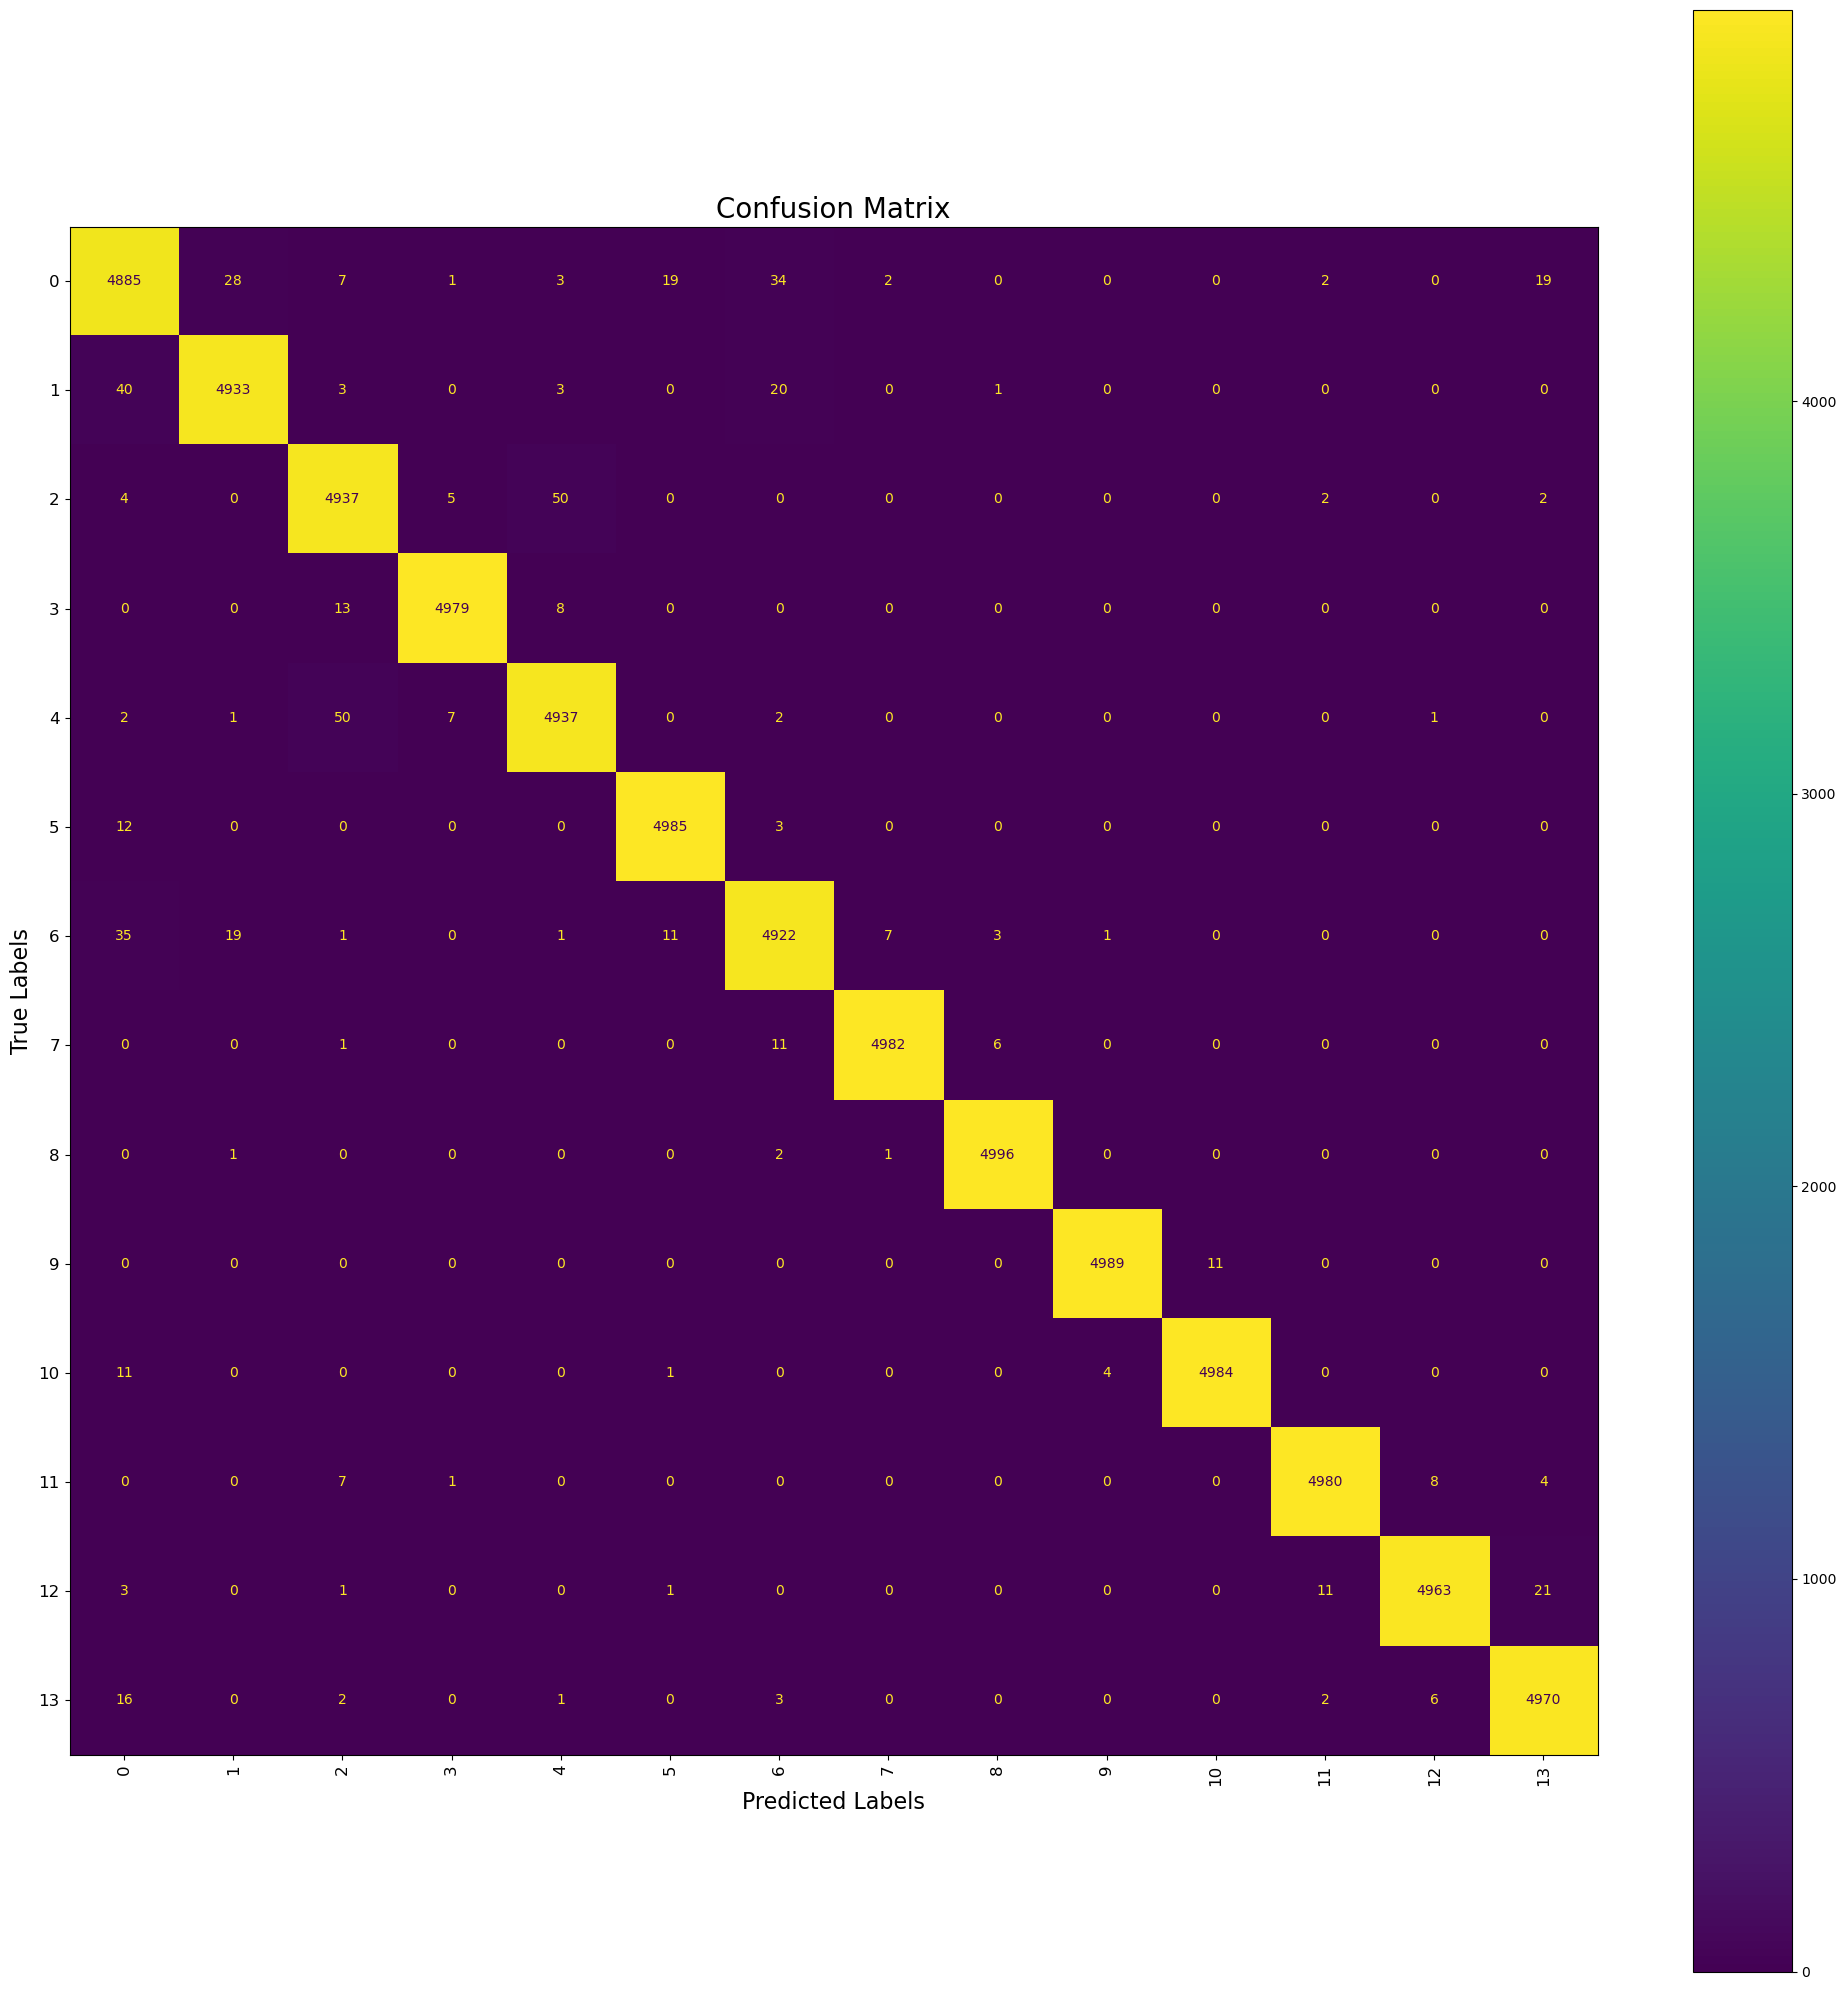

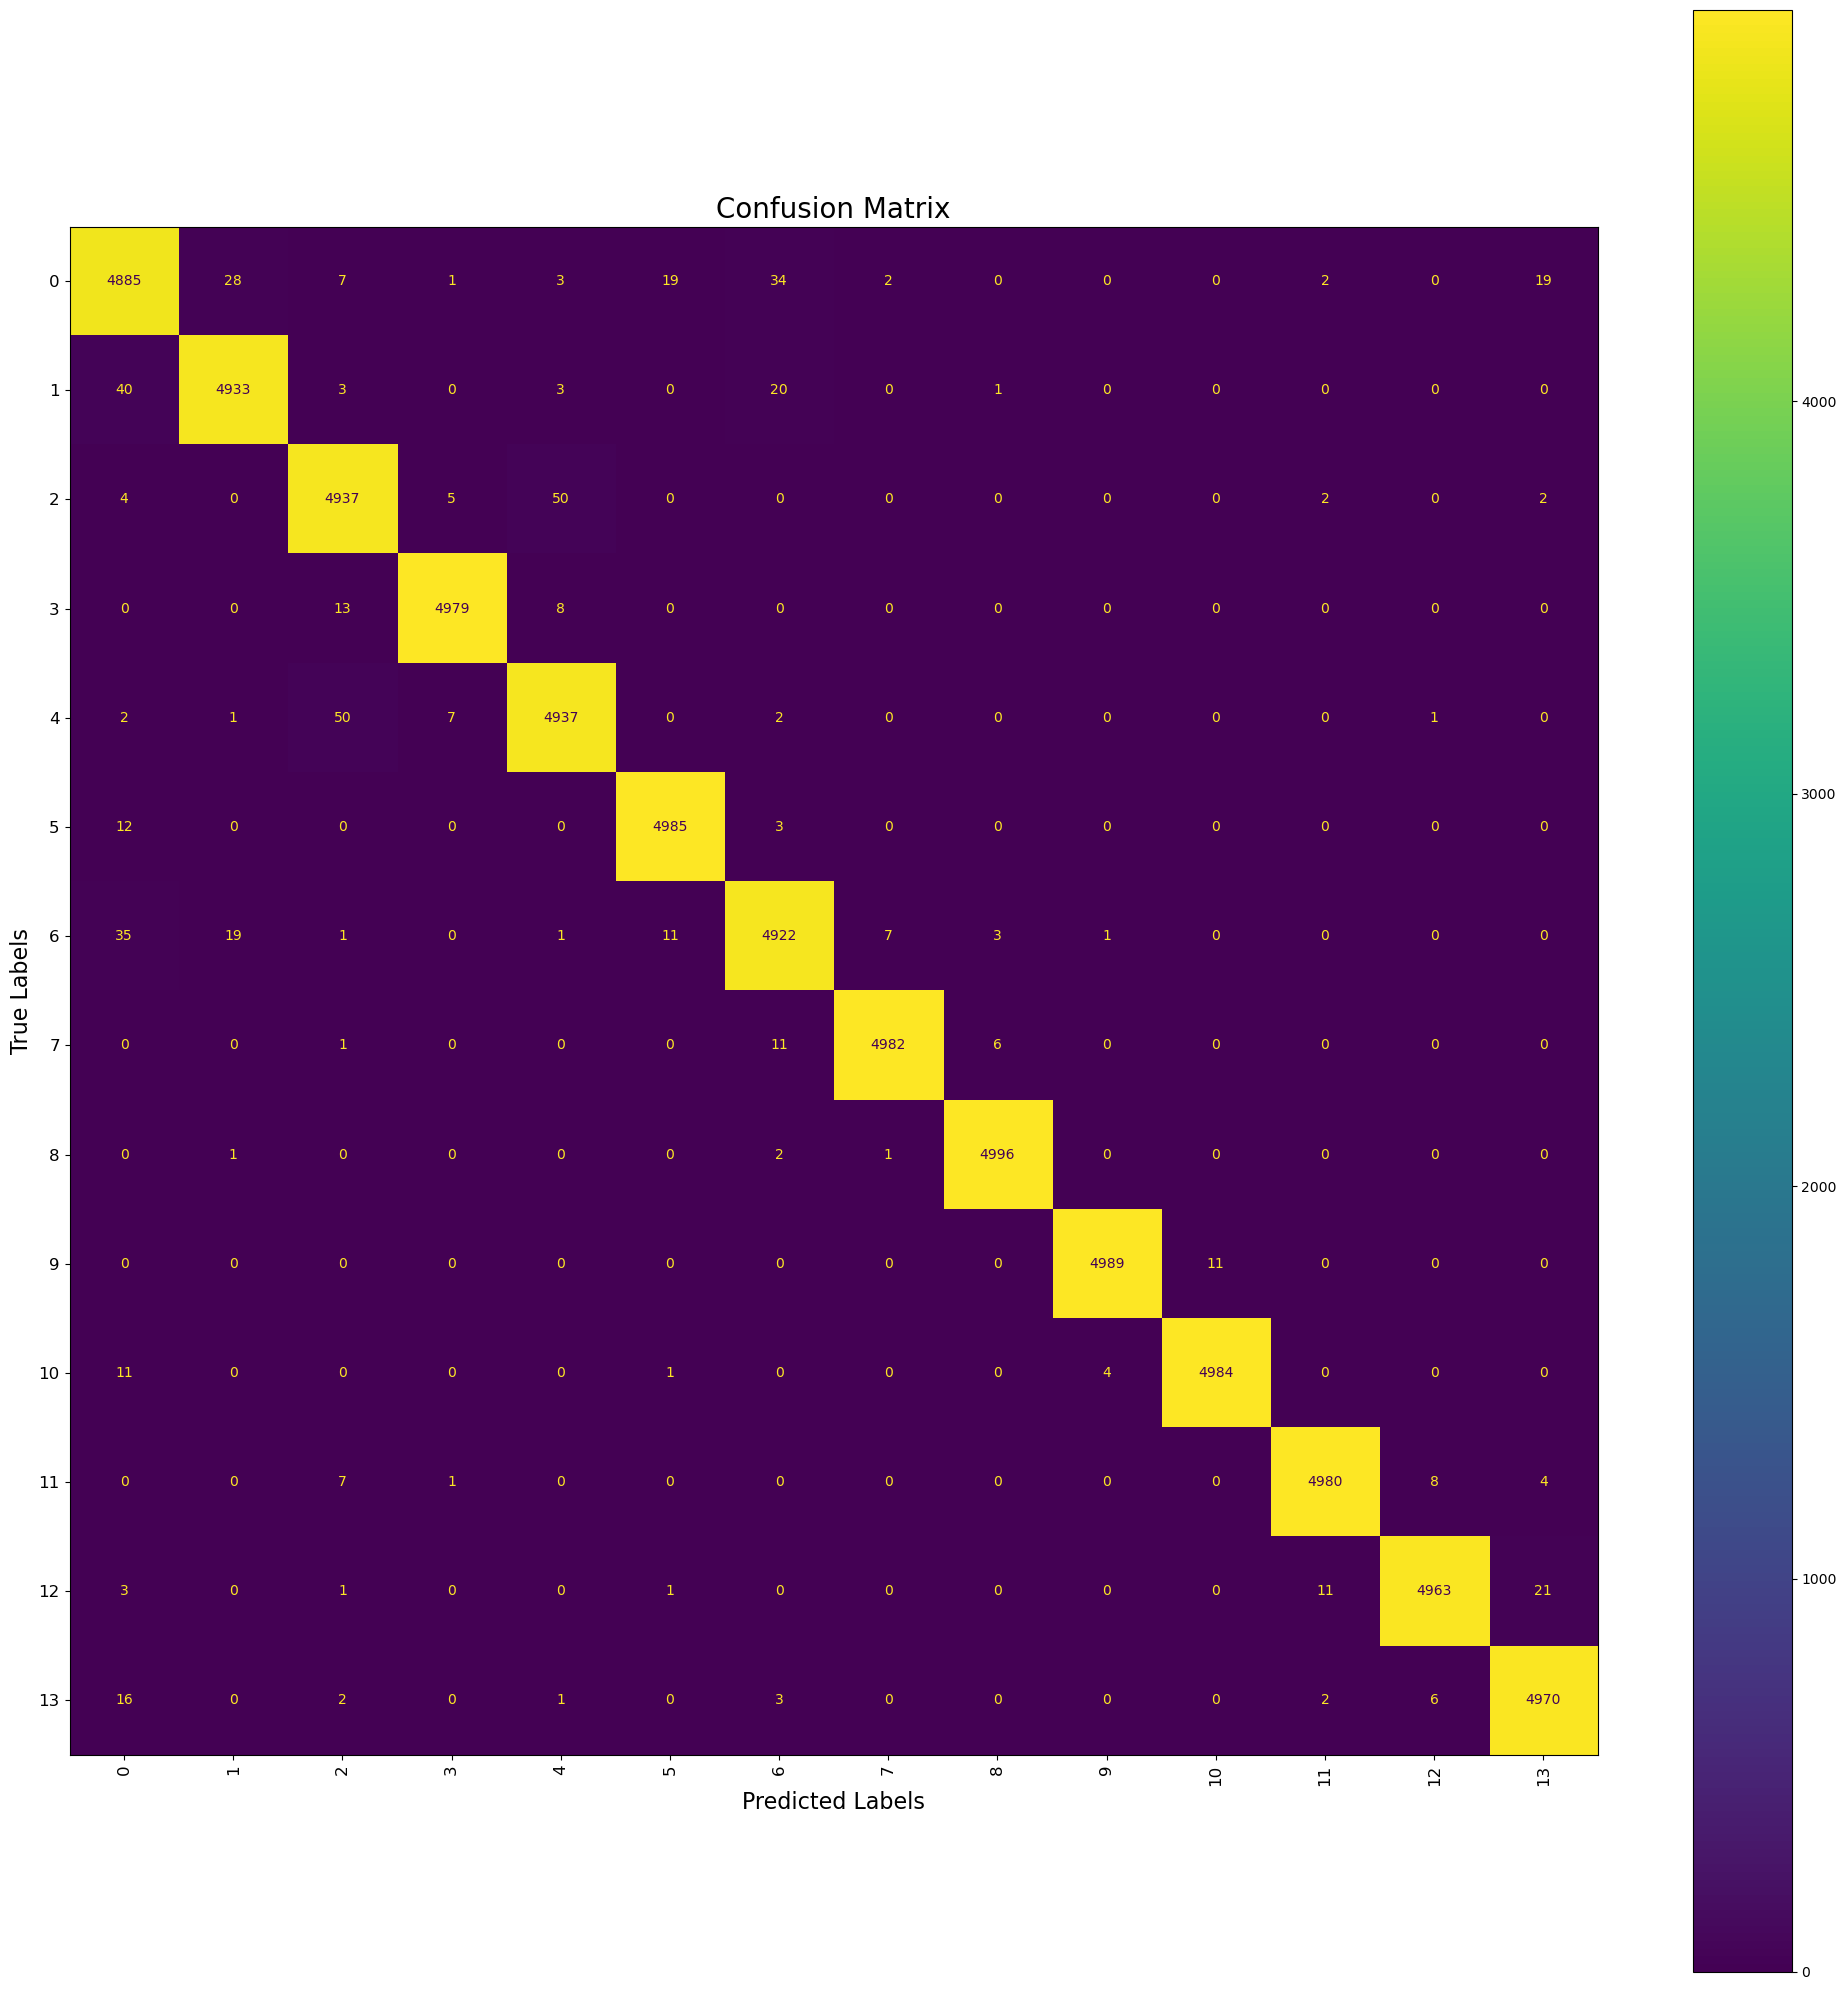

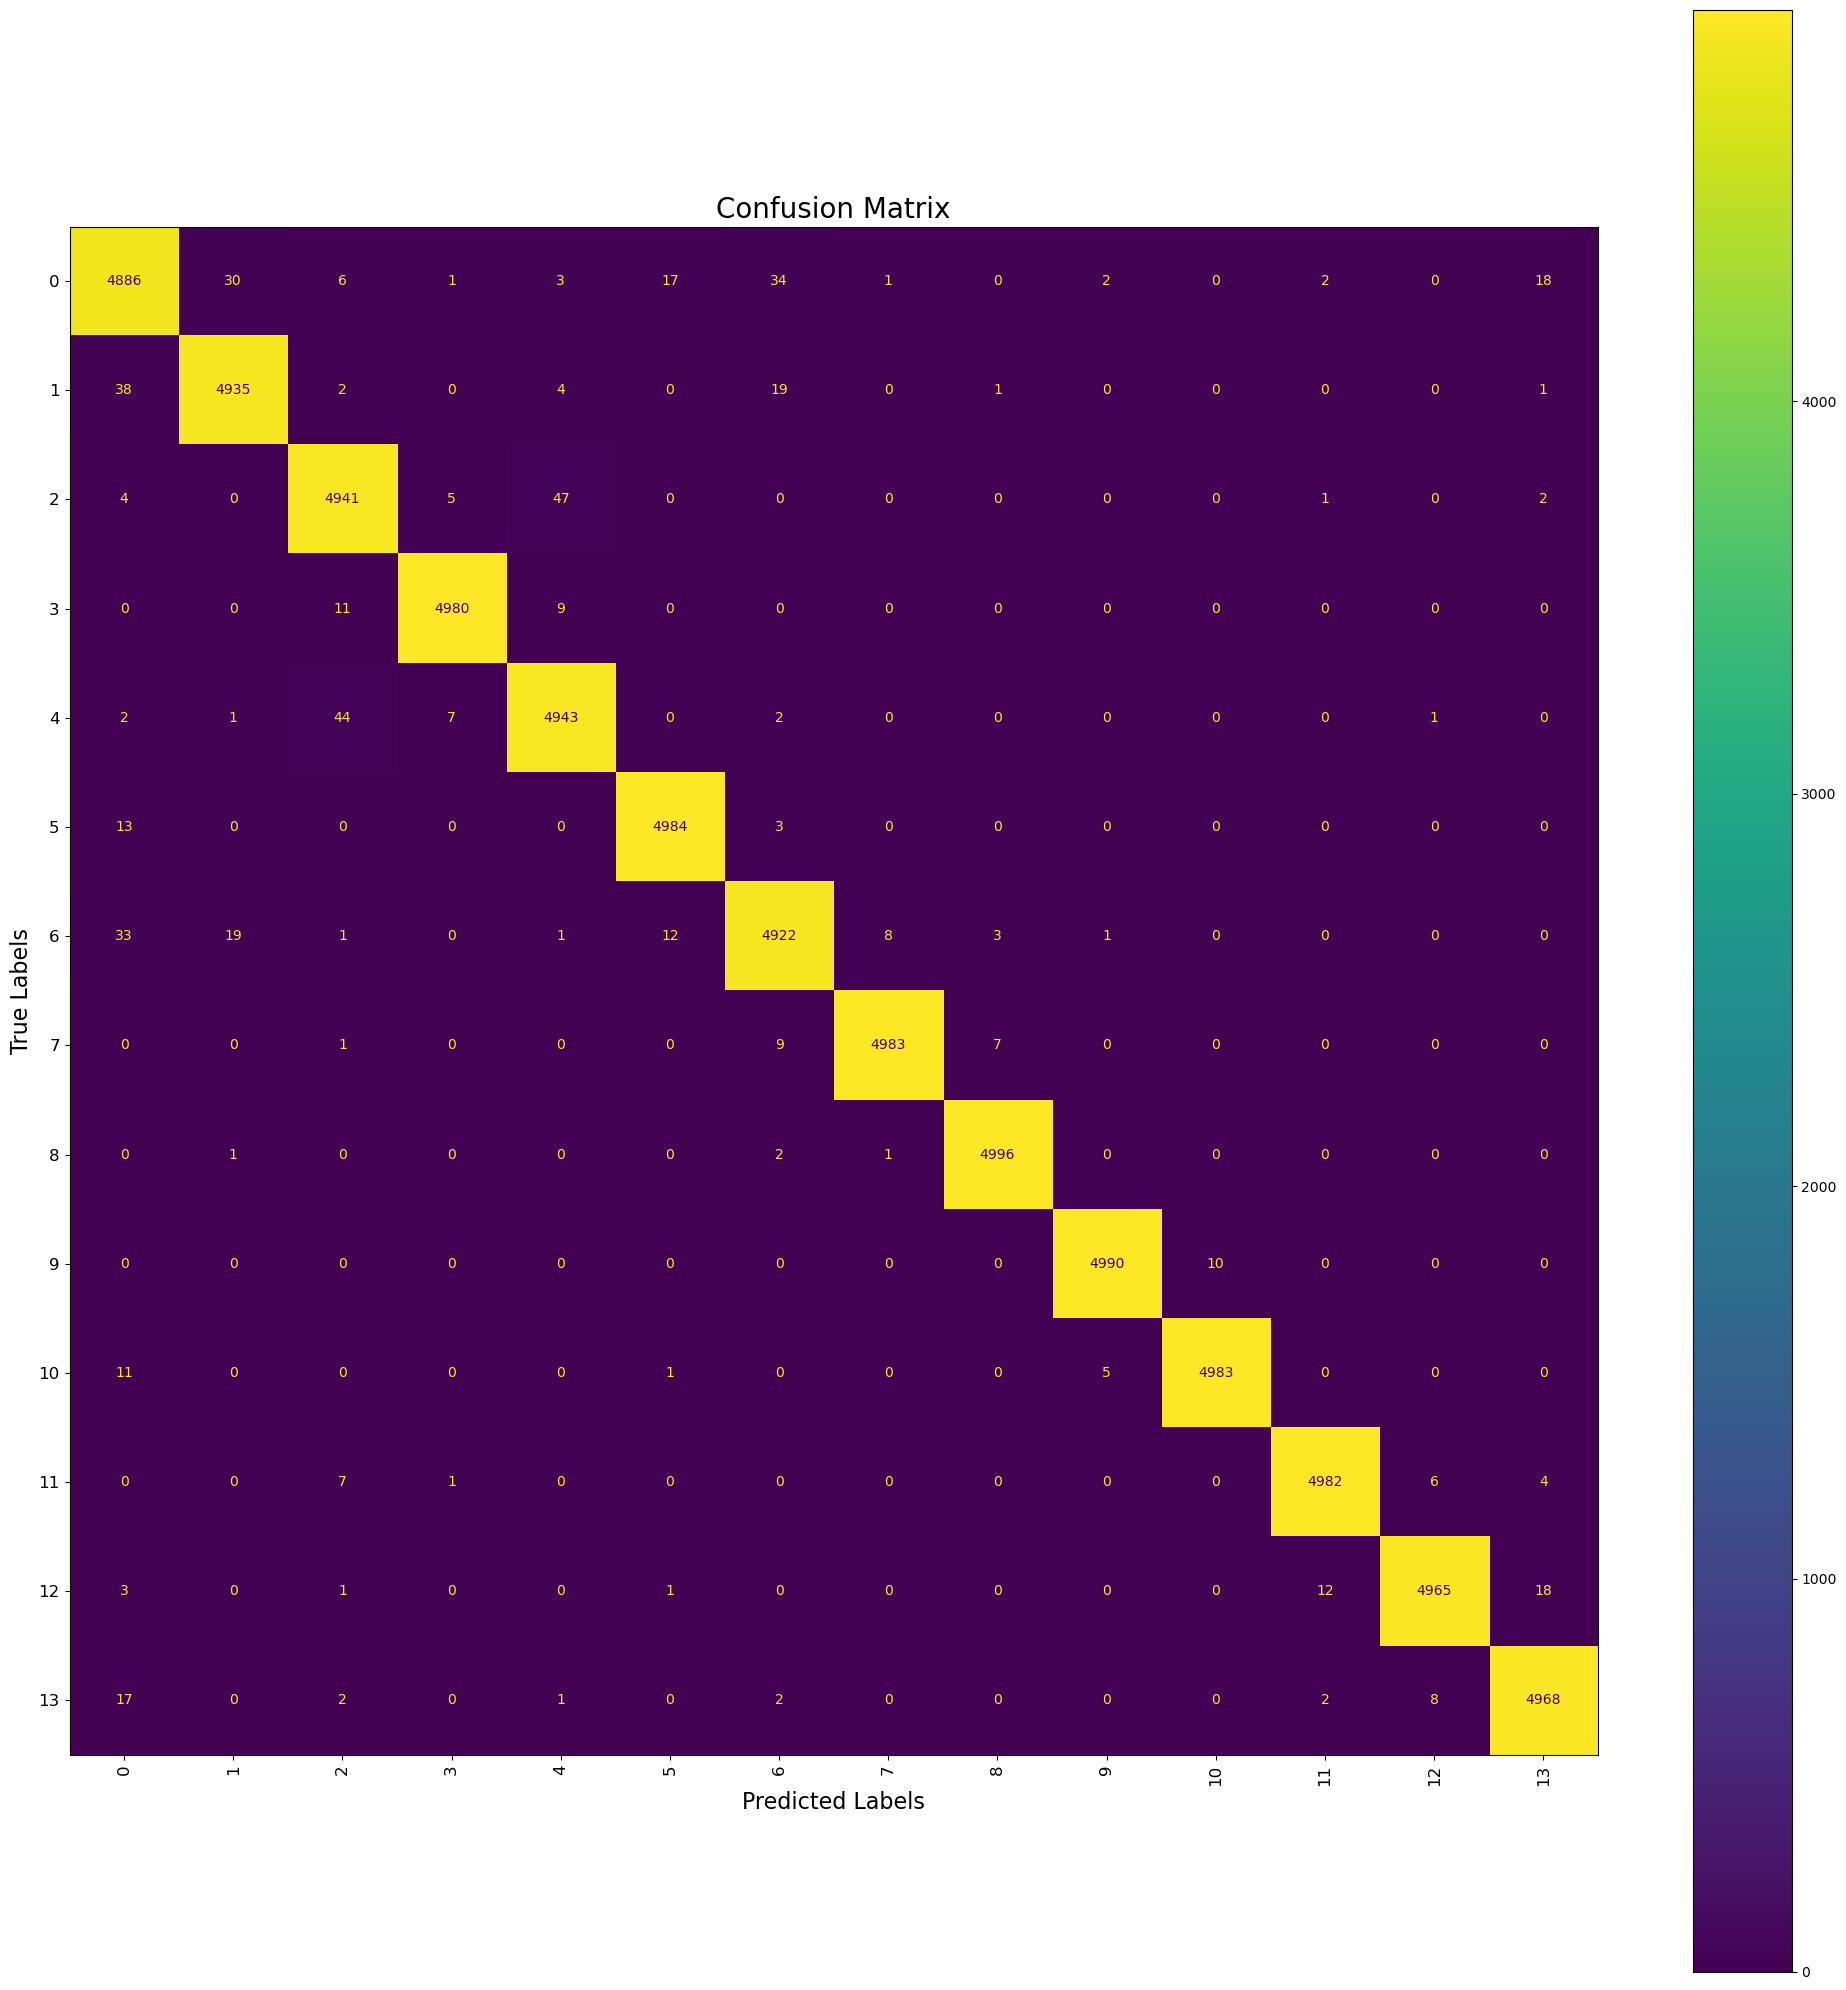

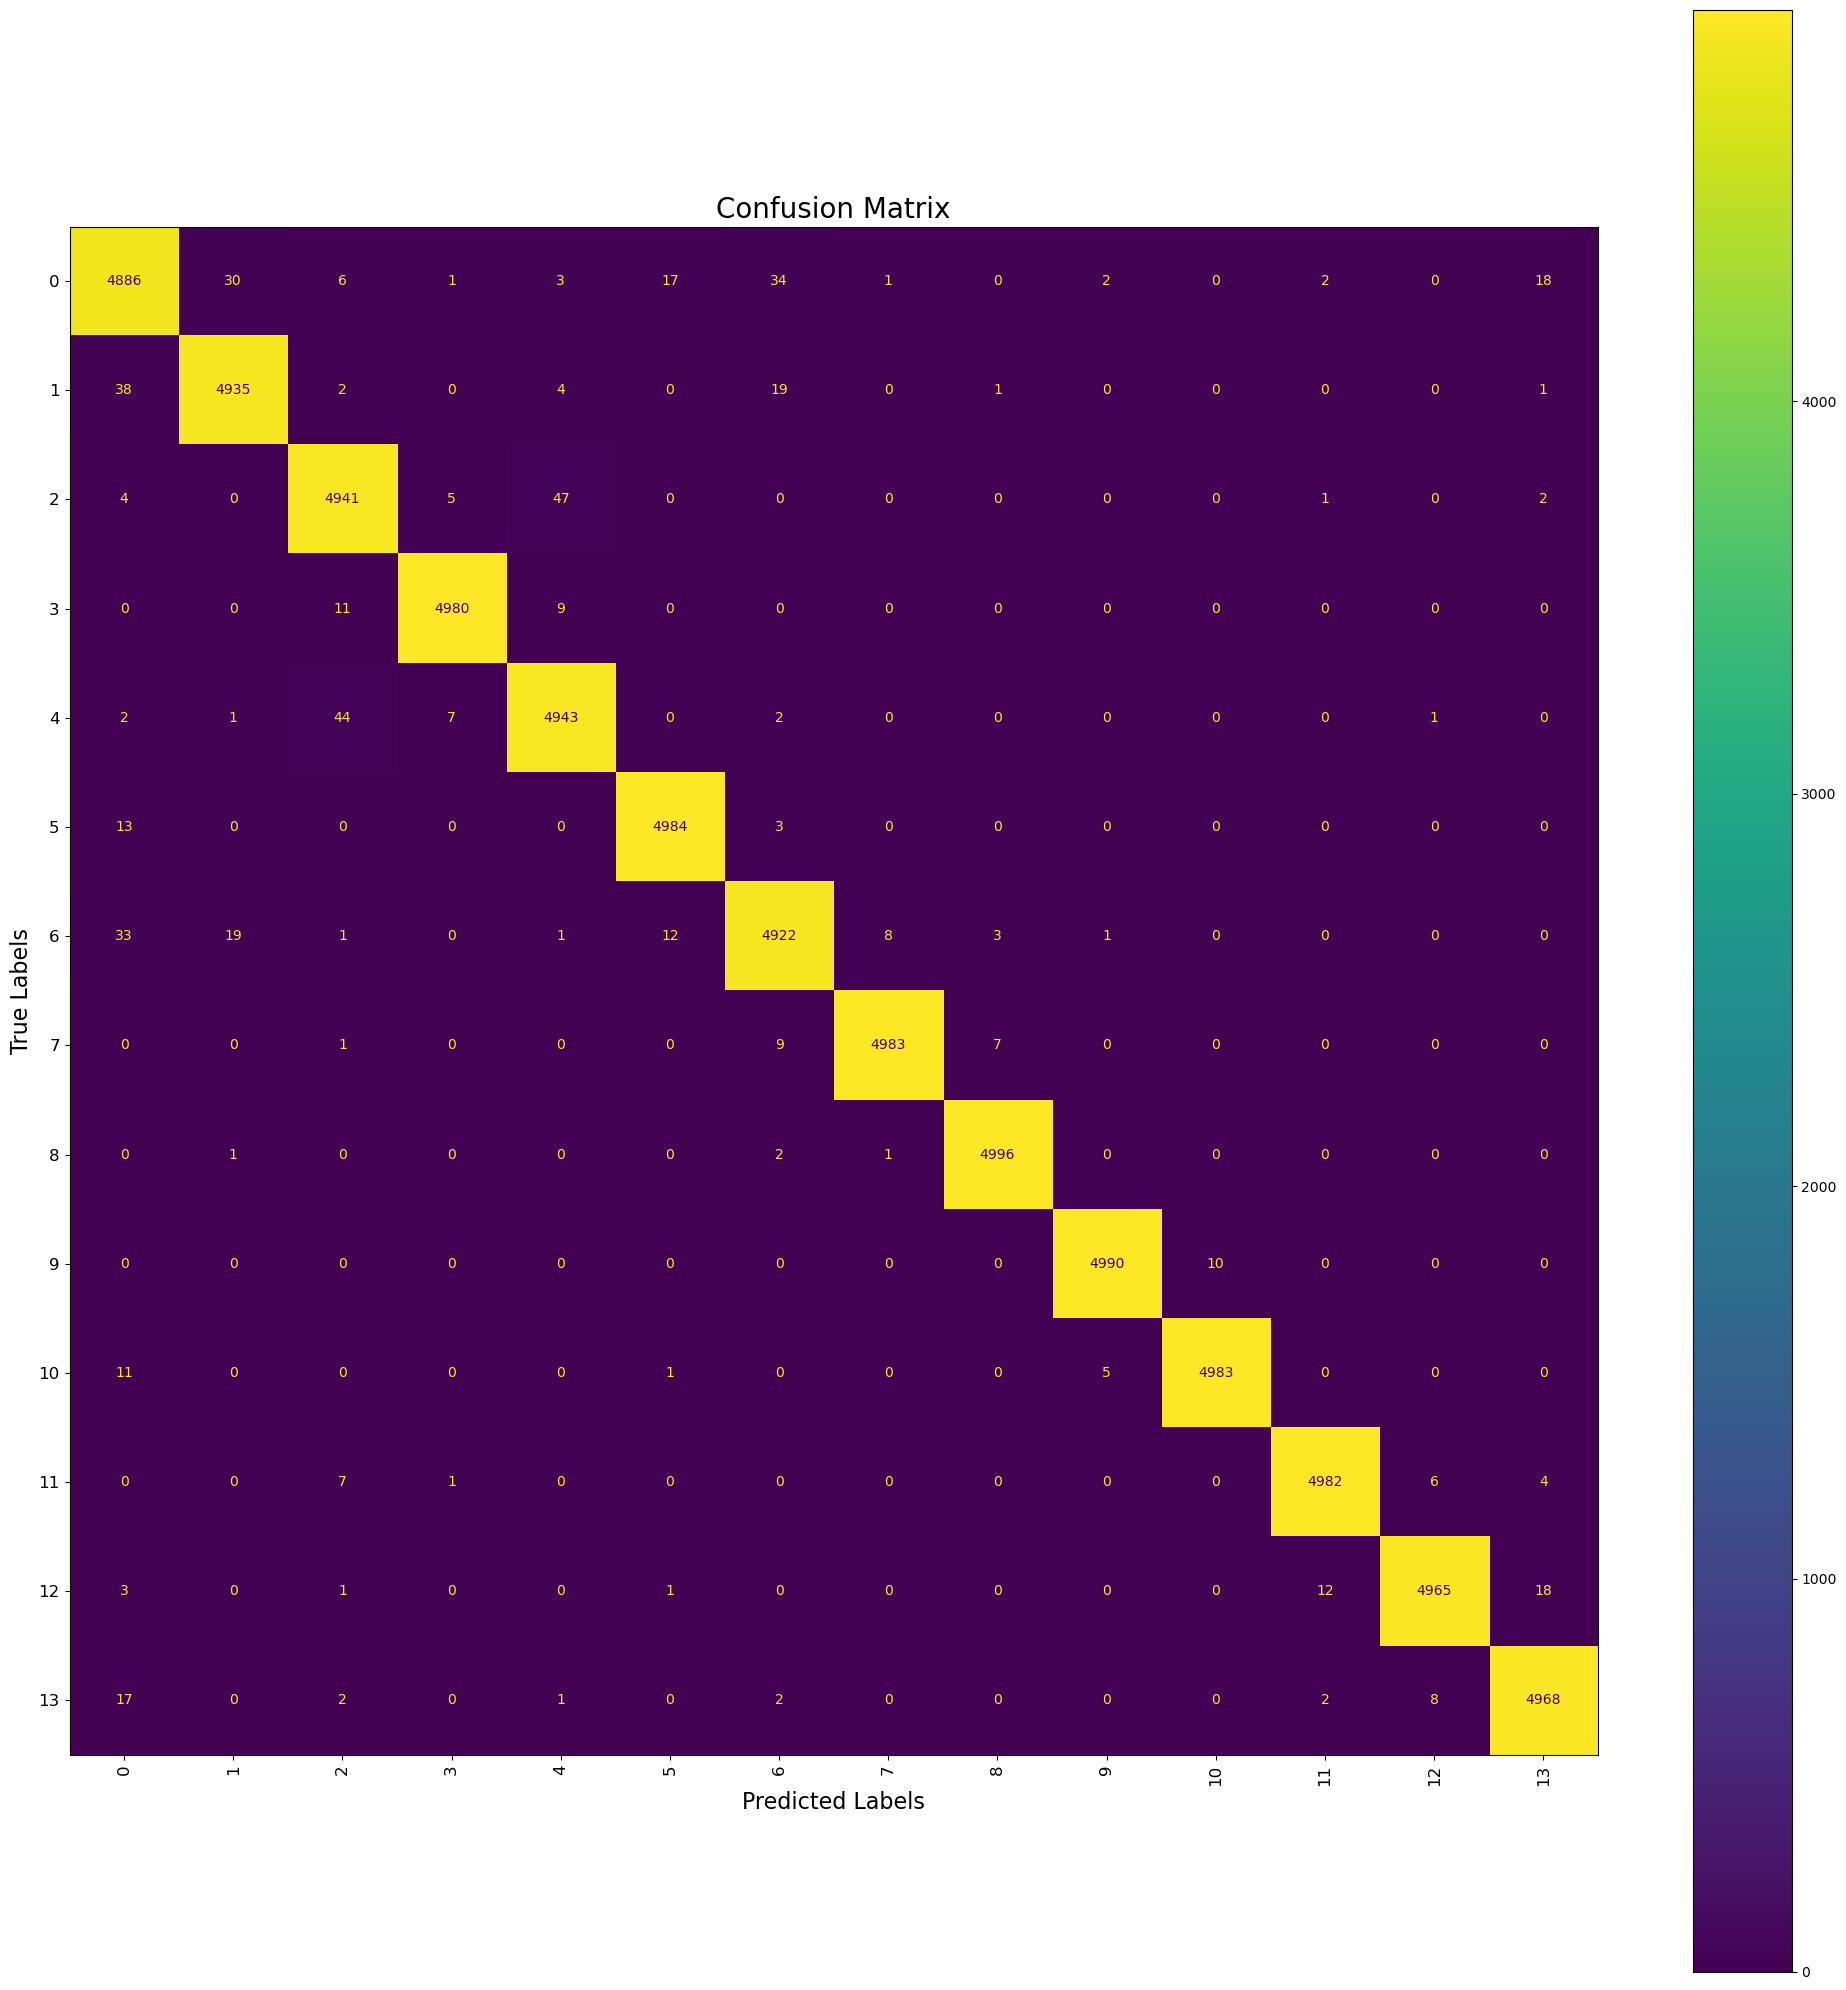

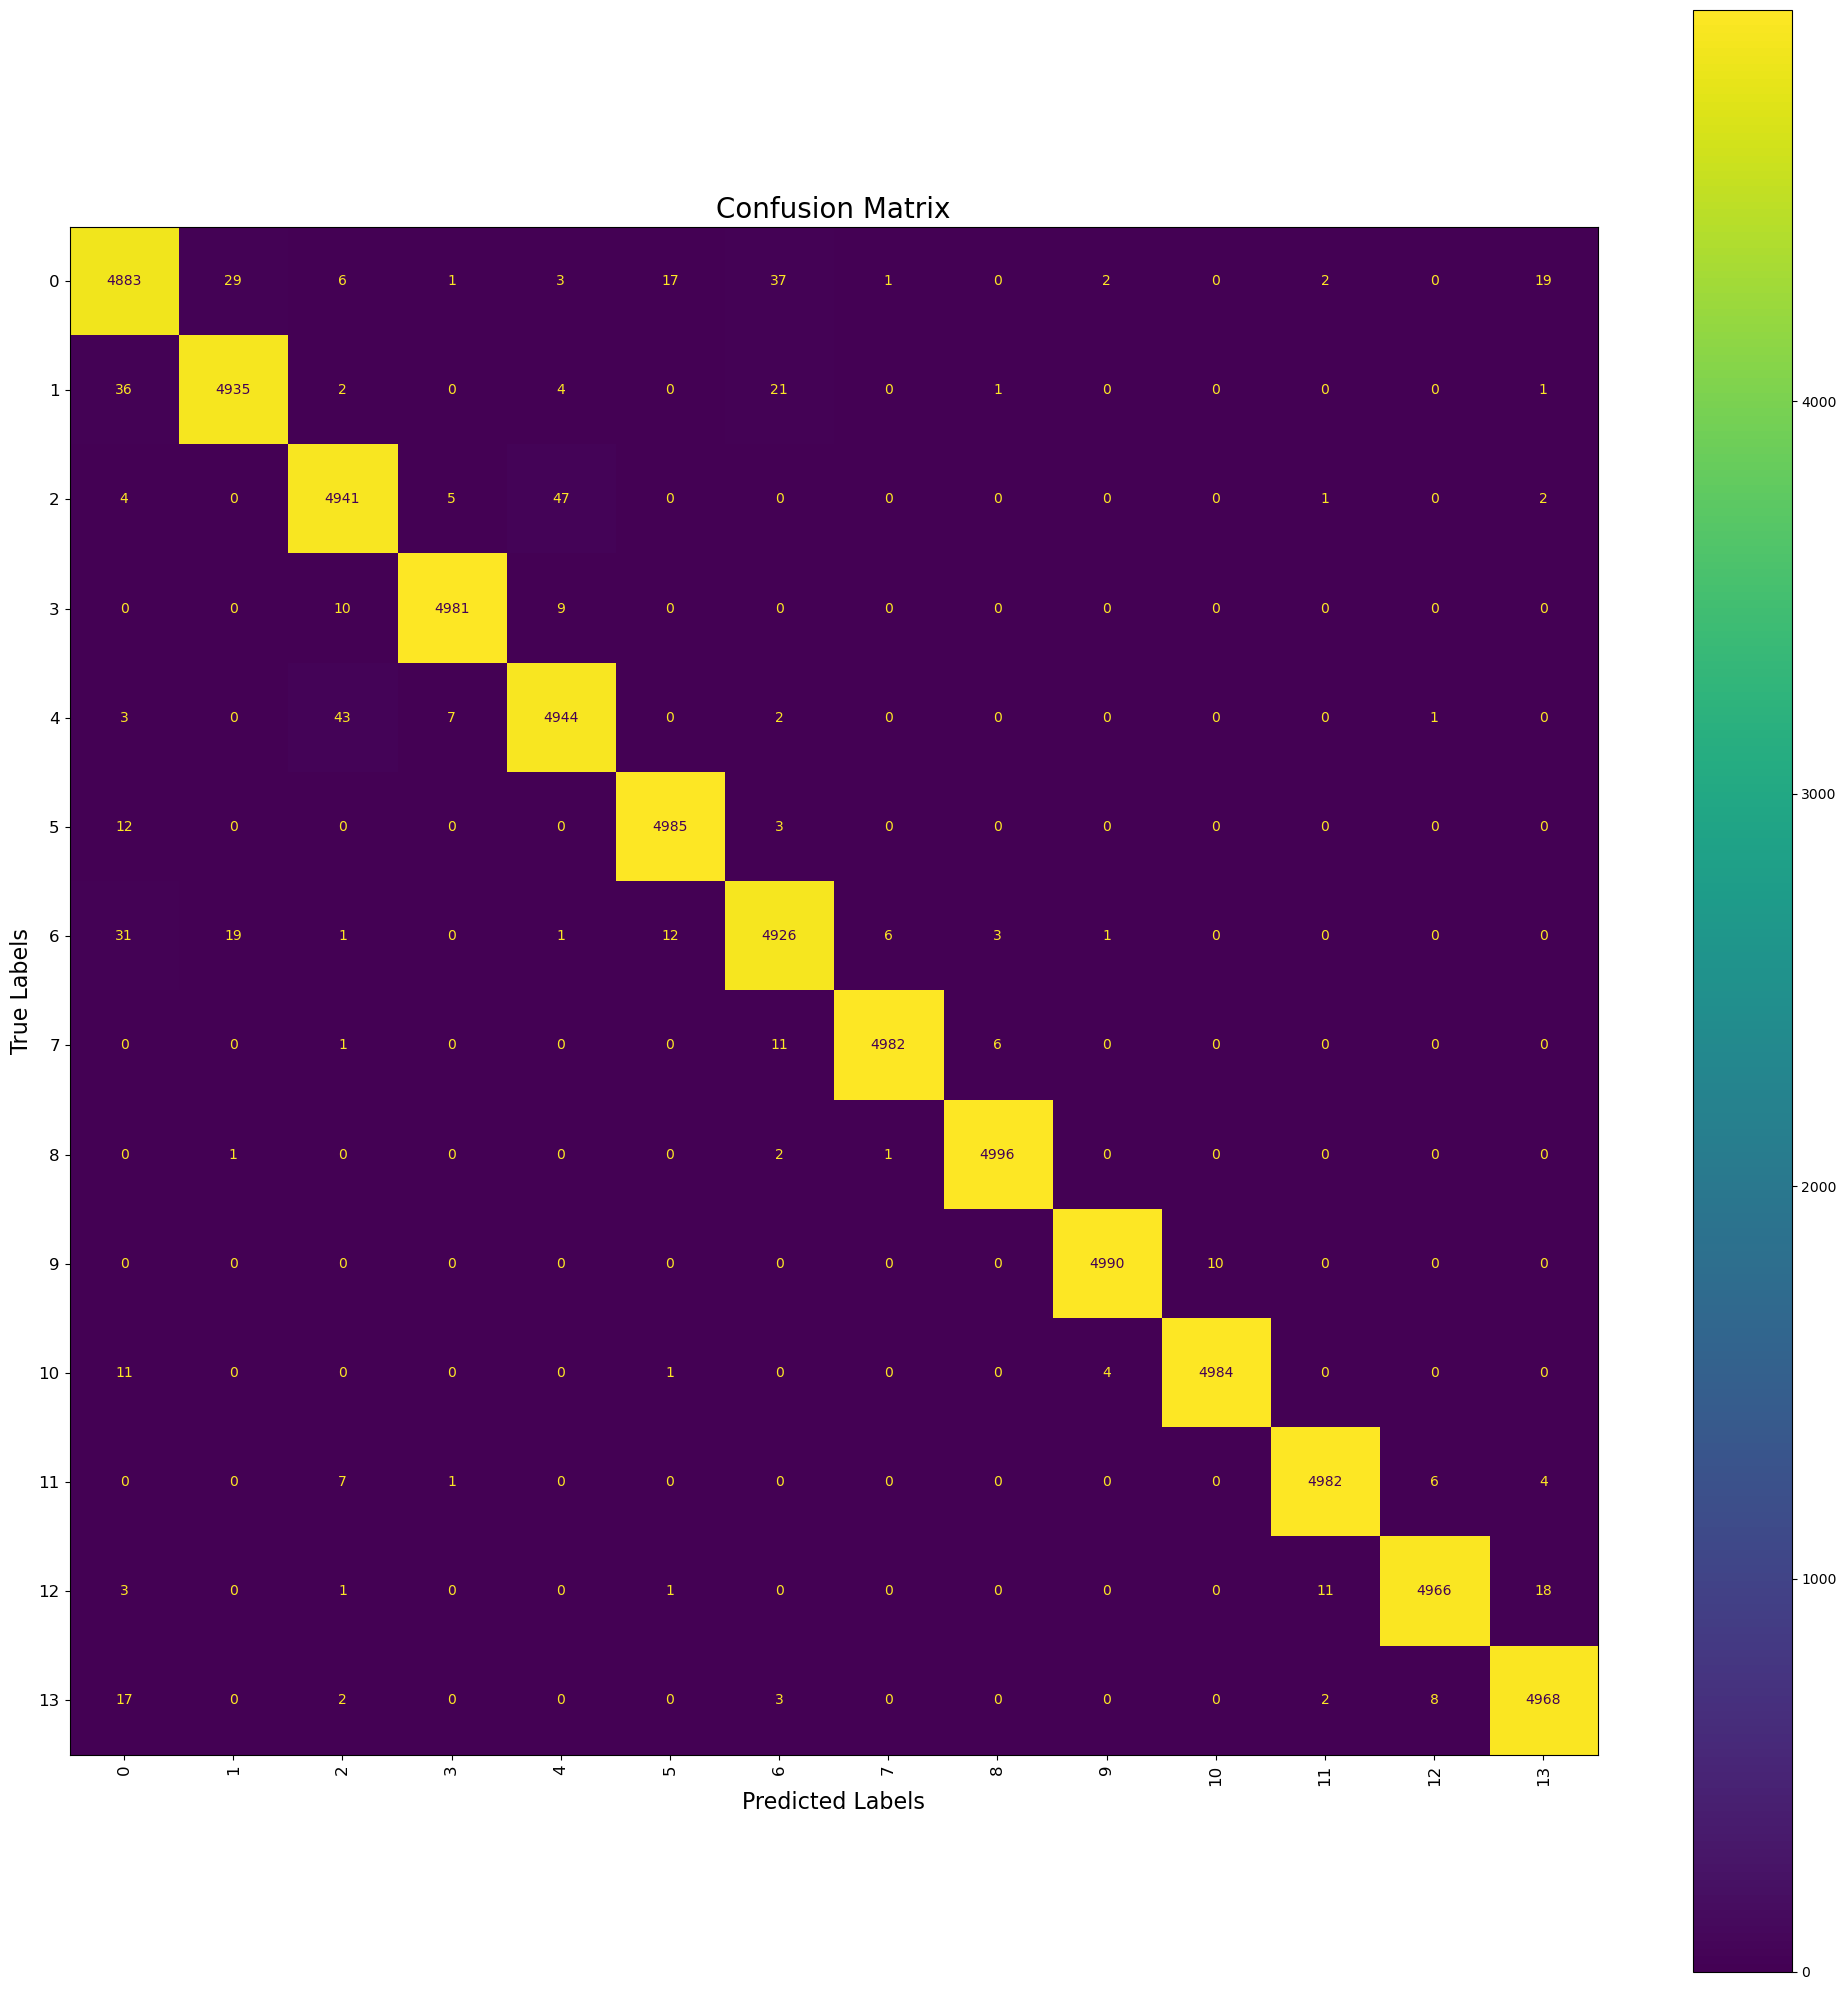

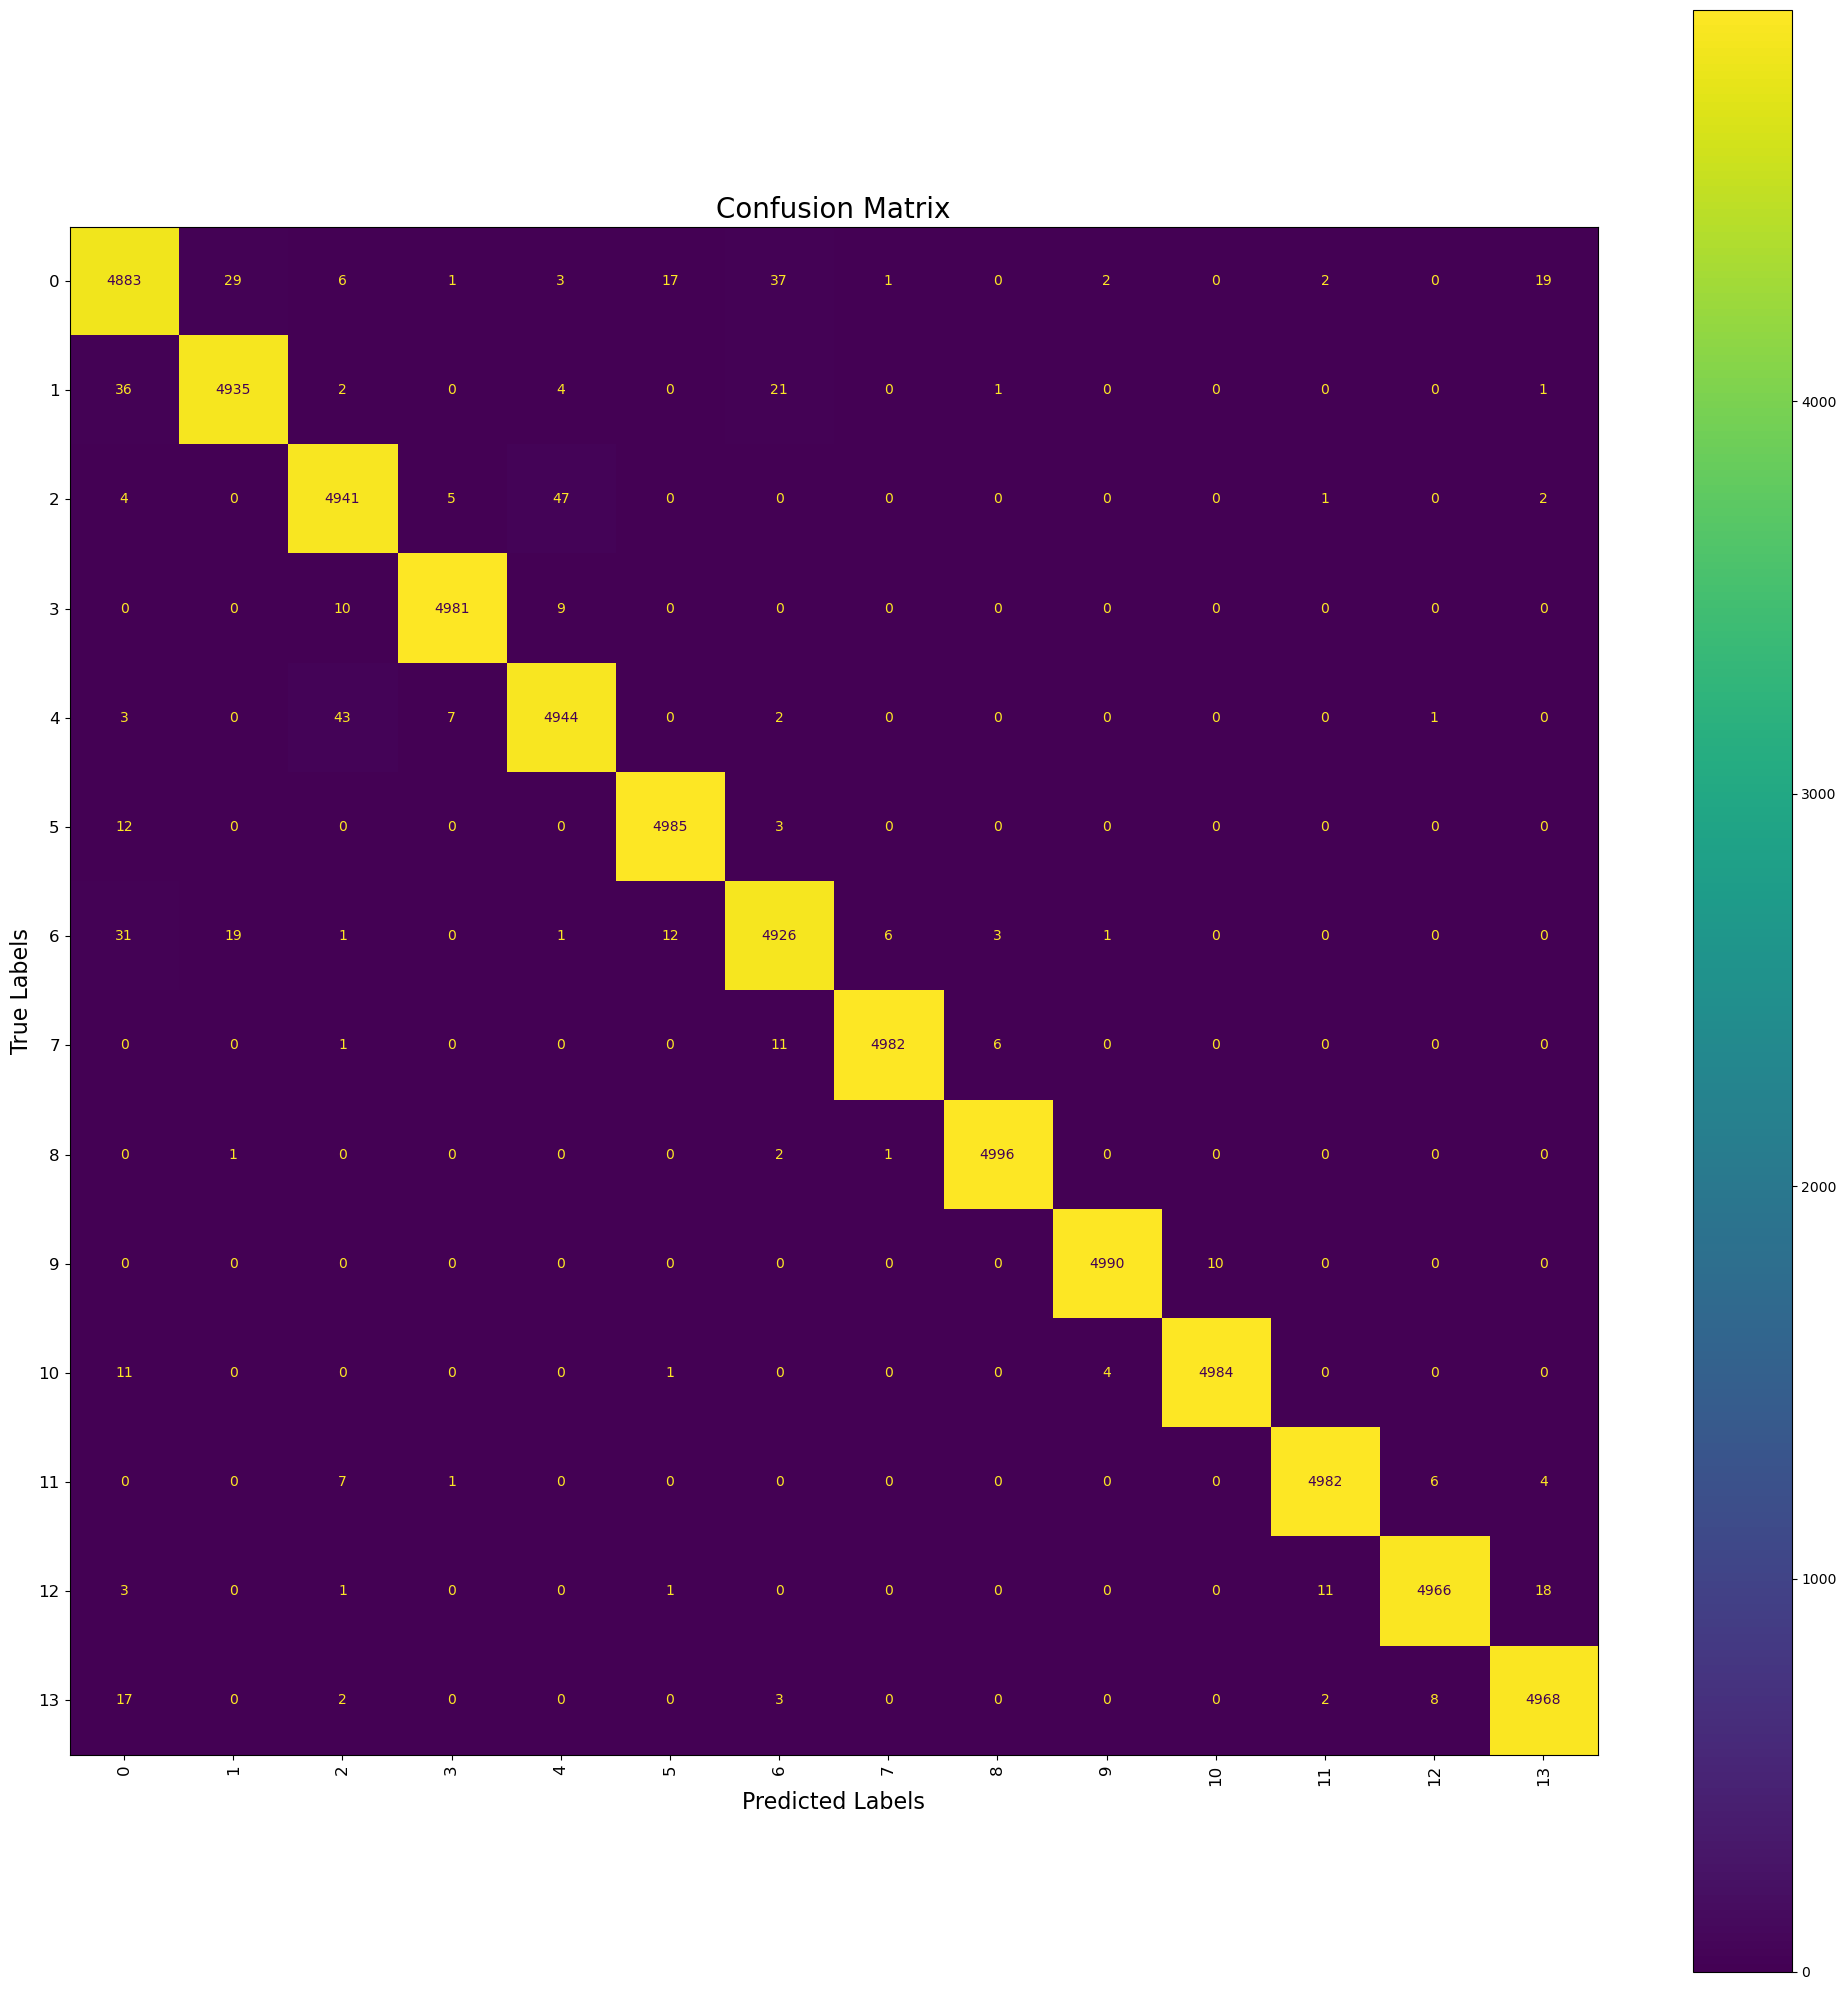

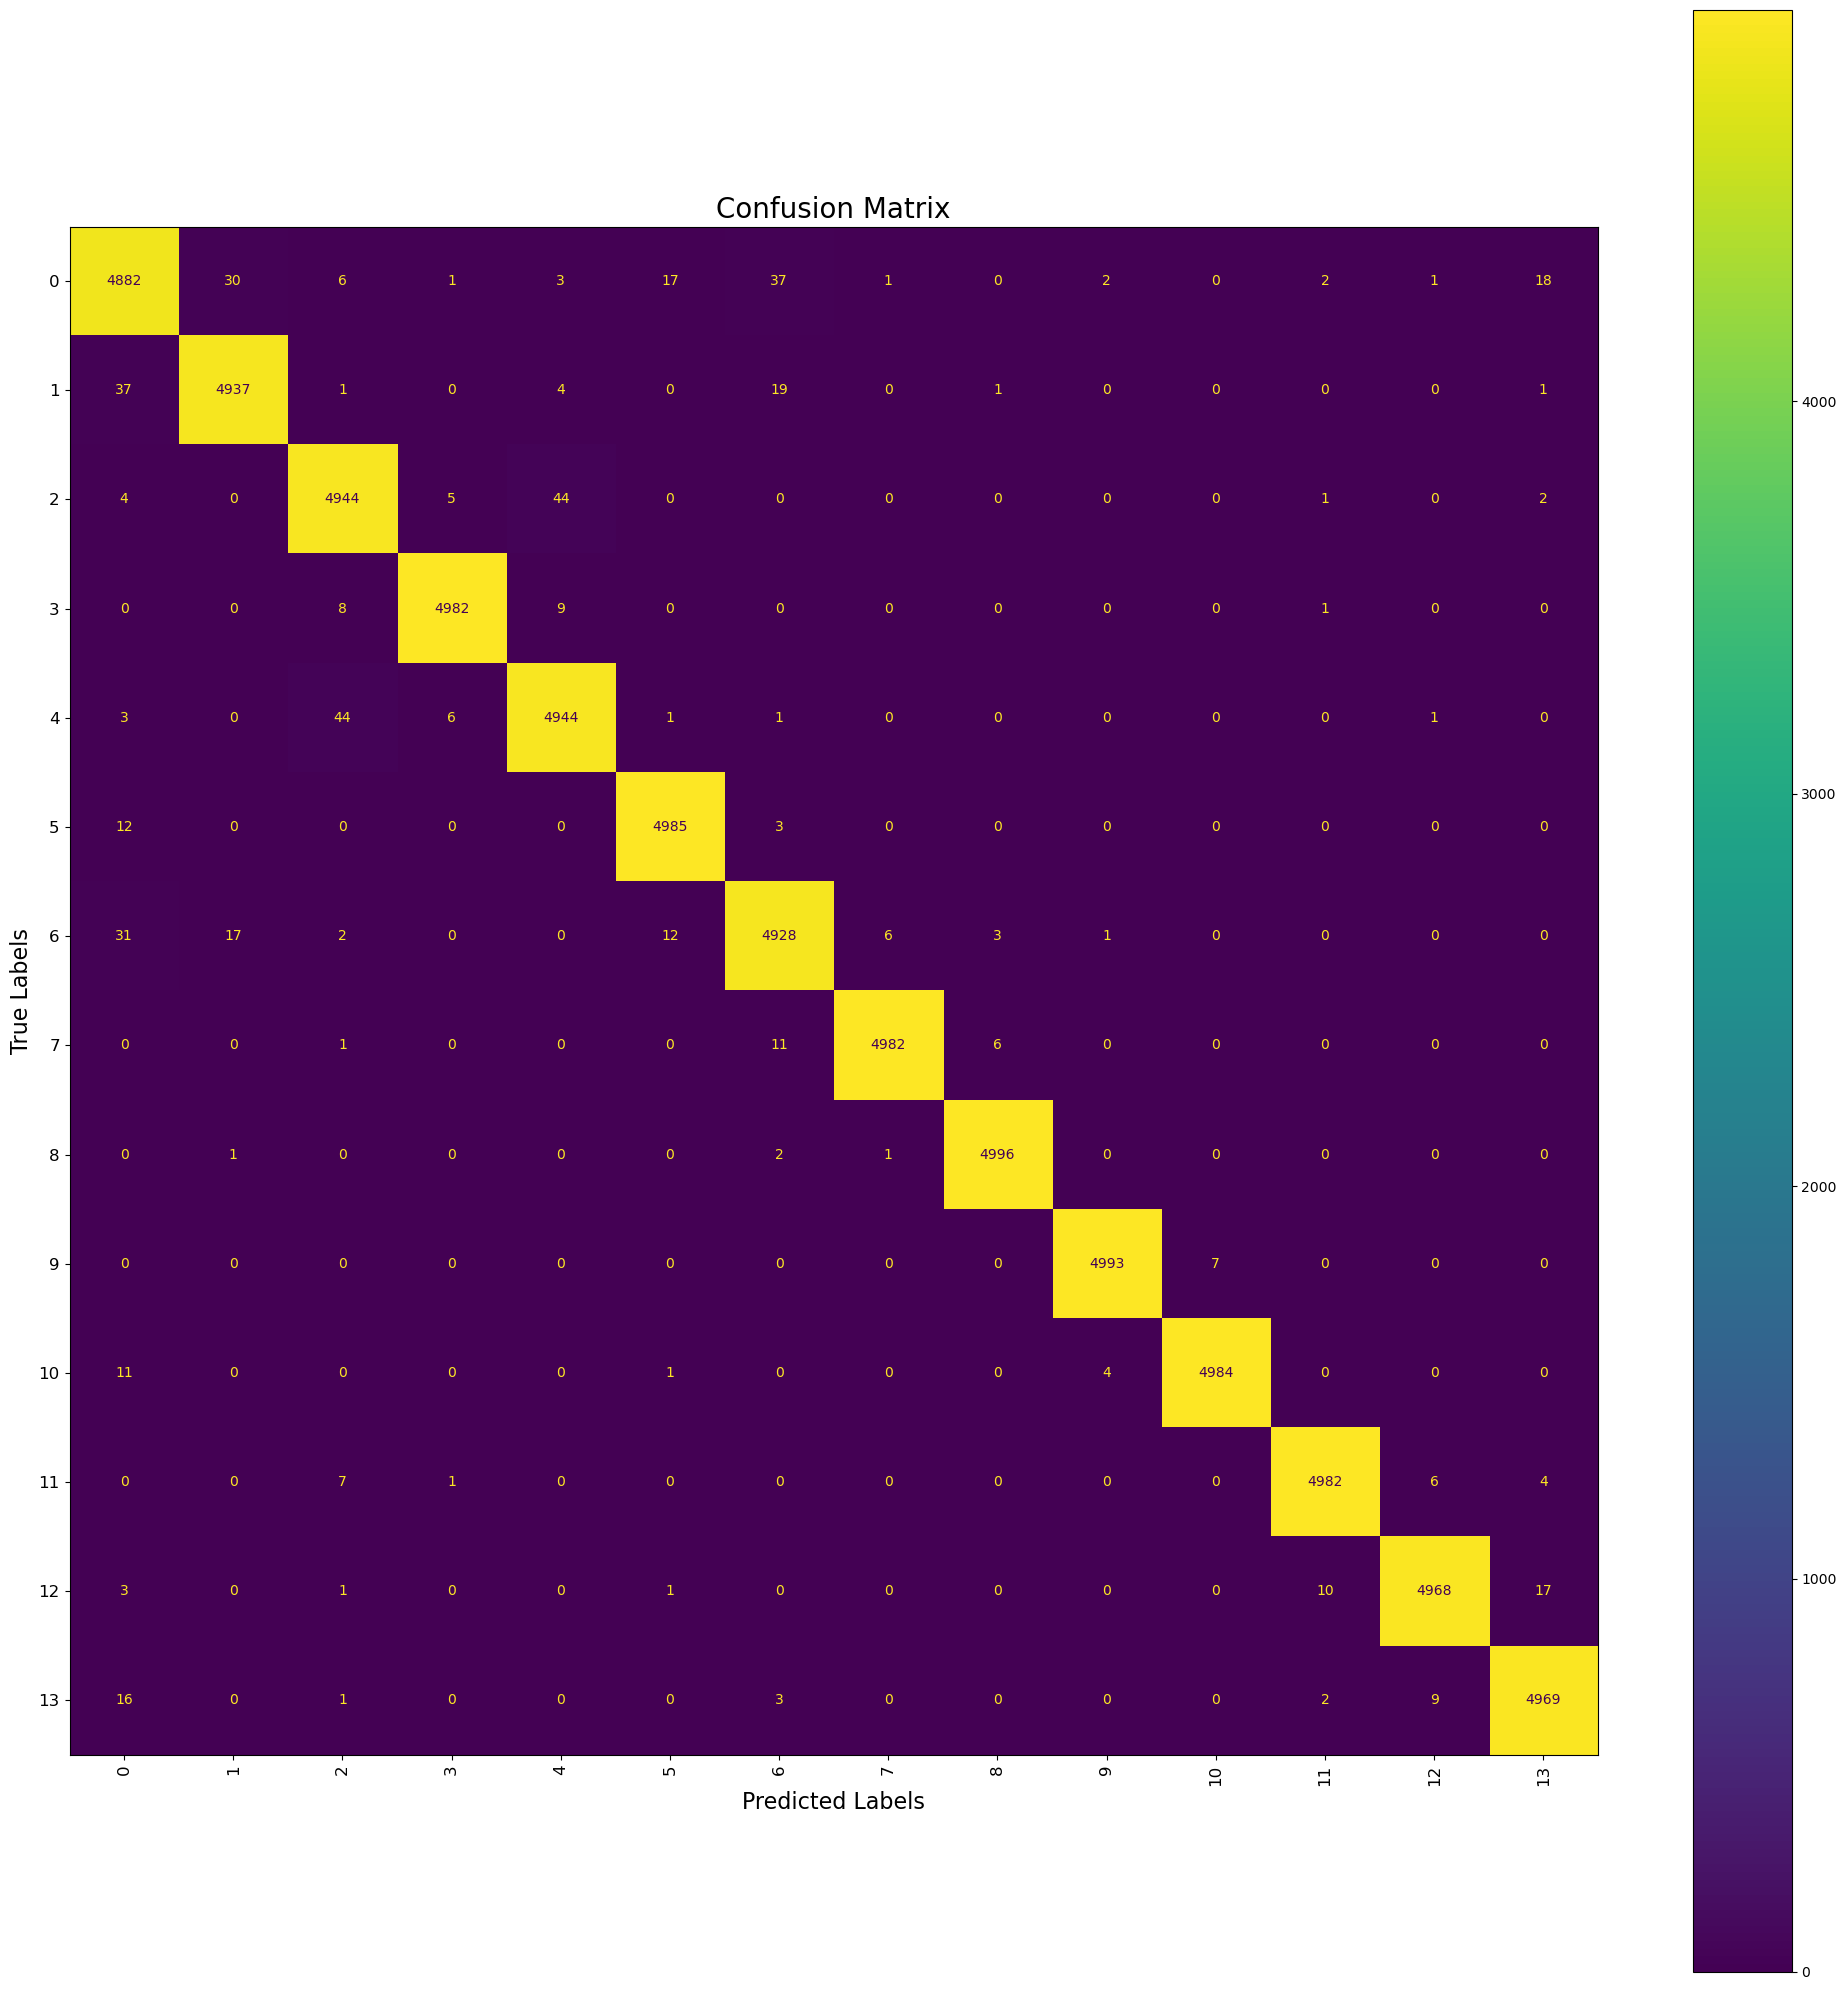

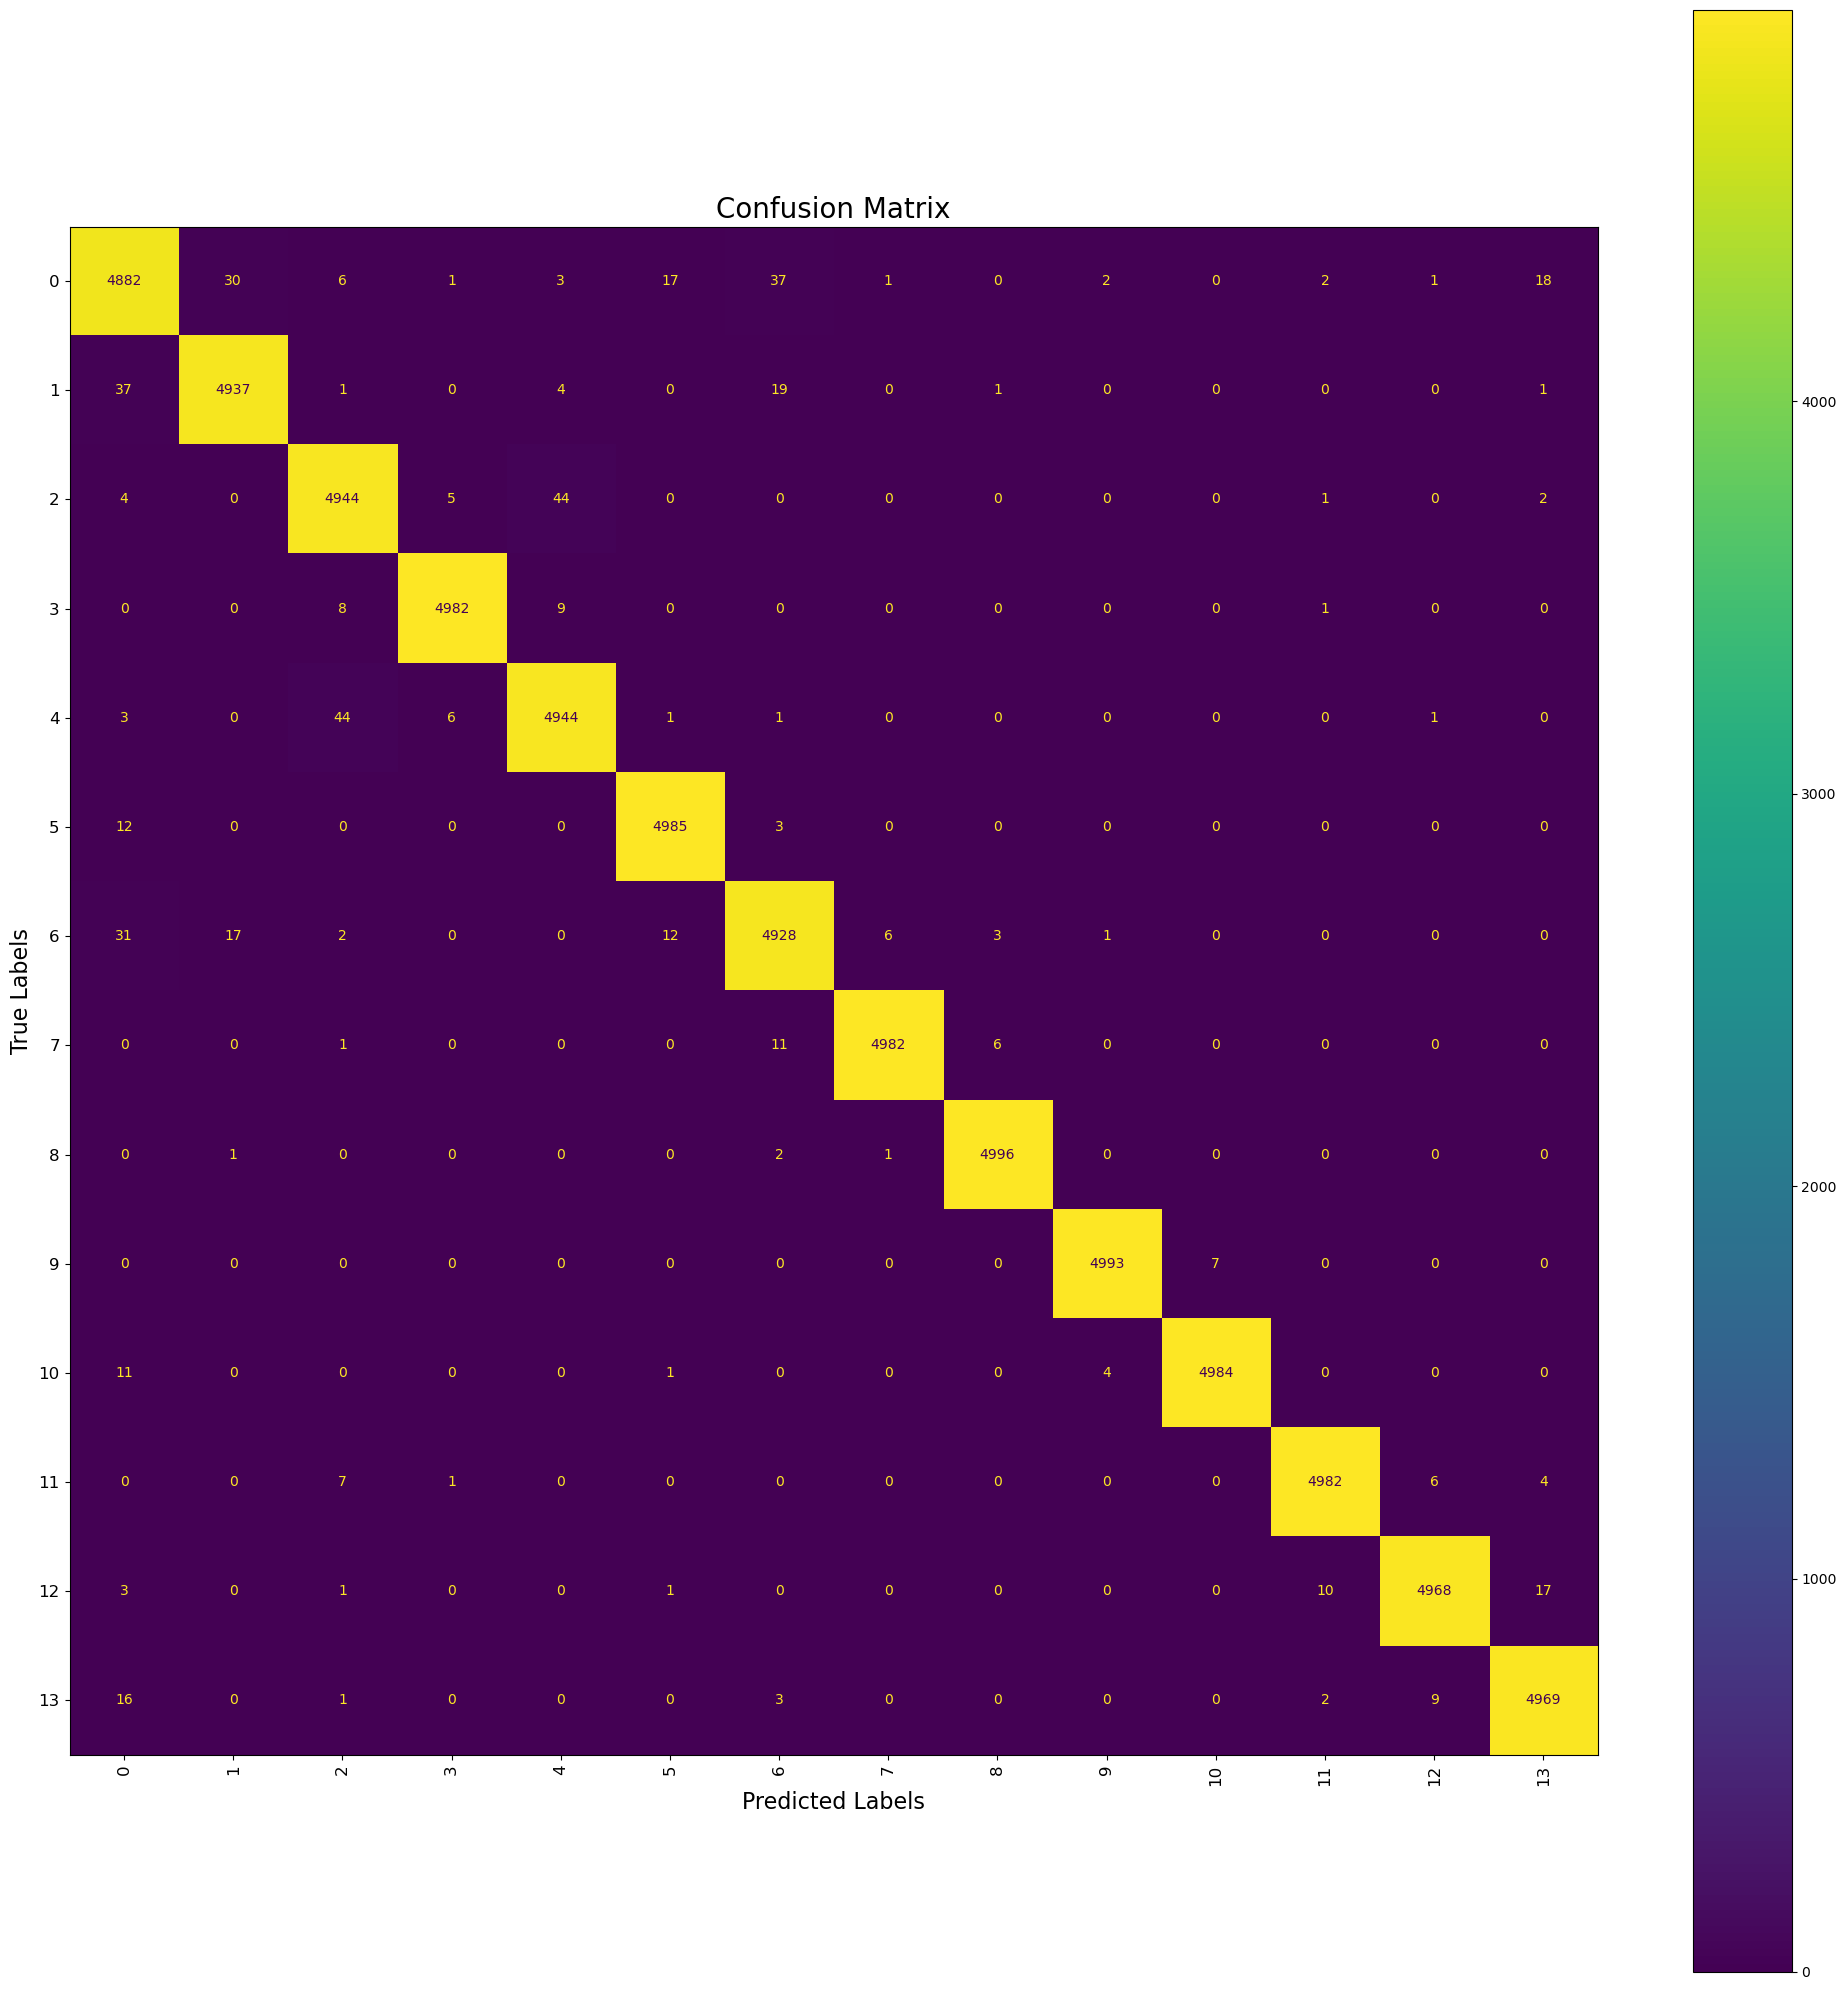

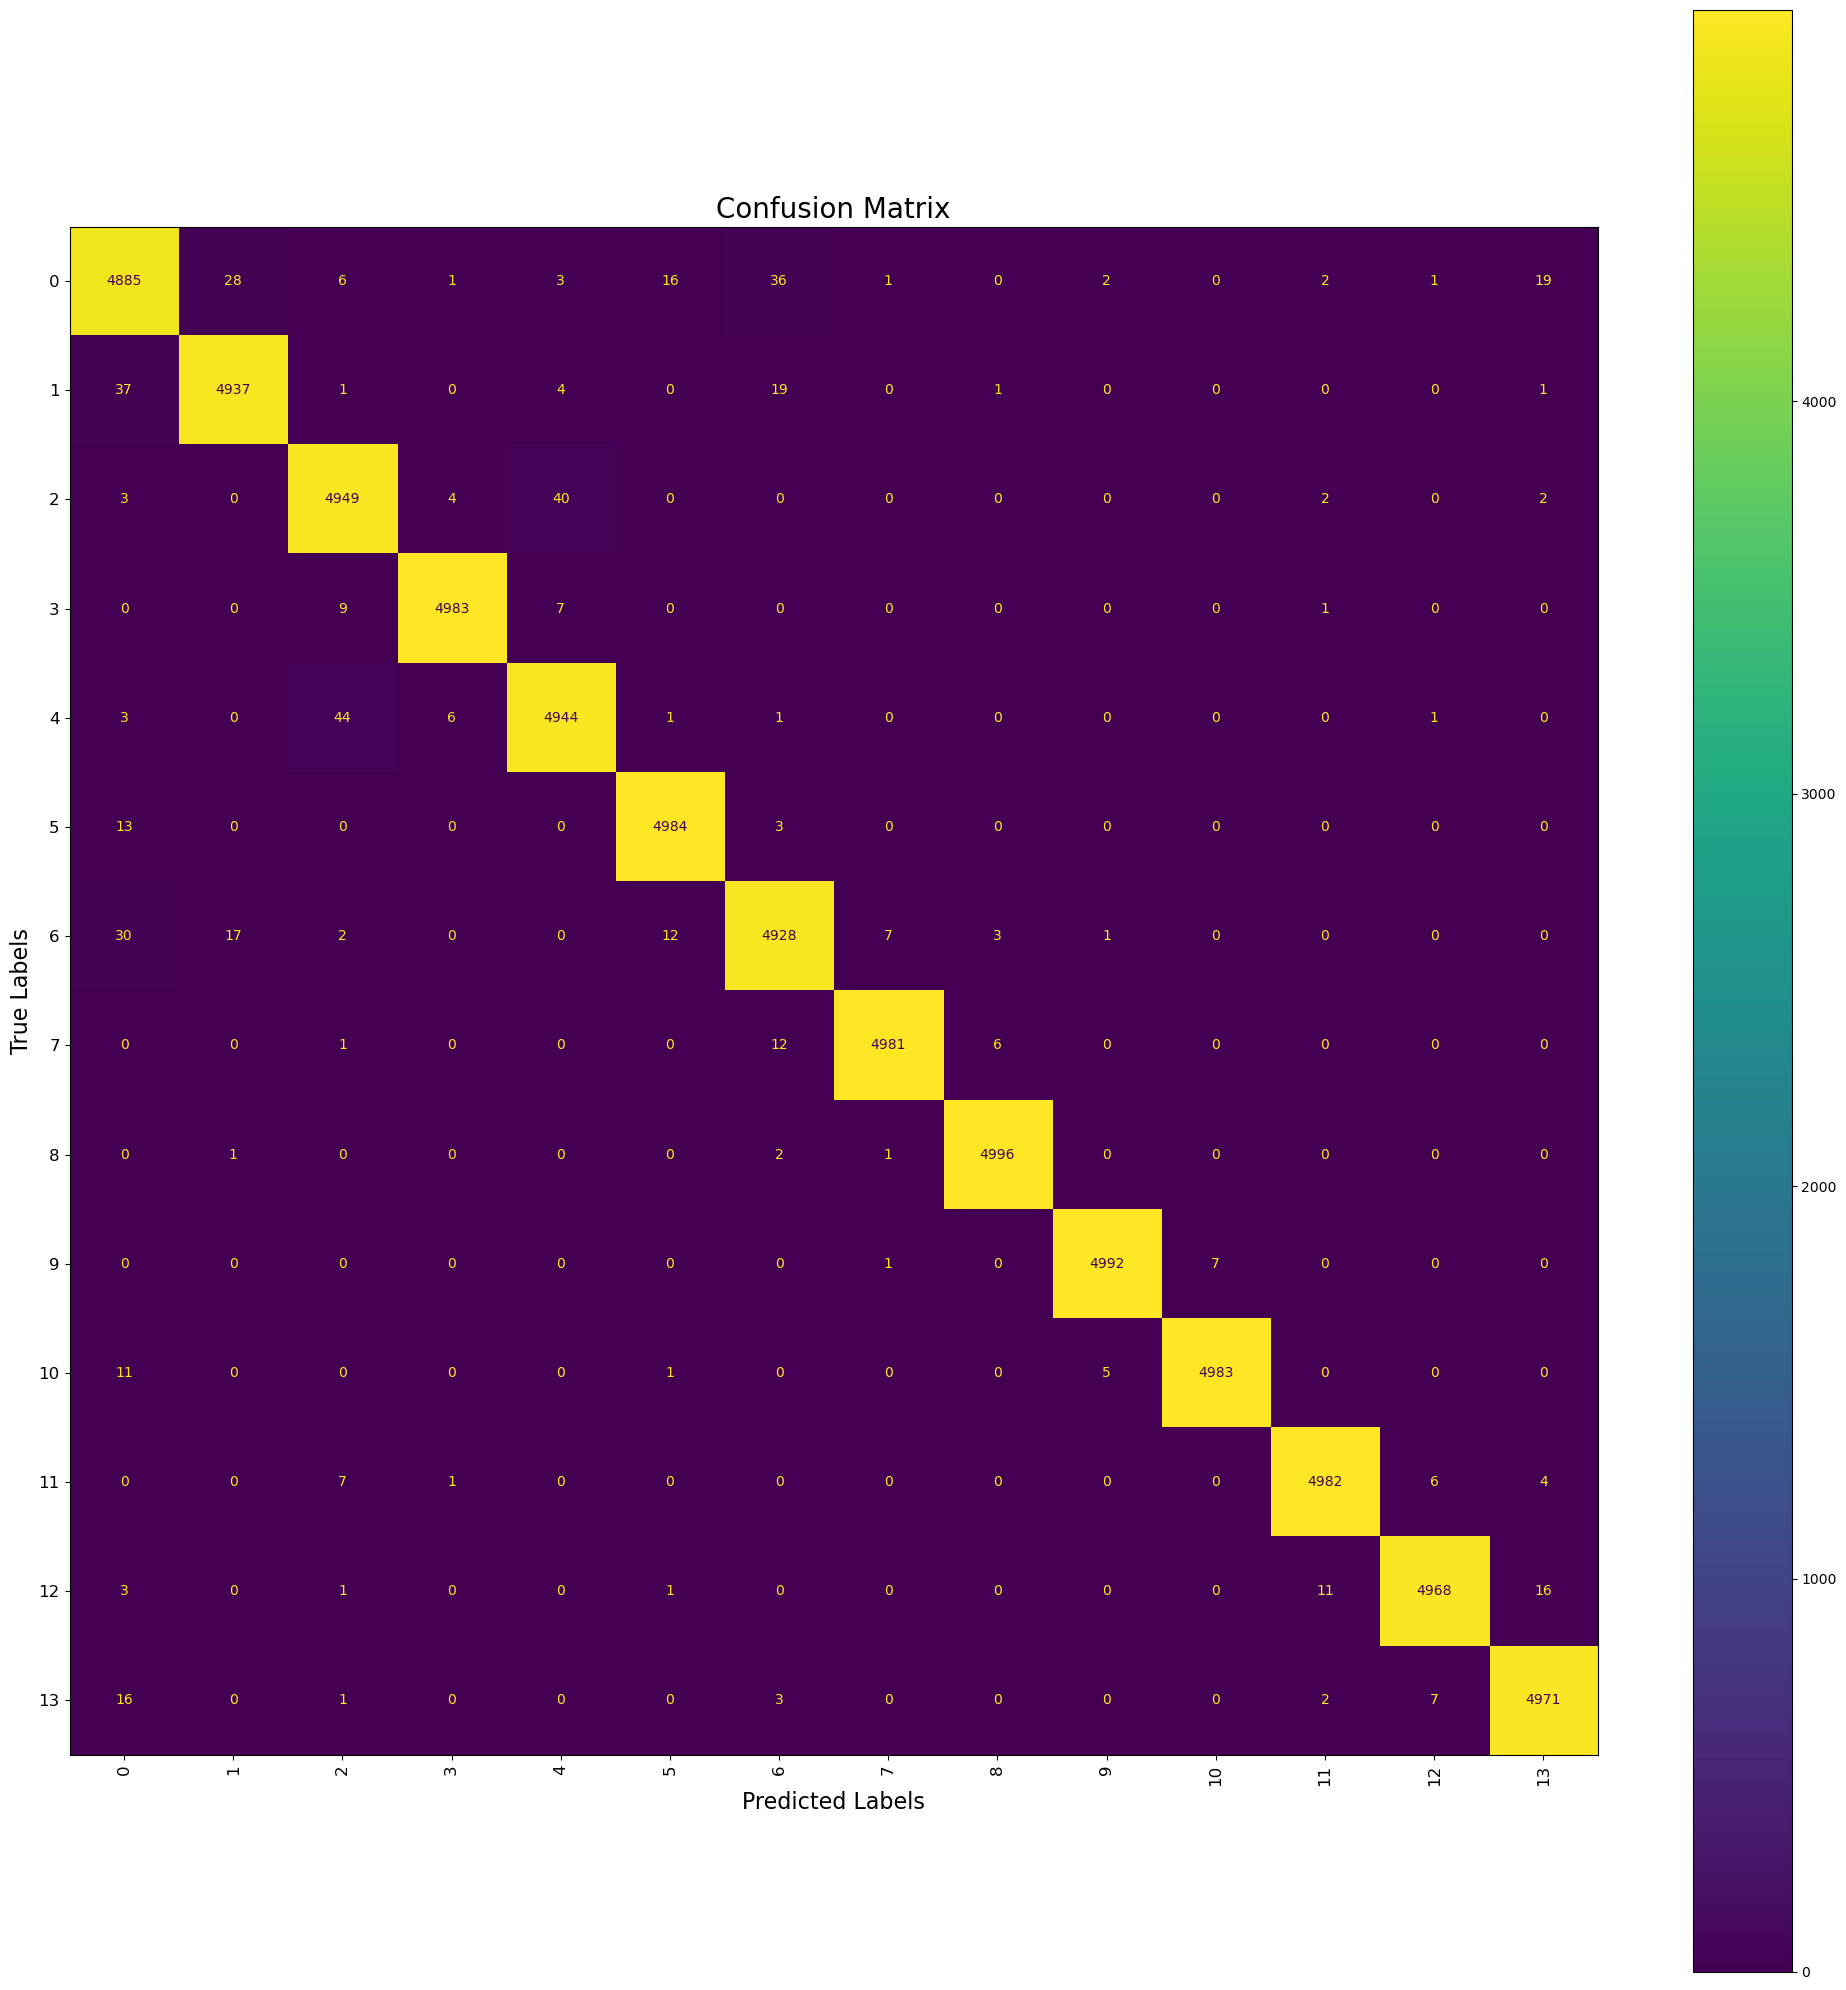

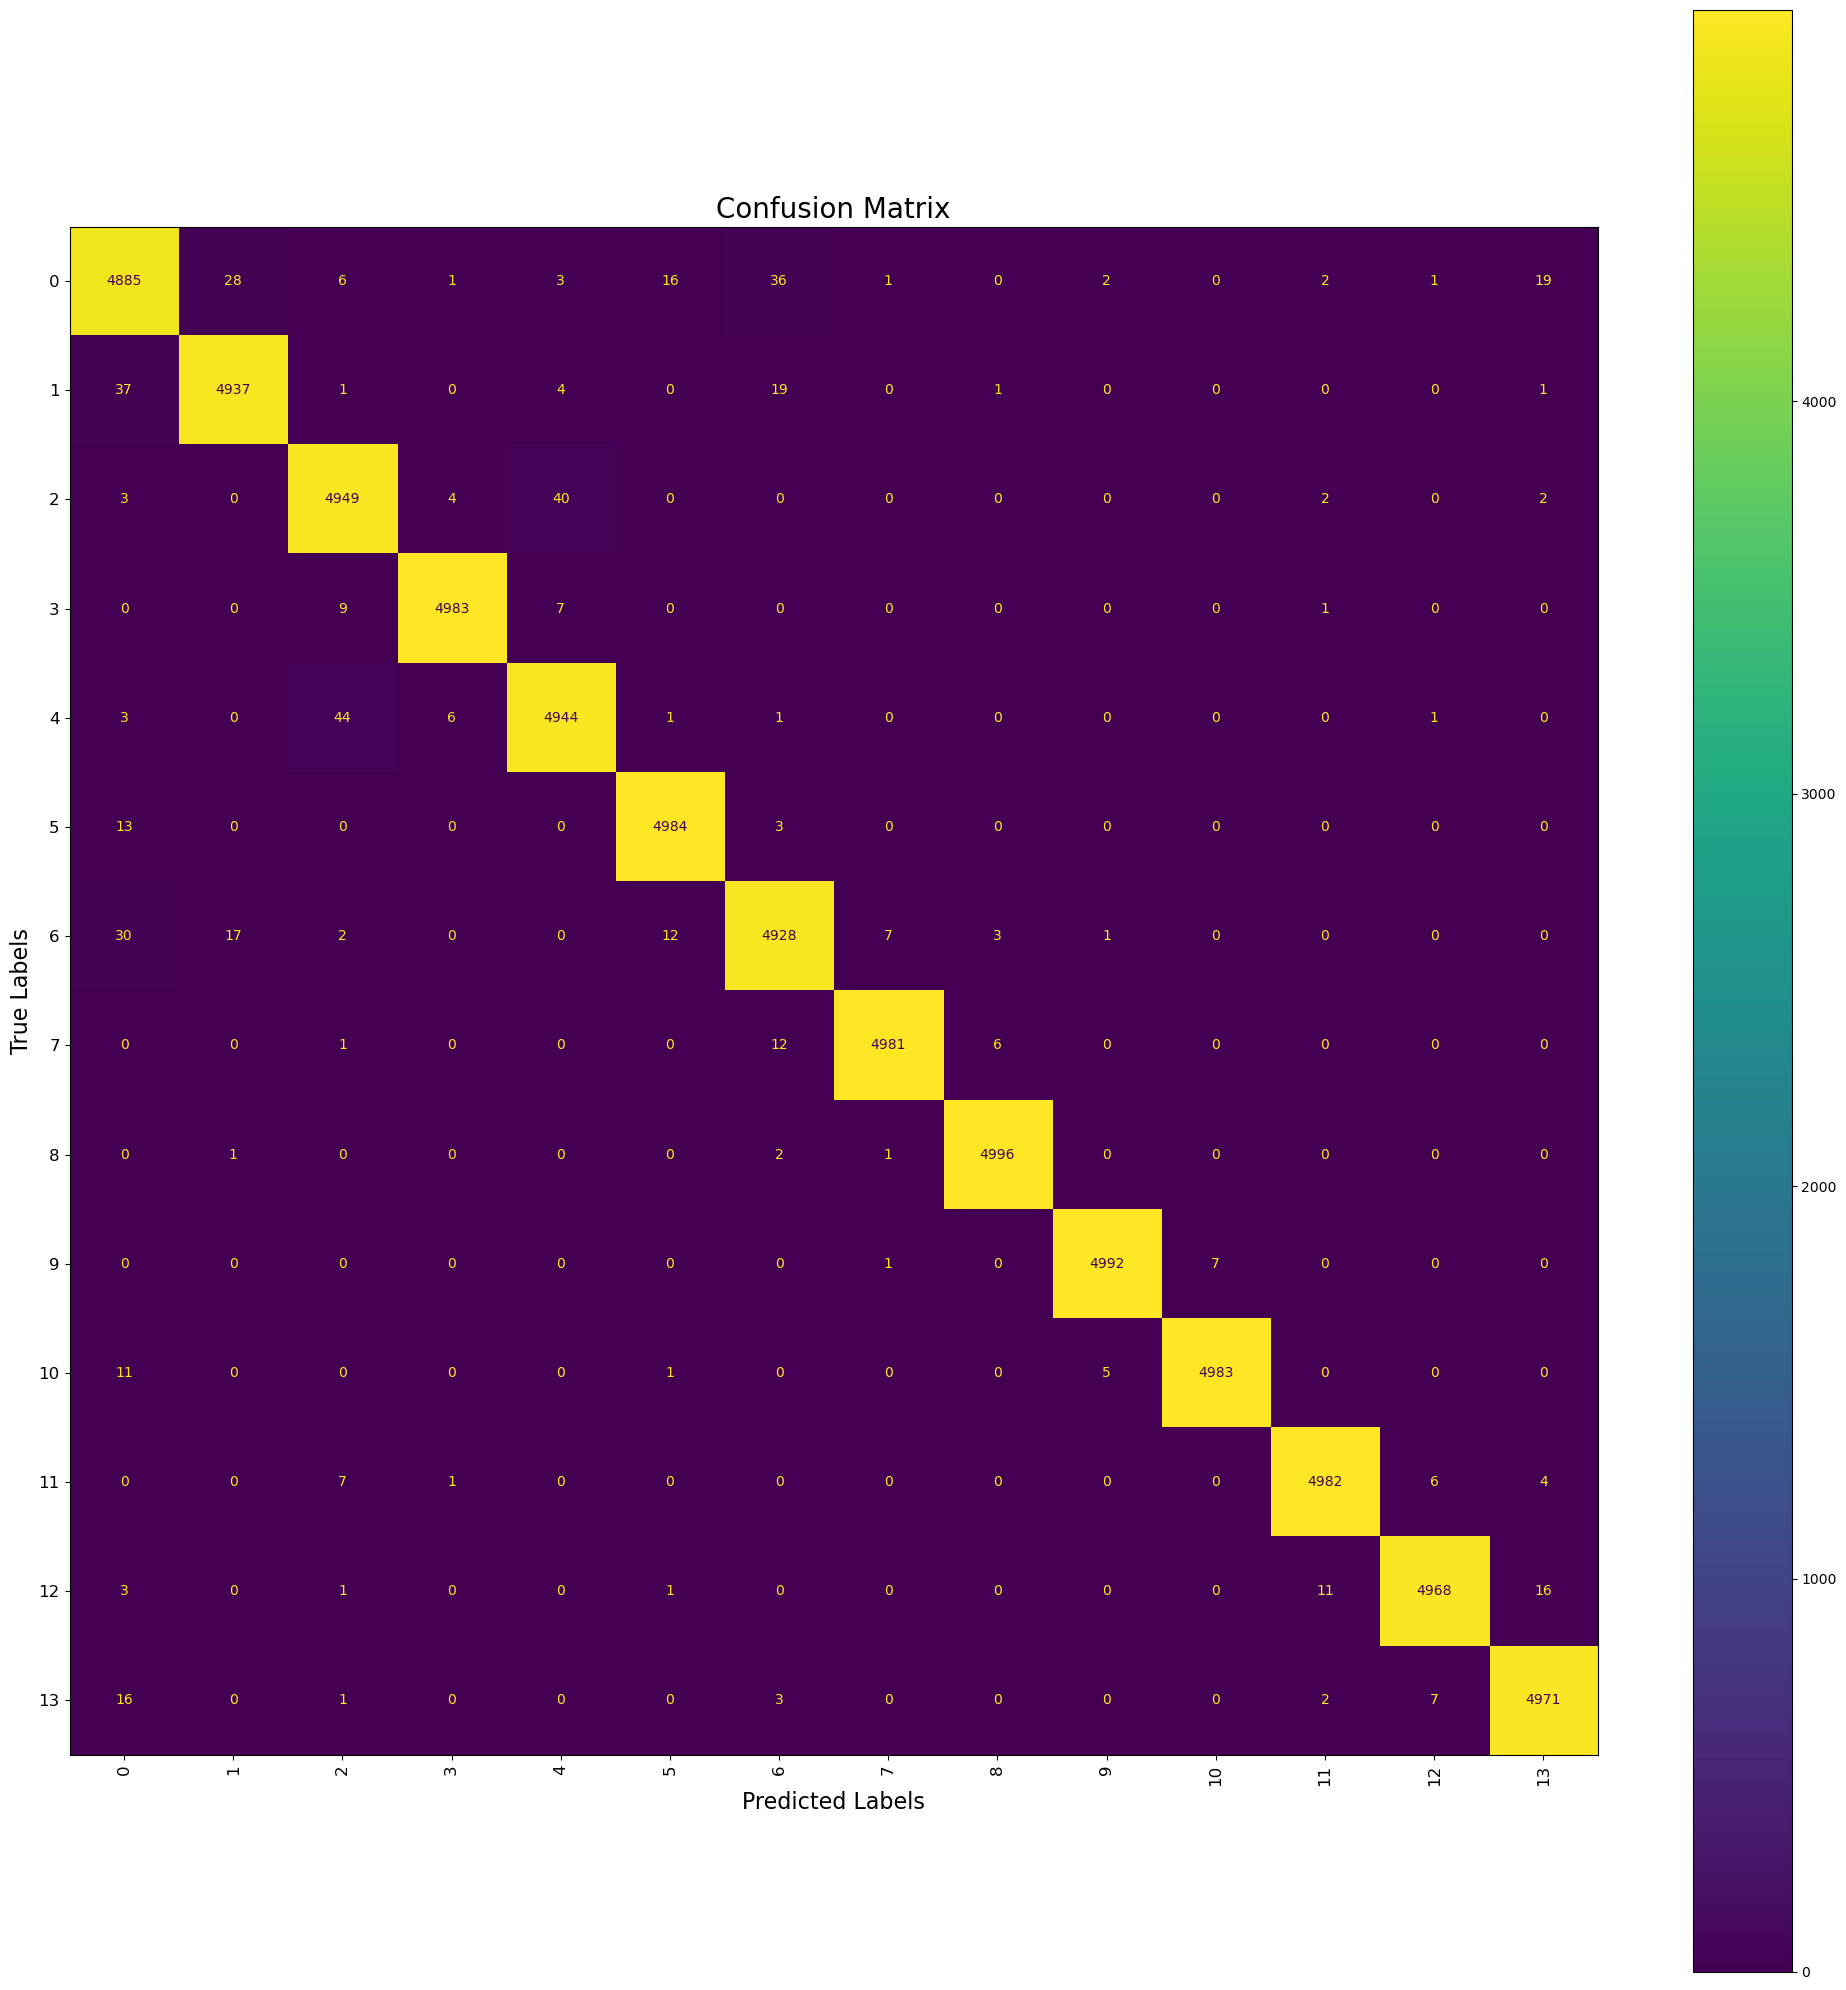

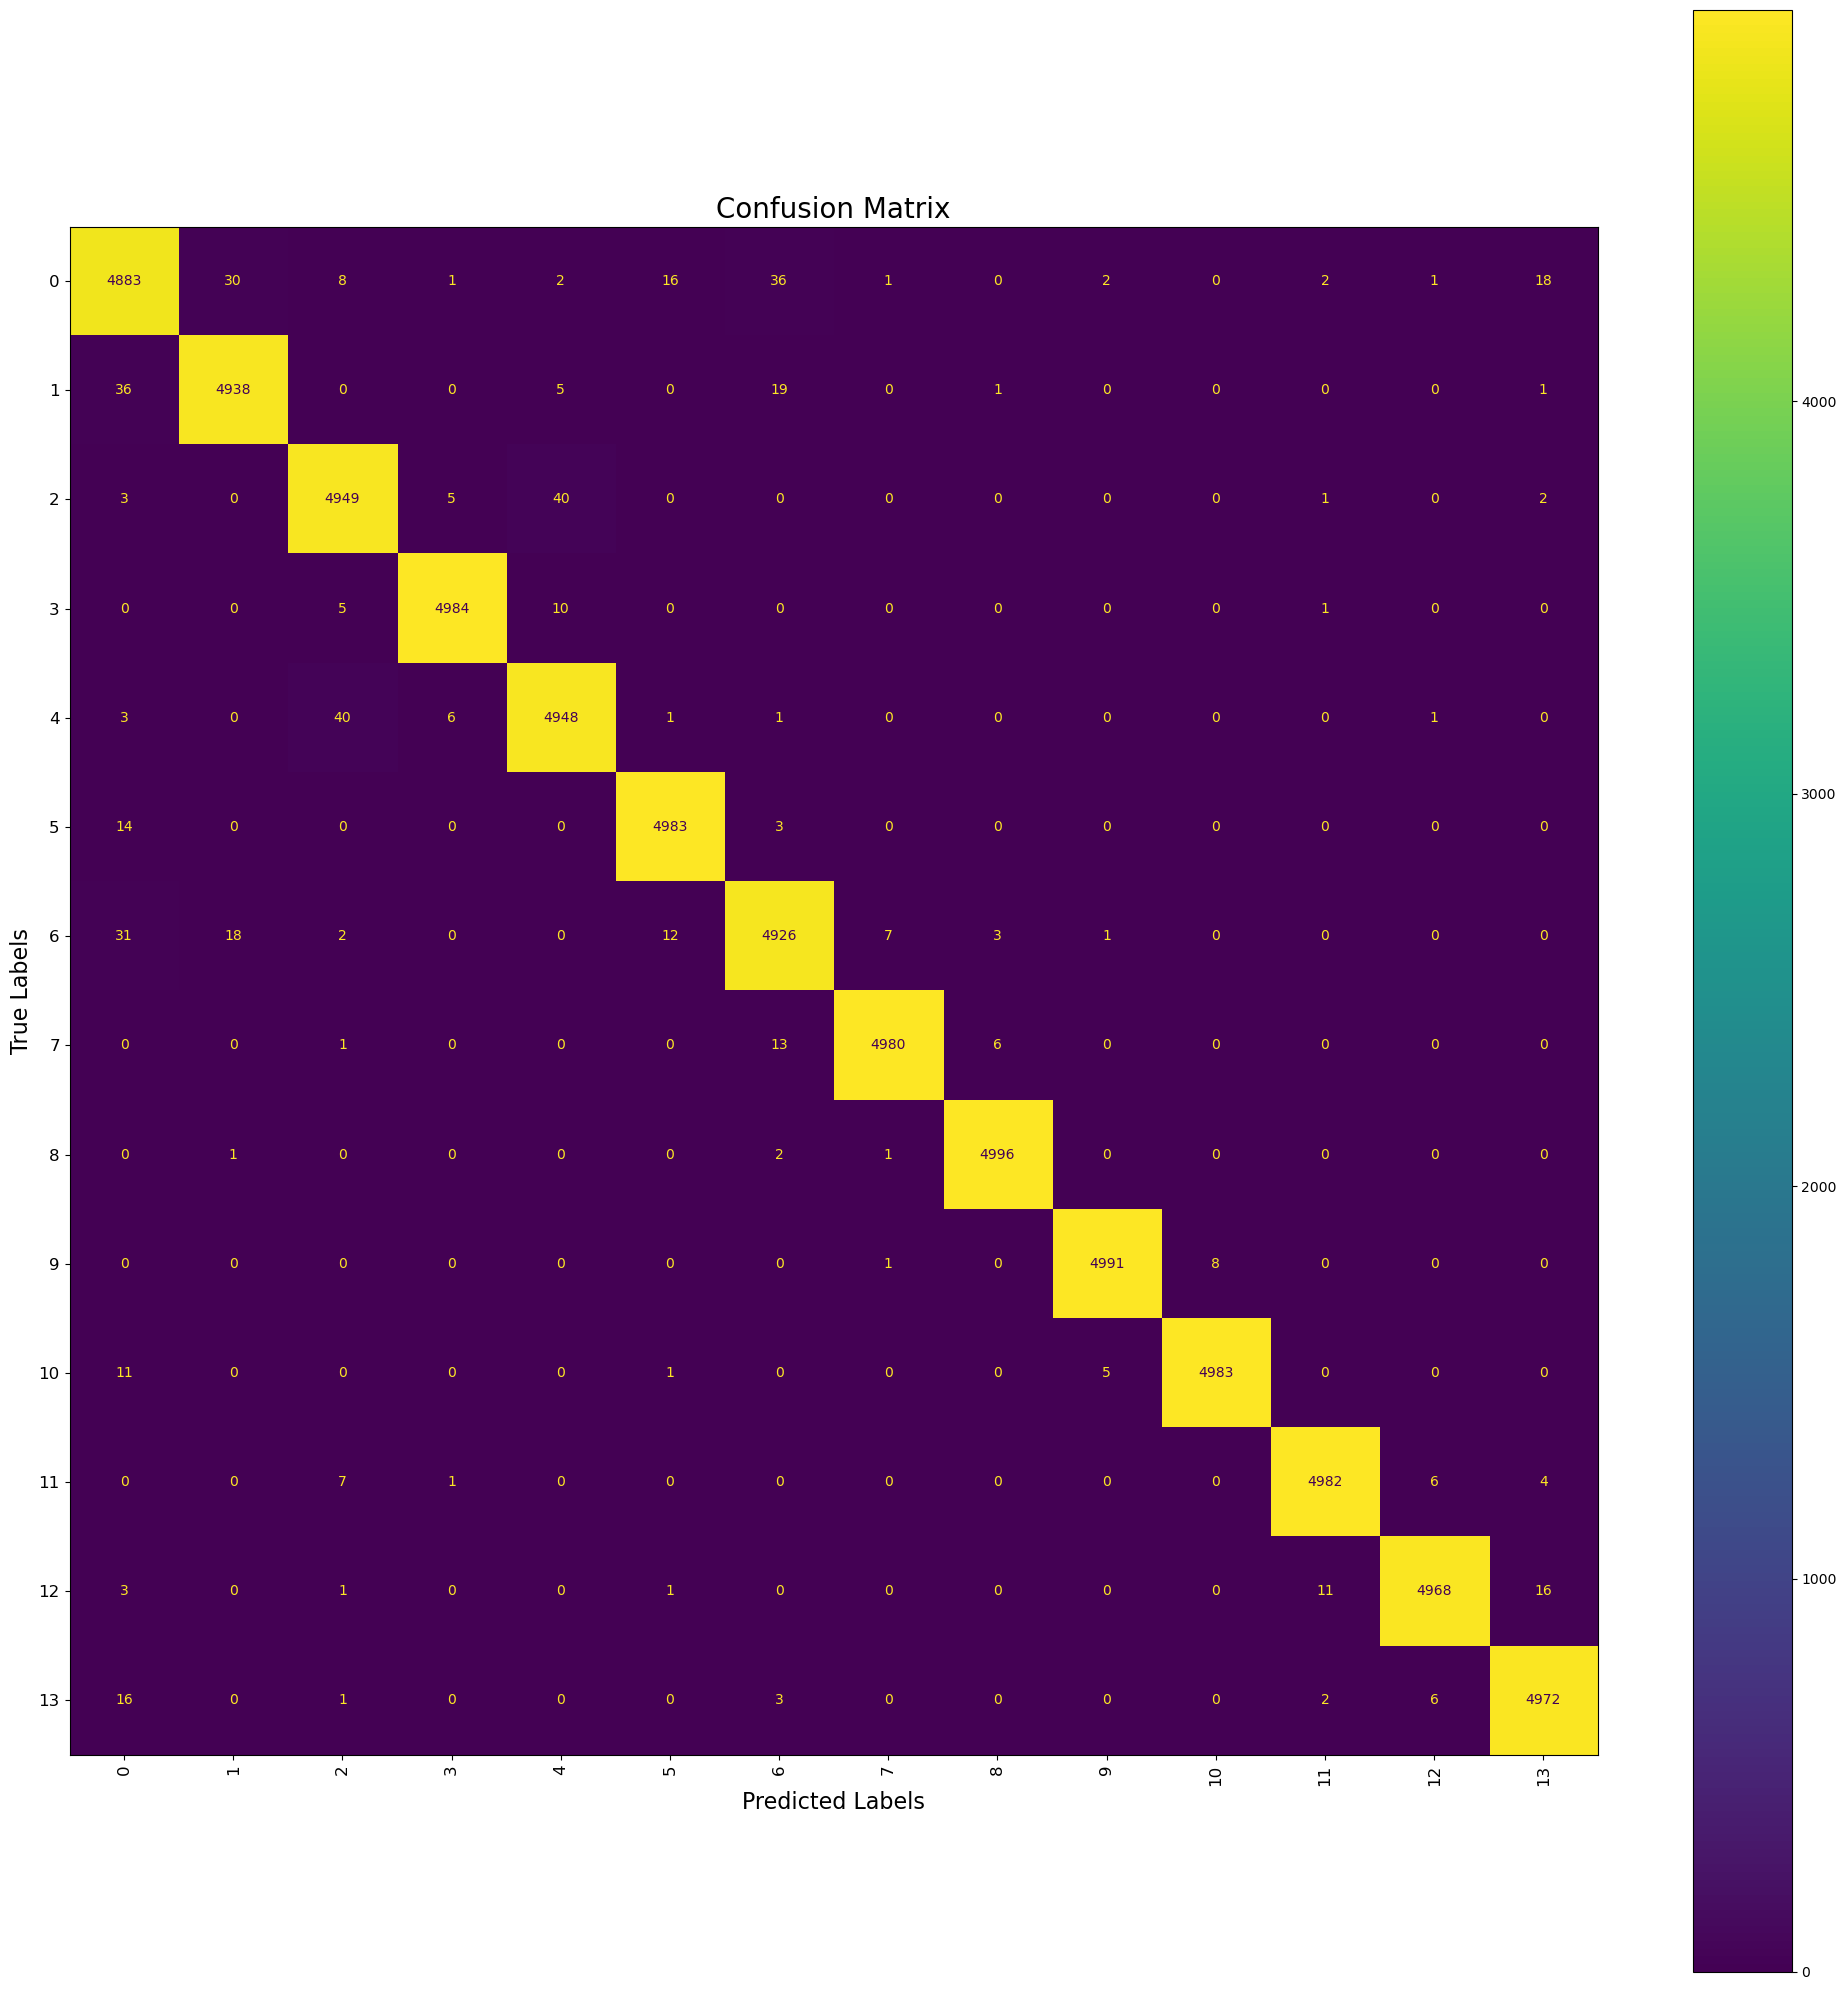

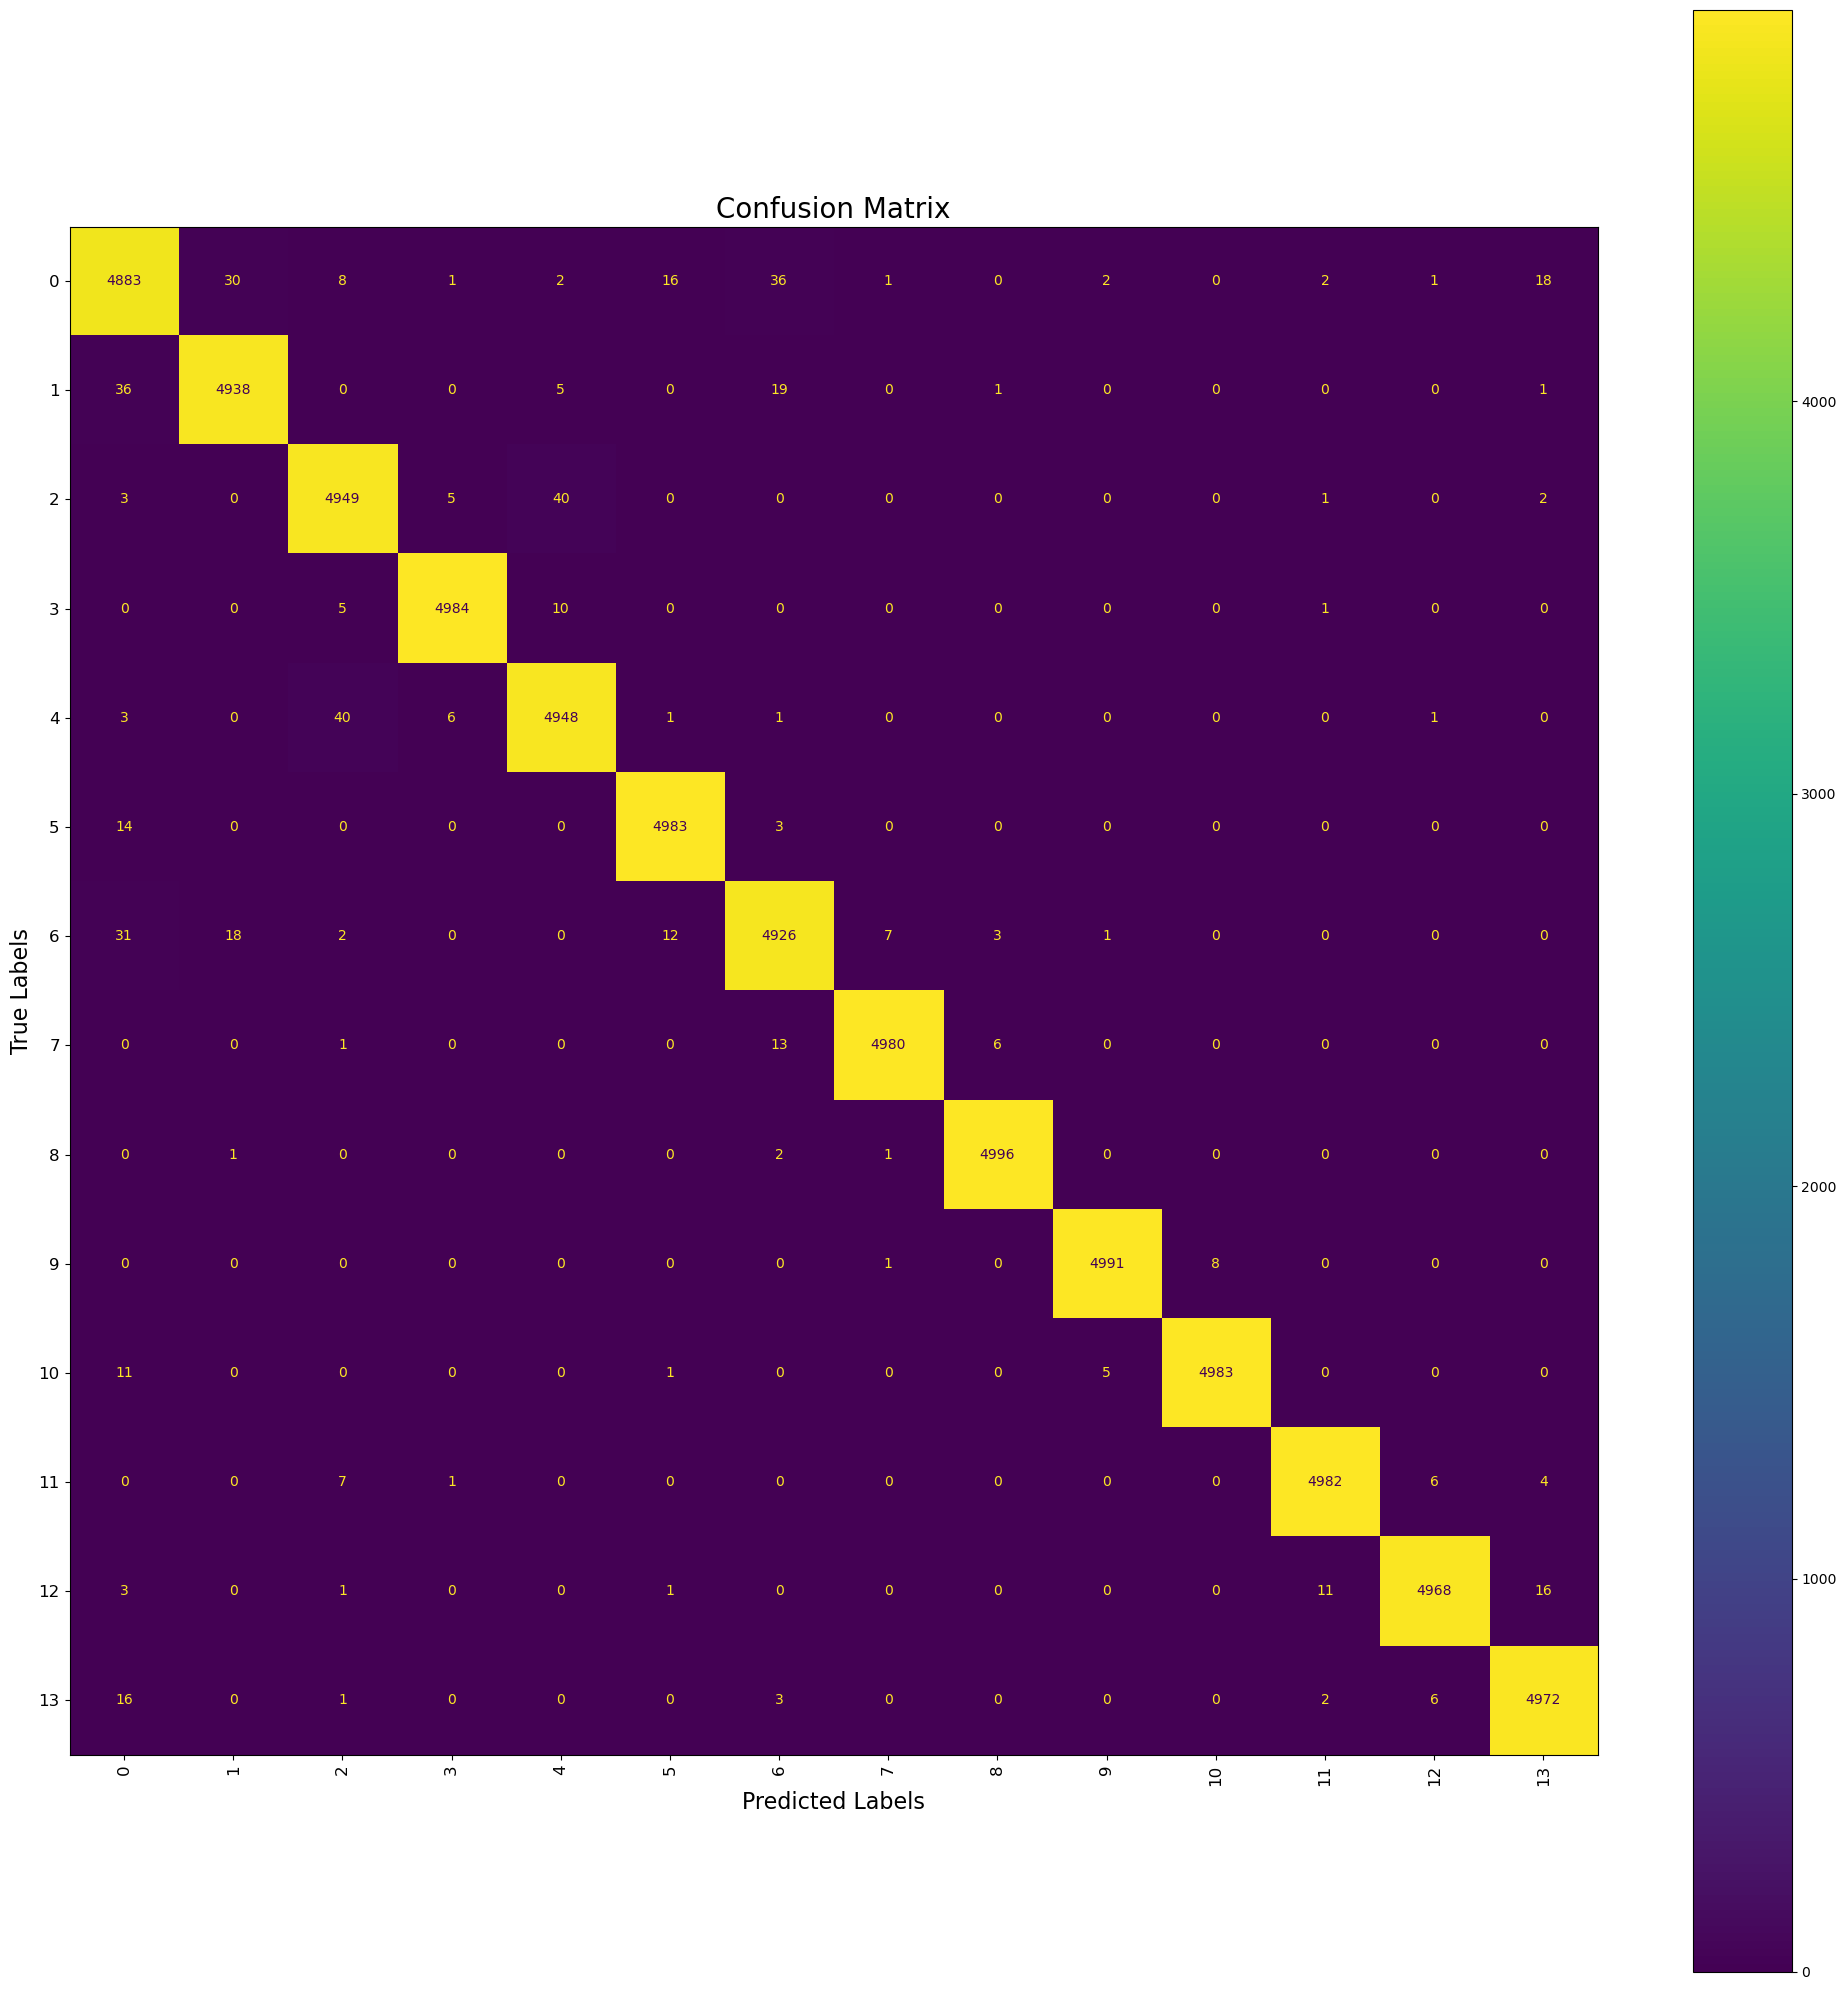

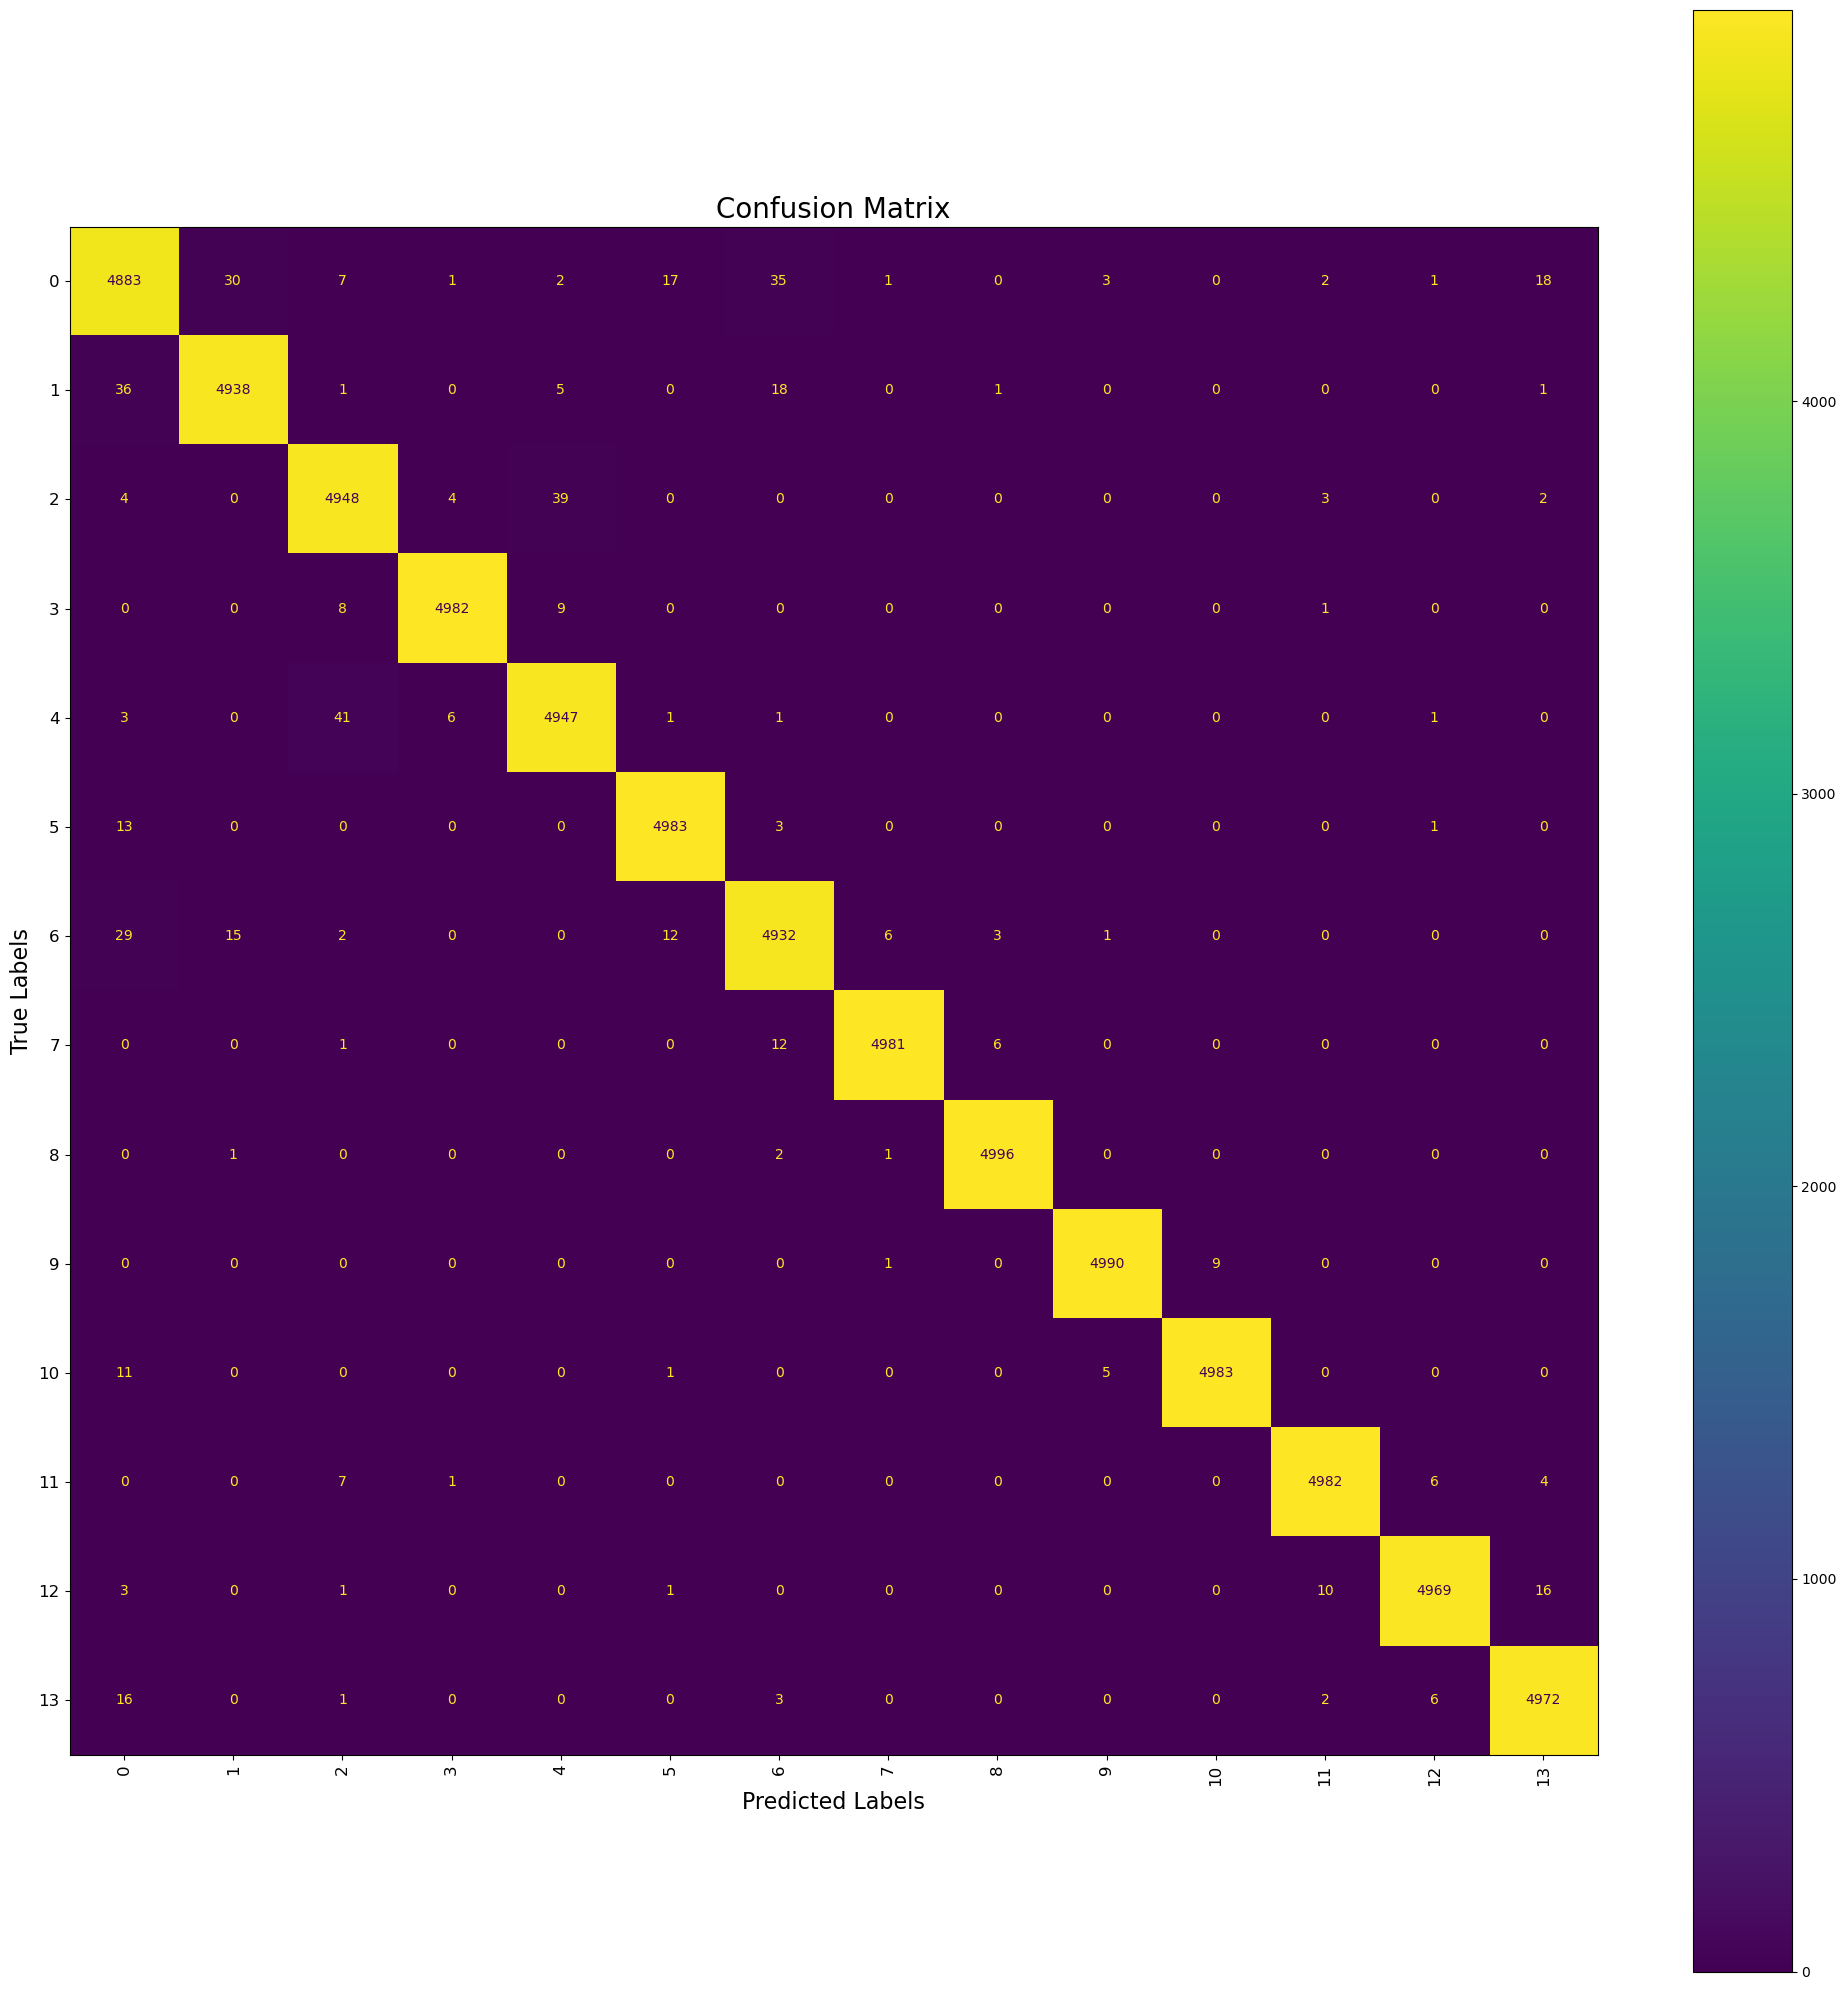

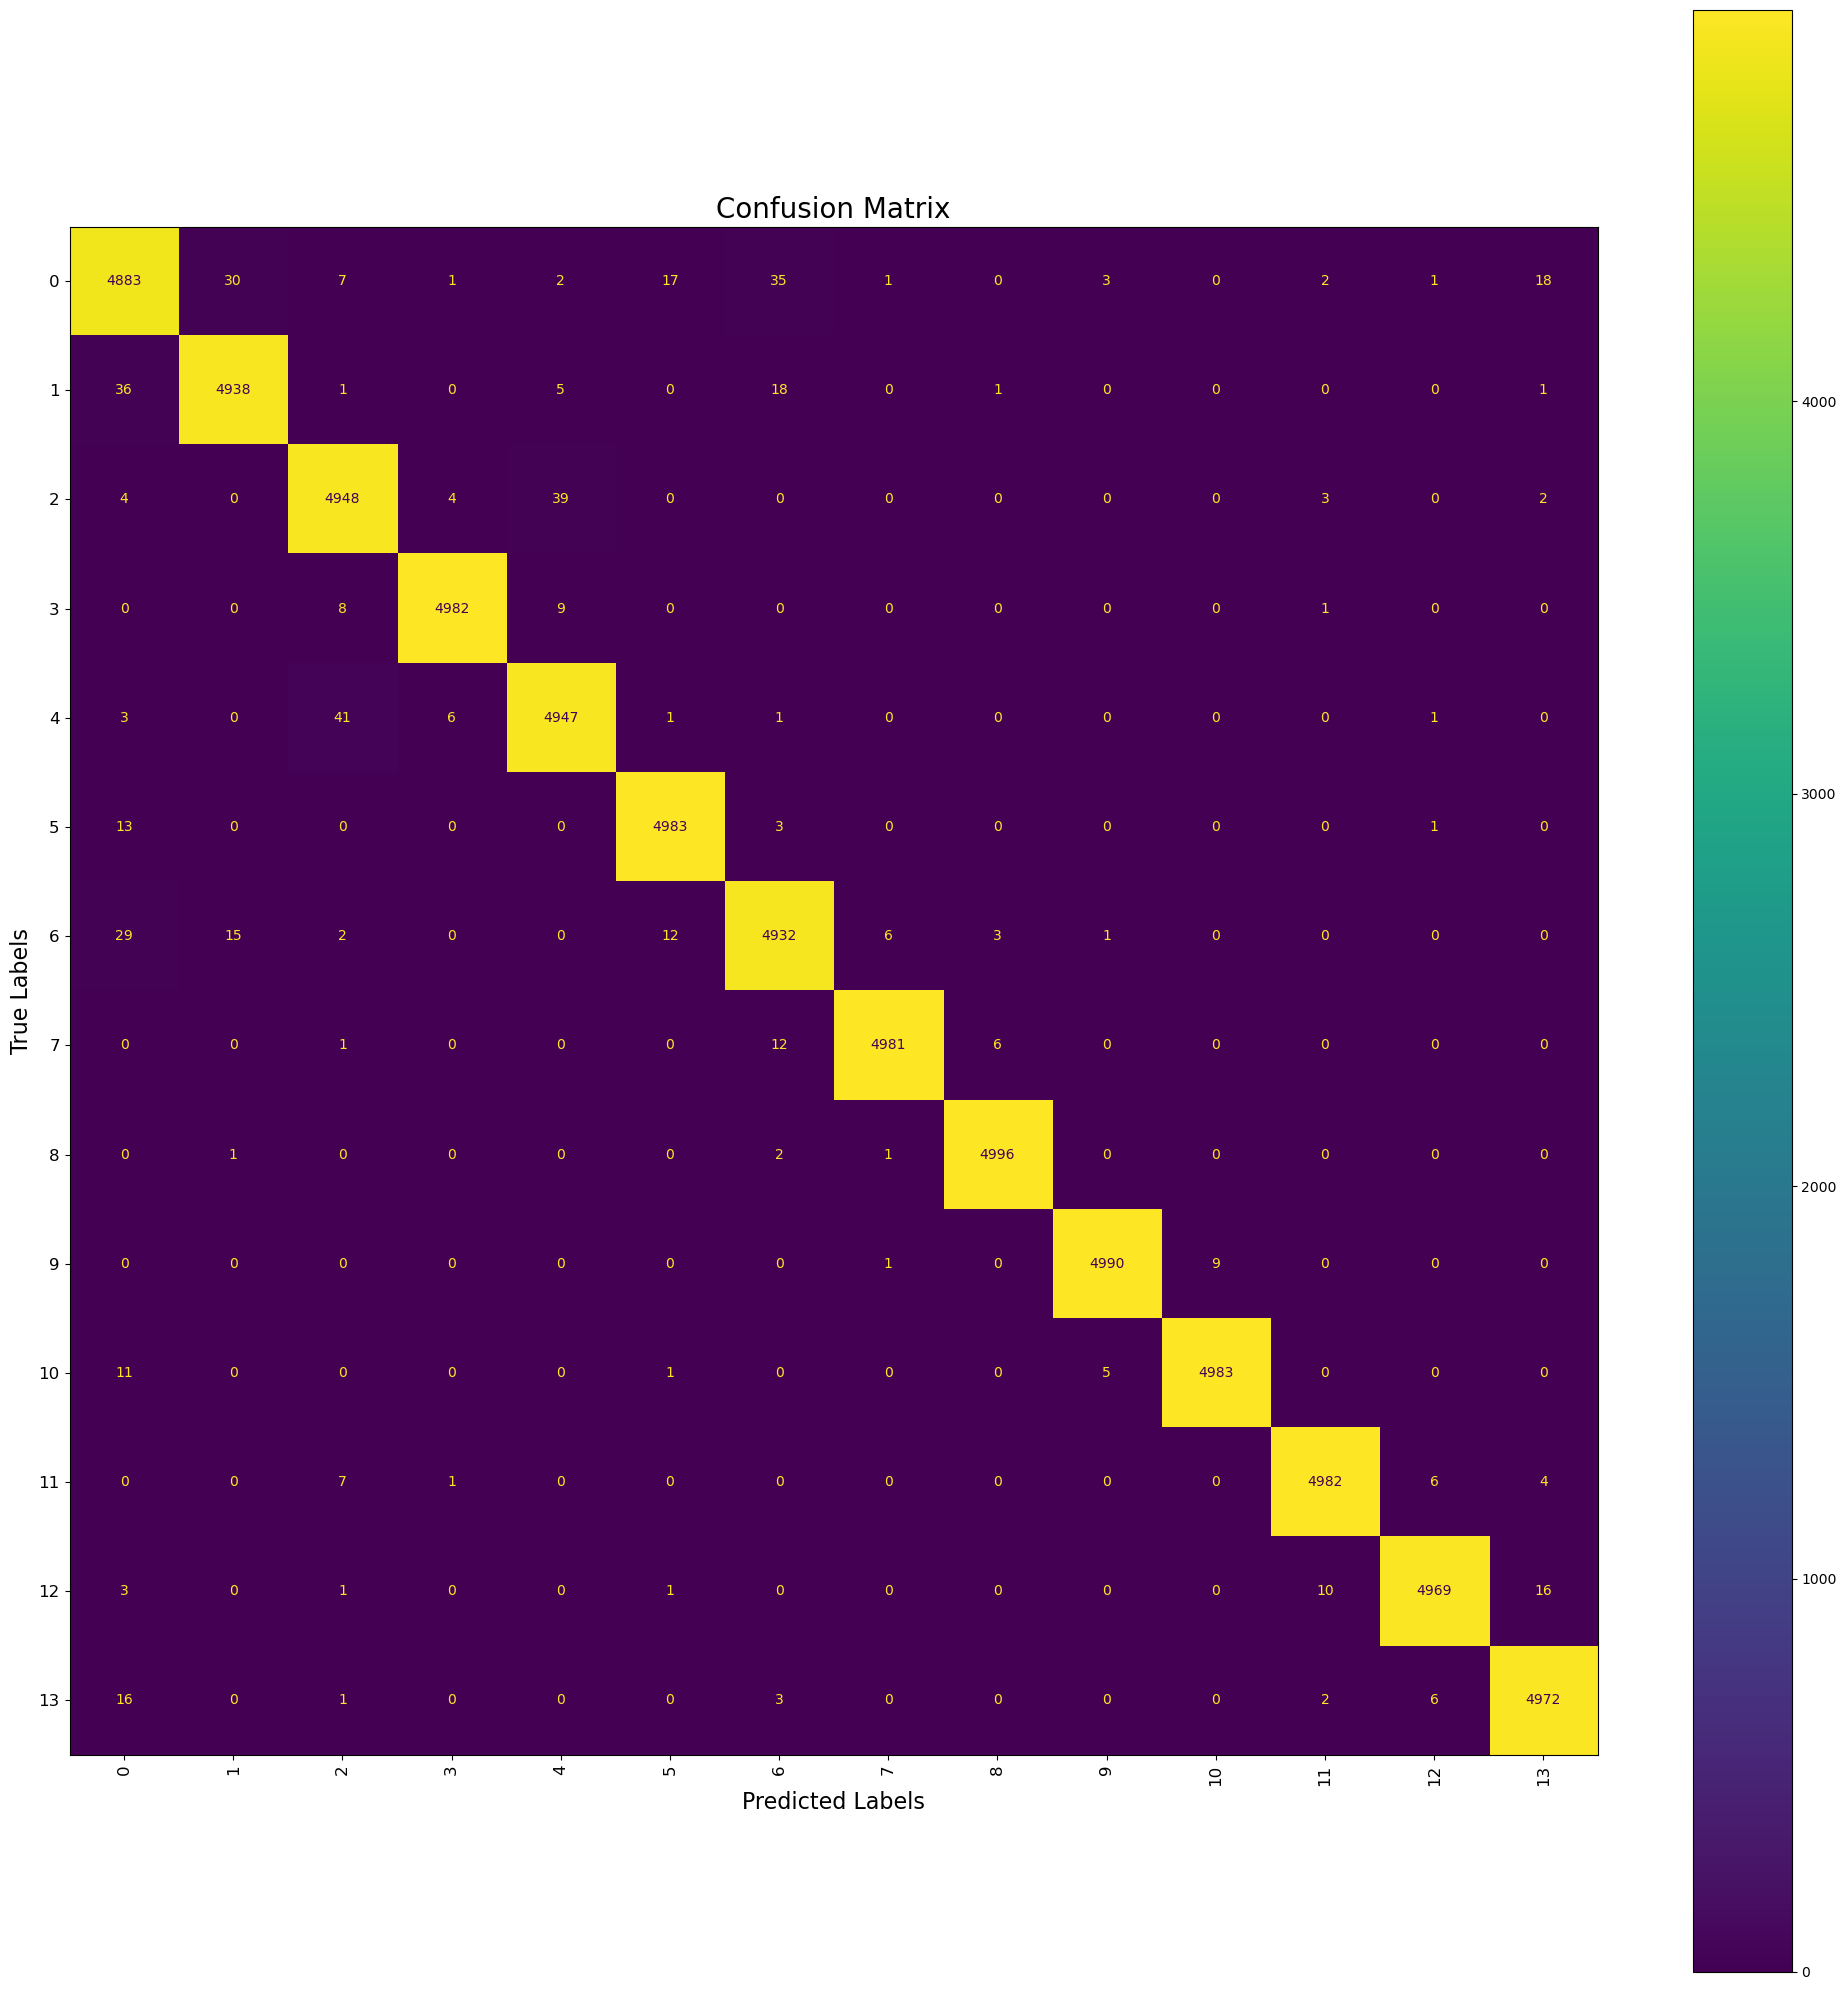

In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from transformers import Trainer
import numpy as np
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Function to preprocess the dataset
def preprocess_function(examples, tokenizer, max_length=128):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=max_length
    )



# Loss function (you can change this based on your model)
loss_fn = nn.CrossEntropyLoss()

def evaluate_model(model, dataloader, device):
    model.eval()
    model_predictions = []
    model_labels = []
    total_loss = 0.0
    total_samples = 0

    # Evaluate the model
    for batch in dataloader:
        inputs = {key: value.to(device) for key, value in batch.items() if key != "labels"}
        labels = batch["labels"].to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            predictions = logits.argmax(dim=1)

            # Calculate loss
            loss = loss_fn(logits, labels)
            total_loss += loss.item() * labels.size(0)  # Multiply by batch size
            total_samples += labels.size(0)

            # Collect predictions and true labels
            model_predictions.extend(predictions.cpu().numpy())
            model_labels.extend(labels.cpu().numpy())

    # Calculate average loss
    avg_loss = total_loss / total_samples

    # Calculate accuracy
    accuracy = accuracy_score(model_labels, model_predictions)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Calculate F1 score
    f1 = f1_score(model_labels, model_predictions, average='weighted')
    print(f"F1-Score: {f1 * 100:.2f}%")

    # Print confusion matrix and classification report
    print("Confusion Matrix:")
    print(confusion_matrix(model_labels, model_predictions))
    print("Classification Report:")
    print(classification_report(model_labels, model_predictions))

    # Generate confusion matrix and plot
    cm = confusion_matrix(model_labels, model_predictions)
    fig, ax = plt.subplots(figsize=(20, 20))  # Adjust figsize for large matrix

    # Use class labels for better interpretability
    class_labels = model.config.id2label if hasattr(model.config, "id2label") else [str(i) for i in range(len(cm))]

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax, xticks_rotation='vertical')  # Rotate labels if needed

    plt.title("Confusion Matrix", fontsize=20)
    plt.xlabel("Predicted Labels", fontsize=16)
    plt.ylabel("True Labels", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()
    plt.savefig(f'confusion_matrix_epoch_{epoch}_epochs_qlora.pdf')

    # Return accuracy, F1 score, and average loss
    return accuracy, f1, avg_loss

# Function to save the model after each epoch
def save_model(trainer, epoch):
    model_save_path = f"./saved_models/model_epoch_{epoch}"
    trainer.save_model(model_save_path)
    print(f"Model saved after epoch {epoch} at {model_save_path}")

# Initialize tokenizer
tokenizer = trainer.tokenizer

# Tokenize the dataset and check its content
def check_tokenization(dataset, tokenizer):
    tokenized_dataset = dataset.map(lambda examples: preprocess_function(examples, tokenizer), batched=True)
    print(f"Tokenized Dataset Sample: {tokenized_dataset[:2]}")  # Check first 2 examples for tokenization
    return tokenized_dataset

# Tokenize the dataset
def preprocess_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

# Assuming dataset['test'] contains the test data
tokenized_dataset = dataset["test"].map(preprocess_function, batched=True)
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Check if tokenized dataset is empty
if len(tokenized_dataset) == 0:
    raise ValueError("Tokenized dataset is empty. Please check your preprocessing steps.")

# Create DataLoader for the dataset
dataloader = DataLoader(tokenized_dataset, batch_size=8)

all_epoch_metrics = []

# Evaluate the model after each epoch and get accuracy and F1 score
accuracy, f1, val_loss = evaluate_model(trainer.model, dataloader, device)

# Store metrics for this epoch
all_epoch_metrics.append({
    "epoch": epoch,
    "accuracy": accuracy,
    "f1_score": f1,
    "val_loss":val_loss
})

# Start training and evaluation loop
for epoch in range(1, 10):
    # Training for one epoch
    trainer.train()
    
    # Save the model after each epoch
    save_model(trainer, epoch)
    
    # Evaluate the model after each epoch
    evaluate_model(trainer.model, dataloader, device)
    
    # Print some final information
    #print(f"Evaluation completed for epoch {epoch}.")

    # Evaluate the model after each epoch and get accuracy and F1 score
    accuracy, f1, val_loss = evaluate_model(trainer.model, dataloader, device)
    
    # Store metrics for this epoch
    all_epoch_metrics.append({
        "epoch": epoch,
        "accuracy": accuracy,
        "f1_score": f1,
        "val_loss":val_loss
    })

    
# Print the global metrics for all epochs
#print("Metrics for all epochs (1 to 10):")
#for metrics in all_epoch_metrics:
#    print(f"Epoch {metrics['epoch']}: Accuracy = {metrics['accuracy']:.4f}, F1 Score = {metrics['f1_score']:.4f}")


In [ ]:
#all_epochs_2 = all_epoch_metrics[1:]
#all_e = all_epoch_metrics
#all_epoch_metrics = all_e

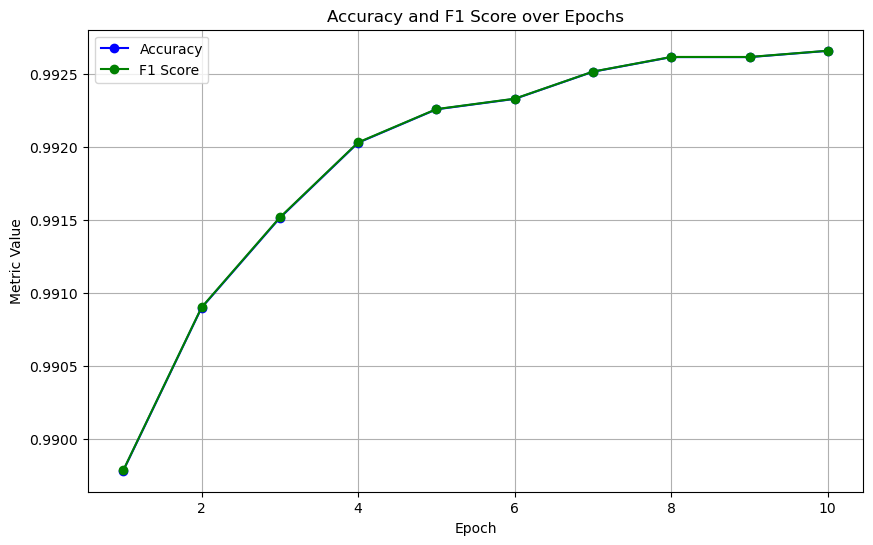

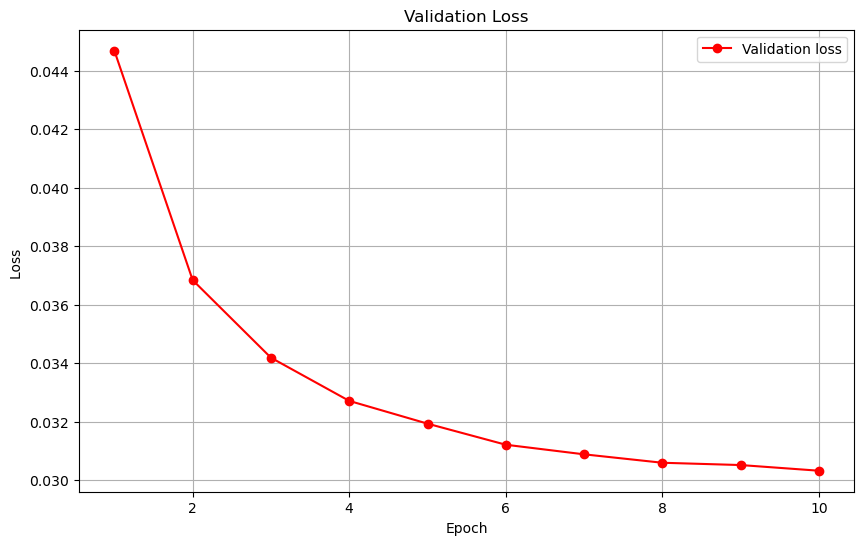

In [ ]:
import matplotlib.pyplot as plt
"""accuracy, f1, val_loss = evaluate_model(trainer.model, dataloader, device)
all_epoch_metrics.insert(0,{
        "epoch": epoch,
        "accuracy": accuracy,
        "f1_score": f1,
        "val_loss":val_loss
    })"""
all


# Extract the epoch, accuracy, and f1_score from the list
epochs = [metric["epoch"] for metric in all_epoch_metrics]
accuracies = [metric["accuracy"] for metric in all_epoch_metrics]
f1_scores = [metric["f1_score"] for metric in all_epoch_metrics]
val_losses = [metric["val_loss"] for metric in all_epoch_metrics]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot accuracy
plt.plot(epochs, accuracies, label='Accuracy', color='blue', marker='o')

# Plot F1 score
plt.plot(epochs, f1_scores, label='F1 Score', color='green', marker='o')

# Add titles and labels
plt.title('Accuracy and F1 Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')

# Show legend
plt.legend()

# Display the plot
plt.grid(True)

# Save the plot as a PDF file
plt.savefig('lora_distillbert_accuracy_f1_score_over_epochs.pdf', format='pdf')
plt.show()


# Create the plot
plt.figure(figsize=(10, 6))


# Plot F1 score
plt.plot(epochs, val_losses, label='Validation loss', color='red', marker='o')

# Add titles and labels
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss ')

# Show legend
plt.legend()

# Display the plot
plt.grid(True)

# Save the plot as a PDF file
plt.savefig('lora_distillbert_loss_over_epochs.pdf', format='pdf')
plt.show()

In [ ]:
import torch
import os
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from transformers import AutoTokenizer

# Set the device to GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize the dataset
def preprocess_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

# Assuming dataset['test'] contains the test data
tokenized_dataset = dataset["test"].map(preprocess_function, batched=True)
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])



# Load and evaluate each saved model
saved_model_paths = [f"./saved_models/model_epoch_{epoch}" for epoch in range(training_args.num_train_epochs)]

# Track predictions and labels across all models


# Loop over saved models and evaluate each one
for model_path in saved_model_paths:
    model = model_info["model"].from_pretrained(model_path)  # Load the model
    model.to(device)
    model.eval()

    
    


OSError: distilbert is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [ ]:
"""import os
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
from transformers import TrainingArguments, Trainer

# Enable CUDA launch blocking for debugging
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"



# Training configurations
training_args = TrainingArguments(
    output_dir="./results_real_data",
    evaluation_strategy="steps",
    save_strategy="steps",
    logging_dir="./logs",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    weight_decay=0.01,
    push_to_hub=False,
    logging_first_step=False,  # Make sure logs are being stored
    # Best model configuration
    
)
"""
"""load_best_model_at_end=True, # Load the best model based on eval_loss
    metric_for_best_model="eval_loss",  # Use eval_loss to select the best model
    greater_is_better=False,  # Lower loss is better""""""

# Train the model "distilbert"
model_name = "distilbert"
model_info = models[model_name]
print(f"Training {model_name} ({model_info['size']}) with standard fine-tuning...")

# Track the best model based on eval_loss and eval_accuracy
best_eval_loss = float("inf")
best_eval_accuracy = 0
best_model = None

# Assuming train_model is a function that handles the actual training and returns a Trainer object
trainer = train_model(model_name, model_info["model"], tokenizers[model_name], dataset, training_args, lora=True)

# Train the model
#trainer.train()

# Access the best model
best_model = trainer.model

# Save the best model
trainer.save_model("./best_model")

# After training, print the final evaluation and confusion matrix
eval_metrics = trainer.evaluate()
train_metrics = trainer.state.log_history[-1]  # Assuming the last logged metric is training loss



"""

c:\Users\kpreube\miniconda3\envs\llm\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Training distilbert (750MB) with standard fine-tuning...
Applying QLoRA to distilbert...
LoraModel(
  (model): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            

  0%|          | 0/6790 [00:00<?, ?it/s]

{'loss': 2.8235, 'grad_norm': 2.0356478691101074, 'learning_rate': 1.8527245949926363e-05, 'epoch': 0.74}


  0%|          | 0/85 [00:00<?, ?it/s]

{'eval_runtime': 4.8131, 'eval_samples_per_second': 1127.333, 'eval_steps_per_second': 17.66, 'epoch': 0.74}
{'loss': 2.4061, 'grad_norm': 3.4113643169403076, 'learning_rate': 1.7054491899852725e-05, 'epoch': 1.47}


  0%|          | 0/85 [00:00<?, ?it/s]

{'eval_runtime': 4.8955, 'eval_samples_per_second': 1108.369, 'eval_steps_per_second': 17.363, 'epoch': 1.47}
{'loss': 2.1884, 'grad_norm': 3.0998194217681885, 'learning_rate': 1.5581737849779087e-05, 'epoch': 2.21}


  0%|          | 0/85 [00:00<?, ?it/s]

{'eval_runtime': 4.7094, 'eval_samples_per_second': 1152.152, 'eval_steps_per_second': 18.049, 'epoch': 2.21}
{'loss': 2.0562, 'grad_norm': 3.130843162536621, 'learning_rate': 1.410898379970545e-05, 'epoch': 2.95}


  0%|          | 0/85 [00:00<?, ?it/s]

{'eval_runtime': 4.7628, 'eval_samples_per_second': 1139.256, 'eval_steps_per_second': 17.847, 'epoch': 2.95}
{'loss': 1.9626, 'grad_norm': 3.815800905227661, 'learning_rate': 1.2636229749631813e-05, 'epoch': 3.68}


  0%|          | 0/85 [00:00<?, ?it/s]

{'eval_runtime': 4.7249, 'eval_samples_per_second': 1148.376, 'eval_steps_per_second': 17.99, 'epoch': 3.68}
{'loss': 1.8911, 'grad_norm': 5.006130218505859, 'learning_rate': 1.1163475699558174e-05, 'epoch': 4.42}


  0%|          | 0/85 [00:00<?, ?it/s]

{'eval_runtime': 4.8742, 'eval_samples_per_second': 1113.213, 'eval_steps_per_second': 17.439, 'epoch': 4.42}
{'loss': 1.8544, 'grad_norm': 4.635988235473633, 'learning_rate': 9.690721649484536e-06, 'epoch': 5.15}


  0%|          | 0/85 [00:00<?, ?it/s]

{'eval_runtime': 4.7866, 'eval_samples_per_second': 1133.581, 'eval_steps_per_second': 17.758, 'epoch': 5.15}
{'loss': 1.8075, 'grad_norm': 5.13299036026001, 'learning_rate': 8.217967599410898e-06, 'epoch': 5.89}


  0%|          | 0/85 [00:00<?, ?it/s]

{'eval_runtime': 4.8211, 'eval_samples_per_second': 1125.471, 'eval_steps_per_second': 17.631, 'epoch': 5.89}
{'loss': 1.7867, 'grad_norm': 5.151027679443359, 'learning_rate': 6.7452135493372616e-06, 'epoch': 6.63}


  0%|          | 0/85 [00:00<?, ?it/s]

{'eval_runtime': 4.7644, 'eval_samples_per_second': 1138.863, 'eval_steps_per_second': 17.841, 'epoch': 6.63}
{'loss': 1.7627, 'grad_norm': 5.350717544555664, 'learning_rate': 5.272459499263623e-06, 'epoch': 7.36}


  0%|          | 0/85 [00:00<?, ?it/s]

{'eval_runtime': 4.7614, 'eval_samples_per_second': 1139.584, 'eval_steps_per_second': 17.852, 'epoch': 7.36}
{'loss': 1.7436, 'grad_norm': 4.913346767425537, 'learning_rate': 3.7997054491899852e-06, 'epoch': 8.1}


  0%|          | 0/85 [00:00<?, ?it/s]

{'eval_runtime': 4.7403, 'eval_samples_per_second': 1144.653, 'eval_steps_per_second': 17.931, 'epoch': 8.1}
{'loss': 1.734, 'grad_norm': 5.051120758056641, 'learning_rate': 2.326951399116348e-06, 'epoch': 8.84}


  0%|          | 0/85 [00:00<?, ?it/s]

{'eval_runtime': 4.7066, 'eval_samples_per_second': 1152.841, 'eval_steps_per_second': 18.06, 'epoch': 8.84}
{'loss': 1.7205, 'grad_norm': 6.473540306091309, 'learning_rate': 8.5419734904271e-07, 'epoch': 9.57}


  0%|          | 0/85 [00:00<?, ?it/s]

{'eval_runtime': 4.7637, 'eval_samples_per_second': 1139.03, 'eval_steps_per_second': 17.843, 'epoch': 9.57}
{'train_runtime': 890.0026, 'train_samples_per_second': 487.751, 'train_steps_per_second': 7.629, 'train_loss': 1.9693598751467, 'epoch': 10.0}


  0%|          | 0/85 [00:00<?, ?it/s]

In [ ]:
"""import matplotlib.pyplot as plt

# Extract the log history from the Trainer
logs = trainer.state.log_history

# Prepare data for plotting
train_loss = [entry['loss'] for entry in logs if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in logs if 'eval_loss' in entry]
steps = [entry['step'] for entry in logs if 'step' in entry and 'loss' in entry]
eval_loss = eval_loss[0:-1]
# Plot training and evaluation loss
plt.figure(figsize=(10, 6))
plt.plot(steps, train_loss, label="Training Loss", marker='o')
plt.plot(steps, eval_loss, label="Validation Loss", marker='o')
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.savefig('training_and_val_loss_distilbert_best_model_10_epochs_qlora.pdf')
plt.show()"""

'import matplotlib.pyplot as plt\n\n# Extract the log history from the Trainer\nlogs = trainer.state.log_history\n\n# Prepare data for plotting\ntrain_loss = [entry[\'loss\'] for entry in logs if \'loss\' in entry]\neval_loss = [entry[\'eval_loss\'] for entry in logs if \'eval_loss\' in entry]\nsteps = [entry[\'step\'] for entry in logs if \'step\' in entry and \'loss\' in entry]\neval_loss = eval_loss[0:-1]\n# Plot training and evaluation loss\nplt.figure(figsize=(10, 6))\nplt.plot(steps, train_loss, label="Training Loss", marker=\'o\')\nplt.plot(steps, eval_loss, label="Validation Loss", marker=\'o\')\nplt.xlabel("Training Steps")\nplt.ylabel("Loss")\nplt.title("Training and Validation Loss")\nplt.legend()\nplt.savefig(\'training_and_val_loss_distilbert_best_model_10_epochs_qlora.pdf\')\nplt.show()'

In [ ]:
"""# Assuming you logged 'eval_accuracy' during training
eval_accuracy = [entry['eval_accuracy'] for entry in logs if 'eval_accuracy' in entry]
eval_accuracy = eval_accuracy[:-1]
# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(steps, eval_accuracy, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.savefig('validation_accuracy_distilbert_best_model_10_epochs_qlora.pdf')
plt.show()
"""

'# Assuming you logged \'eval_accuracy\' during training\neval_accuracy = [entry[\'eval_accuracy\'] for entry in logs if \'eval_accuracy\' in entry]\neval_accuracy = eval_accuracy[:-1]\n# Plot accuracy\nplt.figure(figsize=(10, 6))\nplt.plot(steps, eval_accuracy, label="Validation Accuracy", marker=\'o\')\nplt.xlabel("Epochs")\nplt.ylabel("Accuracy")\nplt.title("Validation Accuracy")\nplt.legend()\nplt.savefig(\'validation_accuracy_distilbert_best_model_10_epochs_qlora.pdf\')\nplt.show()\n'

In [ ]:
"""# Generate confusion matrix for "distilbert"
print(f"Evaluating {model_name} on the test dataset...")

# Make predictions on the test set
predictions = trainer.predict(dataset["test"])
preds = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Print and plot the confusion matrix
print("Classification Report:")
print(classification_report(true_labels, preds))

labels = list(set(true_labels))  # Assuming labels are numeric and continuous
tokenized_inputs = tokenizer(
    raw_texts,
    padding=True,          # Pad to the longest sequence in the batch
    truncation=True,       # Truncate sequences to the model's max length
    max_length=128,        # Set max length explicitly
    return_tensors="pt"    # Return PyTorch tensors
)plot_confusion_matrix(true_labels, preds, labels, title=f"Confusion Matrix for {model_name}")"""

'# Generate confusion matrix for "distilbert"\nprint(f"Evaluating {model_name} on the test dataset...")\n\n# Make predictions on the test set\npredictions = trainer.predict(dataset["test"])\npreds = np.argmax(predictions.predictions, axis=1)\ntrue_labels = predictions.label_ids\n\n# Print and plot the confusion matrix\nprint("Classification Report:")\nprint(classification_report(true_labels, preds))\n\nlabels = list(set(true_labels))  # Assuming labels are numeric and continuous\ntokenized_inputs = tokenizer(\n    raw_texts,\n    padding=True,          # Pad to the longest sequence in the batch\n    truncation=True,       # Truncate sequences to the model\'s max length\n    max_length=128,        # Set max length explicitly\n    return_tensors="pt"    # Return PyTorch tensors\n)plot_confusion_matrix(true_labels, preds, labels, title=f"Confusion Matrix for {model_name}")'

Load best model

In [ ]:
from peft import PeftModel
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Path to the saved model checkpoint (where the QLoRA model and config are stored)
model_path = "./saved_models/model_epoch_9"  # Update this to your actual saved model path

# Load the model from the checkpoint
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Now apply the QLoRA adapters to the model
model = PeftModel.from_pretrained(model, model_path)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Move model to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Now you can use this model for evaluation or further inference






Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Predictions: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,

Accuracy: 8.92%


(array([0, 1], dtype=int64), array([3548, 1879], dtype=int64))

ValueError: The number of FixedLocator locations (28), usually from a call to set_ticks, does not match the number of labels (2).

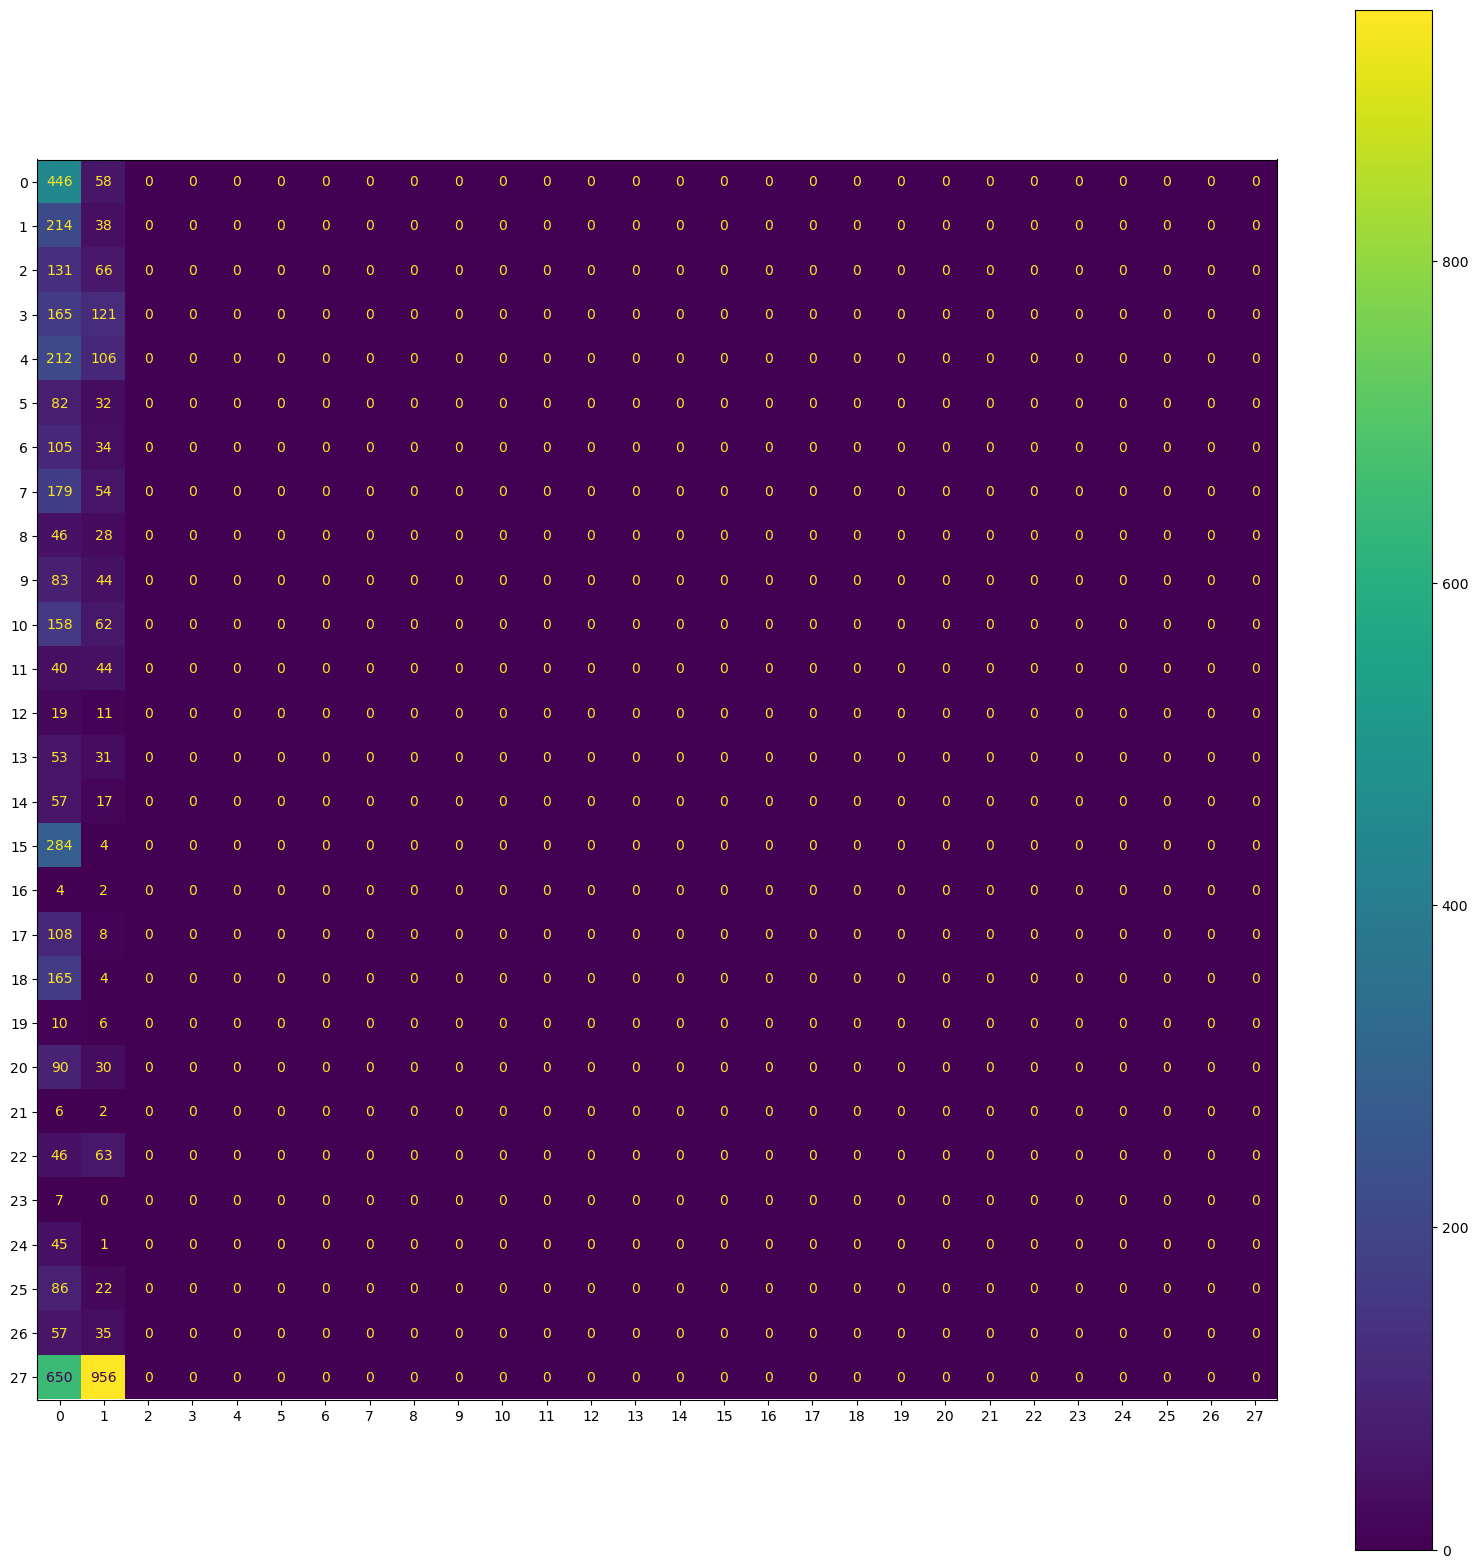

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_predictions))


              precision    recall  f1-score   support

           0       0.59      0.75      0.66      4130
           1       0.63      0.80      0.70      2244
           2       0.39      0.52      0.44      1547
           3       0.26      0.10      0.14      2138
           4       0.48      0.10      0.17      2596
           5       0.44      0.01      0.02       966
           6       0.50      0.06      0.10      1268
           7       0.37      0.67      0.48      1772
           8       0.50      0.01      0.01       543
           9       0.29      0.02      0.03      1028
          10       0.36      0.05      0.08      1651
          11       0.00      0.00      0.00       580
          12       0.00      0.00      0.00       248
          13       0.00      0.00      0.00       700
          14       0.00      0.00      0.00       510
          15       0.67      0.91      0.77      2096
          16       0.00      0.00      0.00        65
          17       0.43    

c:\Users\kpreube\miniconda3\envs\llm\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kpreube\miniconda3\envs\llm\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kpreube\miniconda3\envs\llm\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Now, find where the predictions were 'x' but the actual labels were 'y'
# Define the class labels you are interested in (e.g., predicted as 'x' and actual 'y')
x = 6  # Predicted as 'x'
y = 7  # Actual label 'y'

# Extract the texts where prediction is 'x' but the actual label is 'y'
incorrect_texts = [text for pred, true, text in zip(all_predictions, all_labels, dataset["train"]) if pred == x and true == y]

# Print or save the incorrect texts
print(incorrect_texts)

[{'text': "That must be it? Or that people buy carbon dioxide as plant food? I'm terrible at science and even I know it's not that simple", 'labels': 7, 'id': 'edll7nz'}, {'text': "What's the point of marching for life when you don't respect those living in front of you? I'll never understand these schmucks.", 'labels': 7, 'id': 'eegu3yf'}, {'text': "just like [NAME] was going to win by 90+%? I'm not going to believe it until I see it.", 'labels': 7, 'id': 'eeafre8'}, {'text': 'I know, right? What an embarrassment that local news would call that thing a "tractor".', 'labels': 7, 'id': 'efdb70j'}, {'text': "> I don't care what context this has Why are you so proud of being ignorant?", 'labels': 7, 'id': 'eezd5b1'}, {'text': "Doesnt have insane standards or anything. I don't see what's wrong?", 'labels': 7, 'id': 'efbamvk'}, {'text': 'But what about teams like the cavs? They are clearly a terrible terrible team, but they gotta wait longer to rebuild with a 3 year average.', 'labels': 7, 

In [ ]:
"""import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForPreTraining

# Load tokenizer and model
model_path = "./results_real_data/checkpoint-27140"  # Update with your checkpoint path
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForPreTraining.from_pretrained(model_path)

# Map predictions to emotion labels
label_mapping = {
    0: "admiration",
    1: "amusement",
    2: "anger",
    3: "annoyance",
    4: "approval",
    5: "caring",
    6: "confusion",
    7: "curiosity",
    8: "desire",
    9: "disappointment",
    10: "disapproval",
    11: "disgust",
    12: "embarrassment",
    13: "excitement",
    14: "fear",
    15: "gratitude",
    16: "grief",
    17: "joy",
    18: "love",
    19: "nervousness",
    20: "optimism",
    21: "pride",
    22: "realization",
    23: "relief",
    24: "remorse",
    25: "sadness",
    26: "surprise",
    27: "neutral"  # Include "neutral" if applicable
}
"""

'import torch\nfrom transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForPreTraining\n\n# Load tokenizer and model\nmodel_path = "./results_real_data/checkpoint-27140"  # Update with your checkpoint path\ntokenizer = AutoTokenizer.from_pretrained(model_path)\nmodel = AutoModelForPreTraining.from_pretrained(model_path)\n\n# Map predictions to emotion labels\nlabel_mapping = {\n    0: "admiration",\n    1: "amusement",\n    2: "anger",\n    3: "annoyance",\n    4: "approval",\n    5: "caring",\n    6: "confusion",\n    7: "curiosity",\n    8: "desire",\n    9: "disappointment",\n    10: "disapproval",\n    11: "disgust",\n    12: "embarrassment",\n    13: "excitement",\n    14: "fear",\n    15: "gratitude",\n    16: "grief",\n    17: "joy",\n    18: "love",\n    19: "nervousness",\n    20: "optimism",\n    21: "pride",\n    22: "realization",\n    23: "relief",\n    24: "remorse",\n    25: "sadness",\n    26: "surprise",\n    27: "neutral"  # Include "neutra